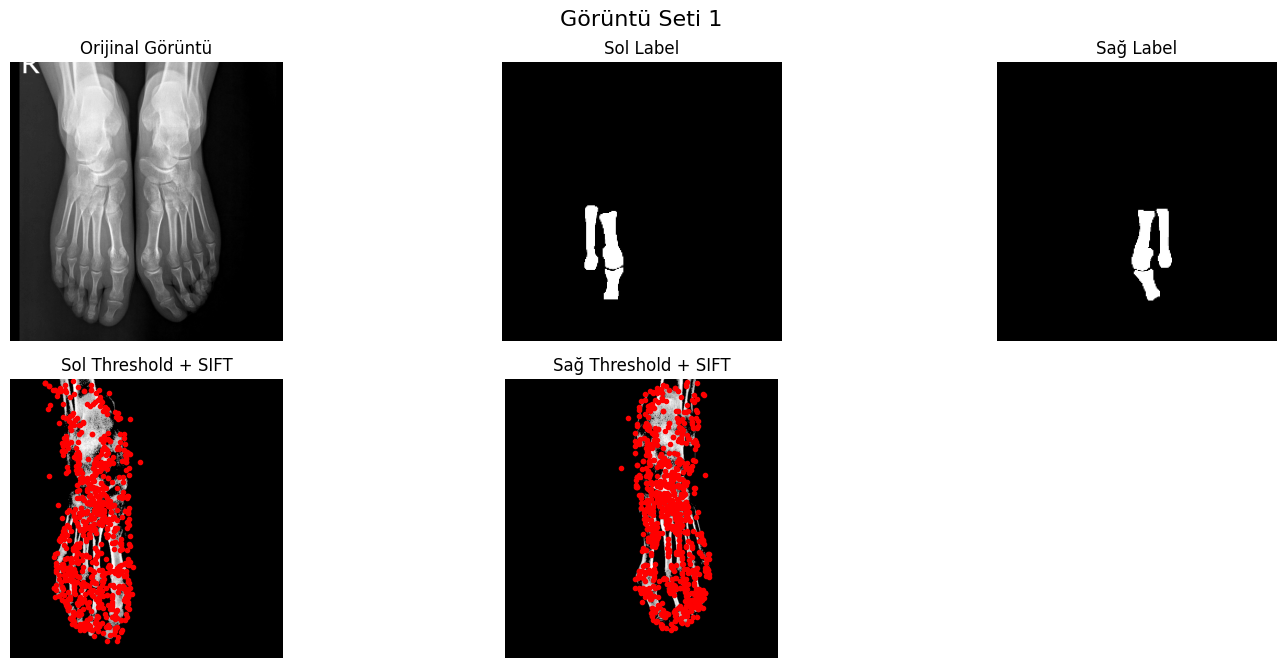


Görüntü Seti 1 İstatistikleri:
Sol Ayak:
Label Ortalama: 6.26
Threshold Ortalama: 20.43
SIFT Nokta Sayısı: 781

Sağ Ayak:
Label Ortalama: 6.24
Threshold Ortalama: 16.85
SIFT Nokta Sayısı: 808


AttributeError: 'NoneType' object has no attribute 'shape'

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.ndimage as ndi
from skimage import filters, feature, morphology
from skimage.feature import hog
from skimage.util import img_as_ubyte
import pickle
%matplotlib inline

def apply_clahe(image):
    """Zıtlık Dönüşümü (CLAHE)"""
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    return clahe_image

def preprocess_image(image):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    enhanced = apply_clahe(gray)
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((5,5), np.uint8)
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

    return opening, enhanced

def minmax_norm(image):
    """MinMax normalizasyon"""
    image_float = image.astype(float)
    min_val = np.min(image_float)
    max_val = np.max(image_float)
    if max_val != min_val:
        normalized = (image_float - min_val) / (max_val - min_val) * 255
    else:
        normalized = image_float
    return normalized.astype(np.uint8)

def optimal_image_enhancement(image):
    """Görüntü iyileştirme"""
    normalized = minmax_norm(image)
    gaussian = cv2.GaussianBlur(normalized, (3,3), 0.3)
    enhanced_base = cv2.convertScaleAbs(gaussian, alpha=1.05, beta=0)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_clahe = clahe.apply(enhanced_base)

    _, threshold = cv2.threshold(enhanced_clahe, 140, 255, cv2.THRESH_TOZERO)

    return threshold

def find_feet_contours(processed_image):
    contours, _ = cv2.findContours(processed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    return contours

def separate_feet(image, processed, enhanced):
    contours = find_feet_contours(processed)

    if len(contours) == 2:
        mask1 = np.zeros_like(processed)
        mask2 = np.zeros_like(processed)

        cv2.drawContours(mask1, [contours[0]], -1, 255, -1)
        cv2.drawContours(mask2, [contours[1]], -1, 255, -1)

        foot1 = cv2.bitwise_and(enhanced, enhanced, mask=mask1)
        foot2 = cv2.bitwise_and(enhanced, enhanced, mask=mask2)

        M1 = cv2.moments(contours[0])
        M2 = cv2.moments(contours[1])

        if M1['m00'] != 0 and M2['m00'] != 0:
            cx1 = int(M1['m10']/M1['m00'])
            cx2 = int(M2['m10']/M2['m00'])

            if cx1 < cx2:
                left_foot = foot1
                right_foot = foot2
                left_mask = mask1
                right_mask = mask2
            else:
                left_foot = foot2
                right_foot = foot1
                left_mask = mask2
                right_mask = mask1

            return left_foot, right_foot, left_mask, right_mask

    height, width = enhanced.shape[:2]
    left_foot = enhanced[:, :width//2]
    right_foot = enhanced[:, width//2:]
    left_mask = np.zeros_like(processed)
    right_mask = np.zeros_like(processed)
    left_mask[:, :width//2] = 255
    right_mask[:, width//2:] = 255

    return left_foot, right_foot, left_mask, right_mask

def extract_sift_keypoints(image):
    """SIFT anahtar noktalarını çıkar"""
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

def get_patch(image, keypoint, patch_size=32):
    """Anahtar nokta etrafından patch çıkar"""
    x, y = int(keypoint.pt[0]), int(keypoint.pt[1])
    half_size = patch_size // 2

    h, w = image.shape[:2]
    x1 = max(0, x - half_size)
    x2 = min(w, x + half_size)
    y1 = max(0, y - half_size)
    y2 = min(h, y + half_size)

    patch = image[y1:y2, x1:x2]

    if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
        patch = cv2.resize(patch, (patch_size, patch_size))

    return patch

def extract_hog_features(patch):
    """Patch'den HOG özelliklerini çıkar"""
    features = hog(patch,
                  orientations=9,
                  pixels_per_cell=(8, 8),
                  cells_per_block=(2, 2),
                  visualize=False)
    return features

def show_comparison(img_path, label_path, title):
    """Görüntü, label ve threshold sonuçlarını göster"""
    # Görüntüleri oku
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

    # Görüntüleri işle
    processed_img, enhanced_img = preprocess_image(img)
    processed_label, enhanced_label = preprocess_image(label)

    # Ayakları ayır
    left_img, right_img, left_mask_img, right_mask_img = separate_feet(img, processed_img, enhanced_img)
    left_label, right_label, left_mask_label, right_mask_label = separate_feet(label, processed_label, enhanced_label)

    # Threshold uygula
    left_threshold = optimal_image_enhancement(left_img)
    right_threshold = optimal_image_enhancement(right_img)

    # SIFT ve HOG özelliklerini çıkar
    features = {}
    for foot_type, foot_img in [('left', left_img), ('right', right_img)]:
        keypoints, sift_desc = extract_sift_keypoints(foot_img)
        if sift_desc is not None:
            foot_features = []
            for idx, kp in enumerate(keypoints):
                patch = get_patch(foot_img, kp)
                if patch.size > 0:
                    hog_features = extract_hog_features(patch)
                    combined = np.concatenate([sift_desc[idx], hog_features])
                    foot_features.append({
                        'keypoint': (kp.pt[0], kp.pt[1]),
                        'sift_desc': sift_desc[idx],
                        'hog_desc': hog_features,
                        'combined': combined
                    })
            features[foot_type] = foot_features

    # Görselleştirme
    plt.figure(figsize=(15, 10))
    plt.suptitle(title, fontsize=16)

    # İlk sıra: Orijinal görüntü
    plt.subplot(331)
    plt.imshow(img, cmap='gray')
    plt.title('Orijinal Görüntü')
    plt.axis('off')

    # İkinci sıra: Ayrılmış labeller
    plt.subplot(332)
    plt.imshow(left_label, cmap='gray')
    plt.title('Sol Label')
    plt.axis('off')

    plt.subplot(333)
    plt.imshow(right_label, cmap='gray')
    plt.title('Sağ Label')
    plt.axis('off')

    # Üçüncü sıra: Threshold sonuçları ve SIFT noktaları
    plt.subplot(334)
    plt.imshow(left_threshold, cmap='gray')
    if 'left' in features:
        for feature in features['left']:
            x, y = feature['keypoint']
            plt.plot(x, y, 'r.')
    plt.title('Sol Threshold + SIFT')
    plt.axis('off')

    plt.subplot(335)
    plt.imshow(right_threshold, cmap='gray')
    if 'right' in features:
        for feature in features['right']:
            x, y = feature['keypoint']
            plt.plot(x, y, 'r.')
    plt.title('Sağ Threshold + SIFT')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # İstatistikler
    print(f"\n{title} İstatistikleri:")
    print("Sol Ayak:")
    print(f"Label Ortalama: {np.mean(left_label):.2f}")
    print(f"Threshold Ortalama: {np.mean(left_threshold):.2f}")
    print(f"SIFT Nokta Sayısı: {len(features.get('left', []))}")
    print("\nSağ Ayak:")
    print(f"Label Ortalama: {np.mean(right_label):.2f}")
    print(f"Threshold Ortalama: {np.mean(right_threshold):.2f}")
    print(f"SIFT Nokta Sayısı: {len(features.get('right', []))}")

    return features

def main():
    image_sets = [
        ('img1.png', 'label1.png', 'features1.pkl', 'Görüntü Seti 1'),
        ('img2.png', 'label2.png', 'features2.pkl', 'Görüntü Seti 2'),
        ('img3.png', 'label3.png', 'features3.pkl', 'Görüntü Seti 3')
    ]

    for img_path, label_path, save_path, title in image_sets:
        # SIFT ve HOG özelliklerini çıkar ve görselleştir
        features = show_comparison(img_path, label_path, title)

        # Özellikleri kaydet
        with open(save_path, 'wb') as f:
            pickle.dump(features, f)

if __name__ == "__main__":
    main()


Özellikler şu dizine kaydedilecek: C:\Users\sense\PycharmProjects\PythonProject1\organ_features

İşleniyor: Görüntü Seti 1
Görüntü dosyası: C:\Users\sense\PycharmProjects\PythonProject1\img1.png
Label dosyası: C:\Users\sense\PycharmProjects\PythonProject1\label1.png

SIFT ve HOG özellikleri çıkarılıyor...

Sol ayak işleniyor...
Özellikler kaydedildi: C:\Users\sense\PycharmProjects\PythonProject1\organ_features\Görüntü Seti 1_left_foot_features.pkl

Özellik detayları:
SIFT anahtar noktaları: 971
HOG özellik boyutu: (971, 288)
LBP özellik boyutu: (971, 10)
Gradient özellik boyutu: (971, 20)
İstatistiksel özellik boyutu: (971, 10)
Doku özellik boyutu: (971, 5)
Dosya boyutu: 4141.25 KB

Sağ ayak işleniyor...
Özellikler kaydedildi: C:\Users\sense\PycharmProjects\PythonProject1\organ_features\Görüntü Seti 1_right_foot_features.pkl

Özellik detayları:
SIFT anahtar noktaları: 950
HOG özellik boyutu: (950, 288)
LBP özellik boyutu: (950, 10)
Gradient özellik boyutu: (950, 20)
İstatistiksel özel

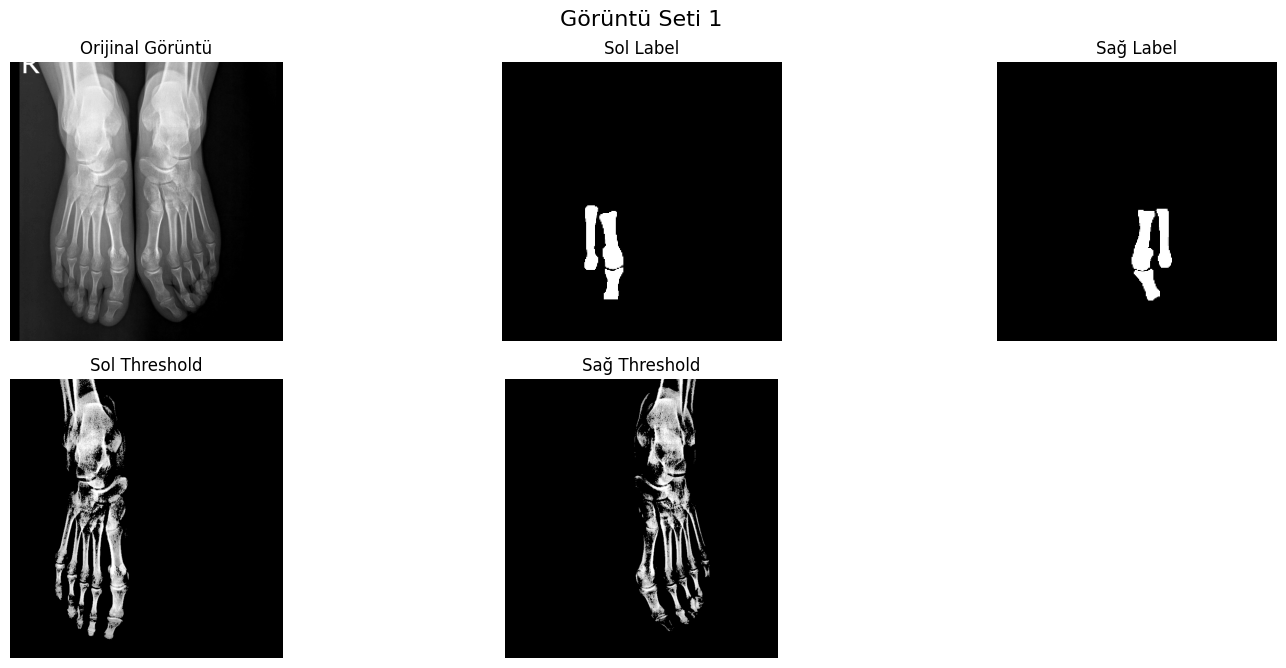

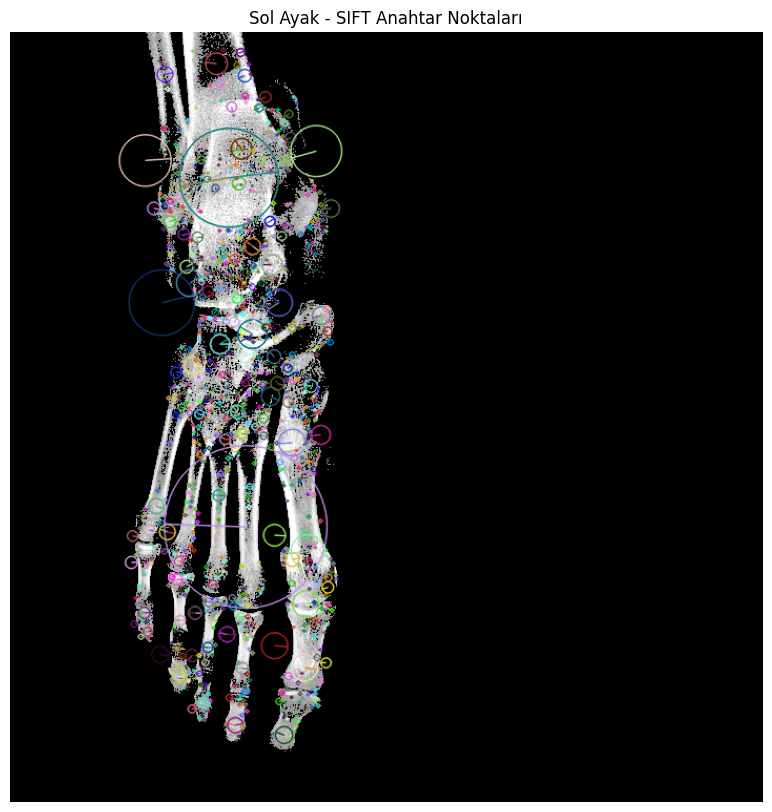

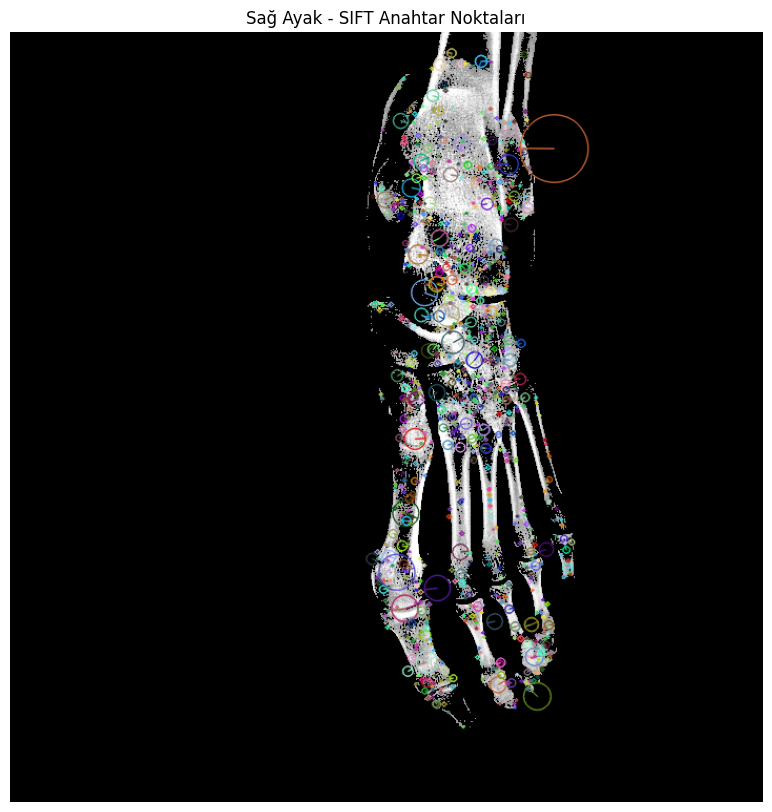


Görüntü Seti 1 İstatistikleri:
Sol Ayak:
SIFT Anahtar Nokta Sayısı: 971
HOG Özellik Boyutu: (971, 288)

Sağ Ayak:
SIFT Anahtar Nokta Sayısı: 950
HOG Özellik Boyutu: (950, 288)

İşleniyor: Görüntü Seti 2
Görüntü dosyası: C:\Users\sense\PycharmProjects\PythonProject1\img2.png
Label dosyası: C:\Users\sense\PycharmProjects\PythonProject1\label2.png

SIFT ve HOG özellikleri çıkarılıyor...

Sol ayak işleniyor...
Özellikler kaydedildi: C:\Users\sense\PycharmProjects\PythonProject1\organ_features\Görüntü Seti 2_left_foot_features.pkl

Özellik detayları:
SIFT anahtar noktaları: 867
HOG özellik boyutu: (867, 288)
LBP özellik boyutu: (867, 10)
Gradient özellik boyutu: (867, 20)
İstatistiksel özellik boyutu: (867, 10)
Doku özellik boyutu: (867, 5)
Dosya boyutu: 3700.92 KB

Sağ ayak işleniyor...
Özellikler kaydedildi: C:\Users\sense\PycharmProjects\PythonProject1\organ_features\Görüntü Seti 2_right_foot_features.pkl

Özellik detayları:
SIFT anahtar noktaları: 1000
HOG özellik boyutu: (1000, 288)
L

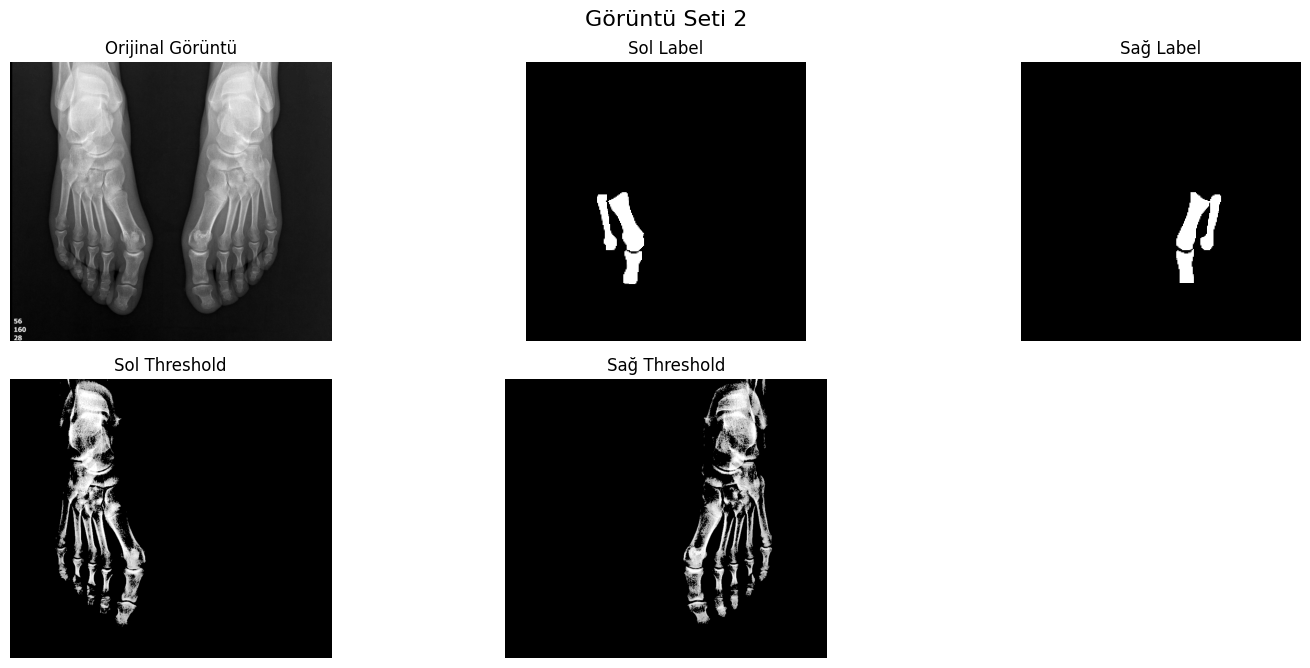

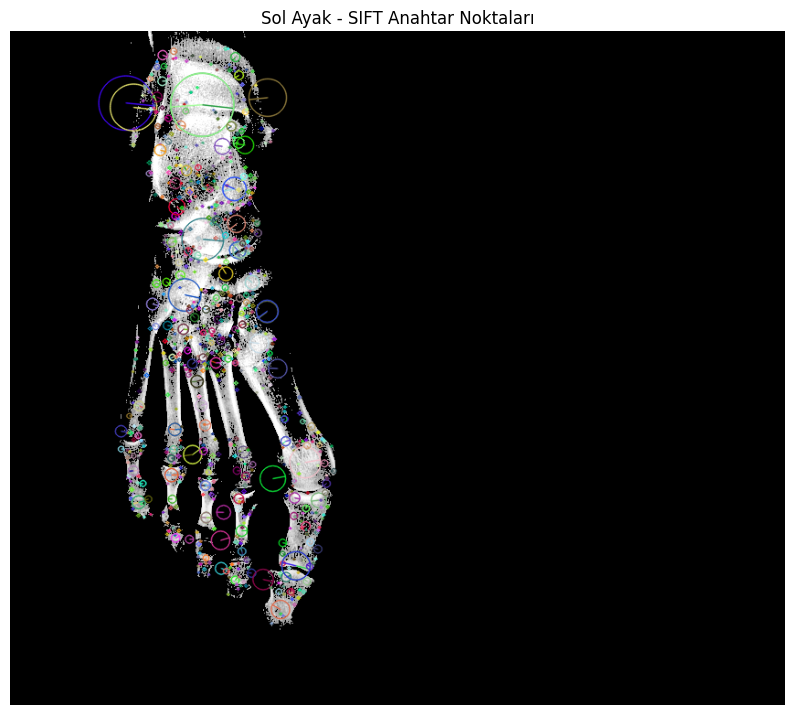

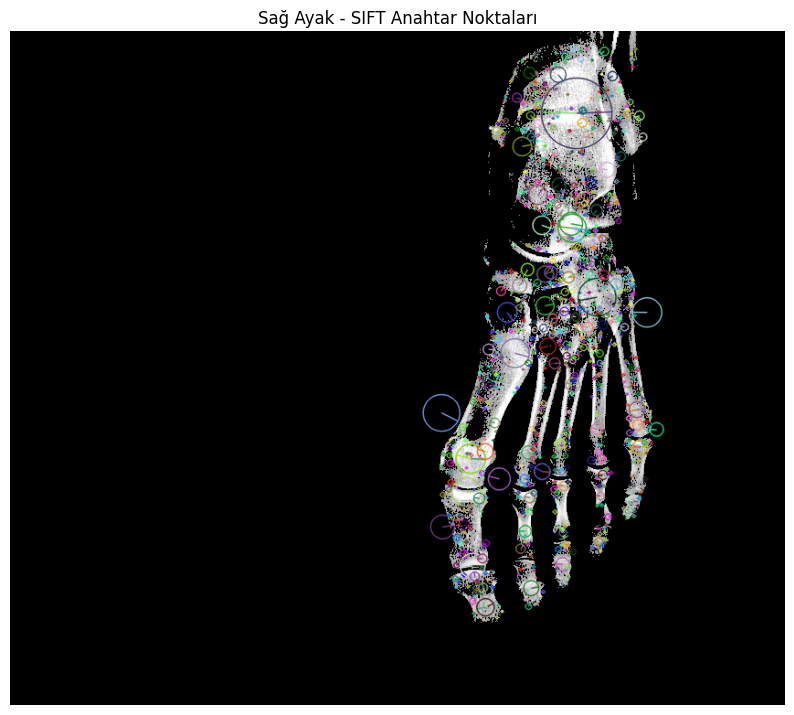


Görüntü Seti 2 İstatistikleri:
Sol Ayak:
SIFT Anahtar Nokta Sayısı: 867
HOG Özellik Boyutu: (867, 288)

Sağ Ayak:
SIFT Anahtar Nokta Sayısı: 1000
HOG Özellik Boyutu: (1000, 288)

İşleniyor: Görüntü Seti 3
Görüntü dosyası: C:\Users\sense\PycharmProjects\PythonProject1\img3.png
Label dosyası: C:\Users\sense\PycharmProjects\PythonProject1\label3.png

SIFT ve HOG özellikleri çıkarılıyor...

Sol ayak işleniyor...
Özellikler kaydedildi: C:\Users\sense\PycharmProjects\PythonProject1\organ_features\Görüntü Seti 3_left_foot_features.pkl

Özellik detayları:
SIFT anahtar noktaları: 912
HOG özellik boyutu: (912, 288)
LBP özellik boyutu: (912, 10)
Gradient özellik boyutu: (912, 20)
İstatistiksel özellik boyutu: (912, 10)
Doku özellik boyutu: (912, 5)
Dosya boyutu: 3887.03 KB

Sağ ayak işleniyor...
Özellikler kaydedildi: C:\Users\sense\PycharmProjects\PythonProject1\organ_features\Görüntü Seti 3_right_foot_features.pkl

Özellik detayları:
SIFT anahtar noktaları: 913
HOG özellik boyutu: (913, 288)
L

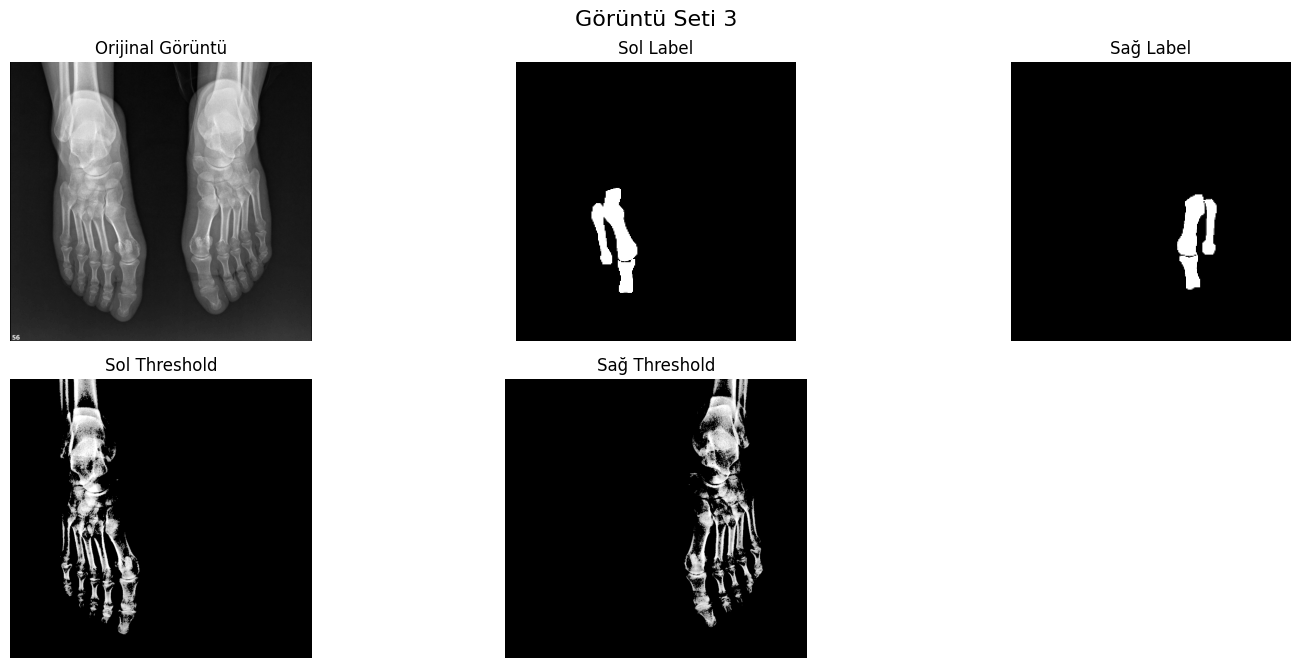

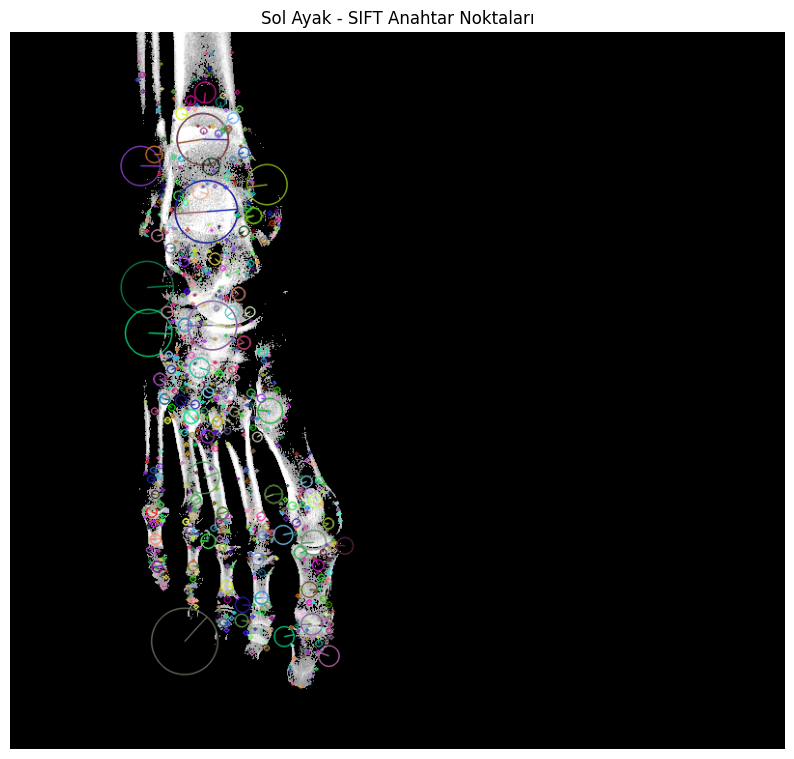

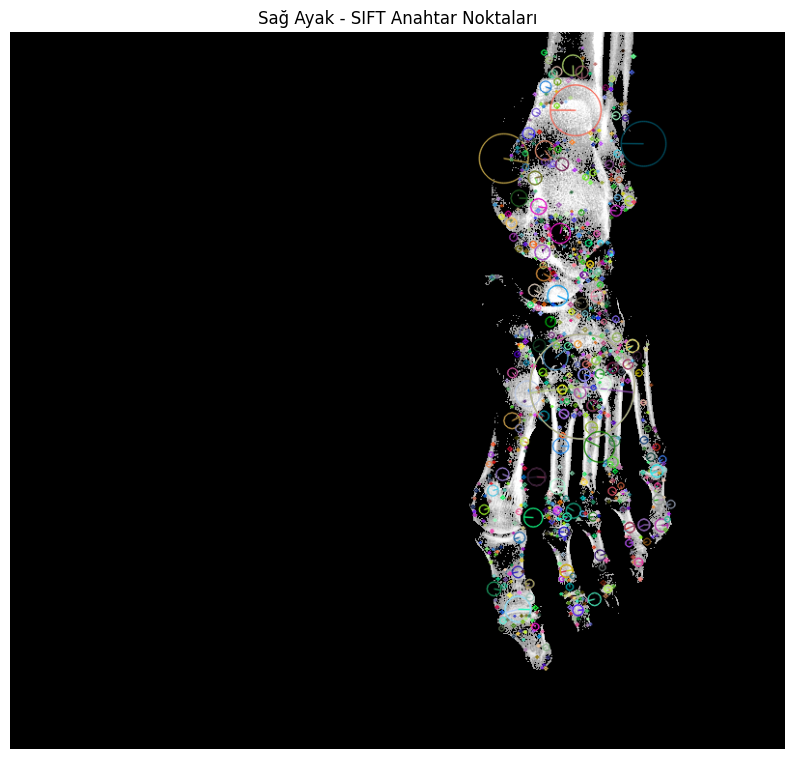


Görüntü Seti 3 İstatistikleri:
Sol Ayak:
SIFT Anahtar Nokta Sayısı: 912
HOG Özellik Boyutu: (912, 288)

Sağ Ayak:
SIFT Anahtar Nokta Sayısı: 913
HOG Özellik Boyutu: (913, 288)

Tüm işlemler tamamlandı!


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.ndimage as ndi
from skimage import filters, feature, morphology
from skimage.util import img_as_ubyte
from skimage.feature import hog
from pathlib import Path
import pickle
import os
%matplotlib inline

def apply_clahe(image):
    """Zıtlık Dönüşümü (CLAHE)"""
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    return clahe_image

def preprocess_image(image):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    enhanced = apply_clahe(gray)
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((5,5), np.uint8)
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

    return opening, enhanced

def minmax_norm(image):
    """MinMax normalizasyon"""
    image_float = image.astype(float)
    min_val = np.min(image_float)
    max_val = np.max(image_float)
    if max_val != min_val:
        normalized = (image_float - min_val) / (max_val - min_val) * 255
    else:
        normalized = image_float
    return normalized.astype(np.uint8)

def optimal_image_enhancement(image):
    """Görüntü iyileştirme"""
    normalized = minmax_norm(image)
    gaussian = cv2.GaussianBlur(normalized, (3,3), 0.3)
    enhanced_base = cv2.convertScaleAbs(gaussian, alpha=1.05, beta=0)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_clahe = clahe.apply(enhanced_base)

    _, threshold = cv2.threshold(enhanced_clahe, 140, 255, cv2.THRESH_TOZERO)

    return threshold

def find_feet_contours(processed_image):
    contours, _ = cv2.findContours(processed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    return contours

def separate_feet(image, processed, enhanced):
    contours = find_feet_contours(processed)

    if len(contours) == 2:
        mask1 = np.zeros_like(processed)
        mask2 = np.zeros_like(processed)

        cv2.drawContours(mask1, [contours[0]], -1, 255, -1)
        cv2.drawContours(mask2, [contours[1]], -1, 255, -1)

        foot1 = cv2.bitwise_and(enhanced, enhanced, mask=mask1)
        foot2 = cv2.bitwise_and(enhanced, enhanced, mask=mask2)

        M1 = cv2.moments(contours[0])
        M2 = cv2.moments(contours[1])

        if M1['m00'] != 0 and M2['m00'] != 0:
            cx1 = int(M1['m10']/M1['m00'])
            cx2 = int(M2['m10']/M2['m00'])

            if cx1 < cx2:
                left_foot = foot1
                right_foot = foot2
                left_mask = mask1
                right_mask = mask2
            else:
                left_foot = foot2
                right_foot = foot1
                left_mask = mask2
                right_mask = mask1

            return left_foot, right_foot, left_mask, right_mask

    height, width = enhanced.shape[:2]
    left_foot = enhanced[:, :width//2]
    right_foot = enhanced[:, width//2:]
    left_mask = np.zeros_like(processed)
    right_mask = np.zeros_like(processed)
    left_mask[:, :width//2] = 255
    right_mask[:, width//2:] = 255

    return left_foot, right_foot, left_mask, right_mask

def detect_sift_keypoints(image):
    """SIFT anahtar noktalarını tespit et"""
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

def extract_patches(image, keypoints, patch_size=32):
    """Anahtar noktalar etrafından patch'leri çıkar"""
    patches = []
    valid_keypoints = []
    h, w = image.shape

    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        half_size = patch_size // 2

        if (x - half_size >= 0 and x + half_size < w and
            y - half_size >= 0 and y + half_size < h):

            patch = image[y-half_size:y+half_size,
                         x-half_size:x+half_size]
            patches.append(patch)
            valid_keypoints.append(kp)

    return patches, valid_keypoints

def compute_hog_features(patches):
    """Patch'ler için HOG özelliklerini hesapla"""
    hog_features = []

    for patch in patches:
        fd = hog(patch, orientations=8, pixels_per_cell=(8, 8),
                cells_per_block=(2, 2), visualize=False)
        hog_features.append(fd)

    return np.array(hog_features)

def keypoint_to_dict(keypoint):
    """CV2 KeyPoint nesnesini sözlüğe dönüştür"""
    return {
        'pt': keypoint.pt,
        'size': keypoint.size,
        'angle': keypoint.angle,
        'response': keypoint.response,
        'octave': keypoint.octave,
        'class_id': keypoint.class_id
    }

def dict_to_keypoint(d):
    """Sözlükten CV2 KeyPoint nesnesi oluştur"""
    return cv2.KeyPoint(
        x=d['pt'][0],
        y=d['pt'][1],
        size=d['size'],
        angle=d['angle'],
        response=d['response'],
        octave=d['octave'],
        class_id=d['class_id']
    )

def save_features(features, filename):
    """Özellikleri HDD'ye kaydet"""
    with open(filename, 'wb') as f:
        pickle.dump(features, f)
    print(f"Özellikler kaydedildi: {os.path.abspath(filename)}")

def load_features(filename):
    """Kaydedilmiş özellikleri yükle ve KeyPoint nesnelerini geri dönüştür"""
    print(f"Özellikler yükleniyor: {os.path.abspath(filename)}")
    with open(filename, 'rb') as f:
        data = pickle.load(f)

    if 'keypoints_dict' in data:
        data['keypoints'] = [dict_to_keypoint(d) for d in data['keypoints_dict']]
        del data['keypoints_dict']

    return data

def process_and_save_features(image, title, output_dir):
    """Görüntüyü işle ve özelliklerini detaylı şekilde kaydet"""
    # SIFT uygula
    keypoints, descriptors = detect_sift_keypoints(image)

    # Patch'leri çıkar
    patches, valid_keypoints = extract_patches(image, keypoints)

    if patches:
        # HOG özelliklerini hesapla
        hog_features = compute_hog_features(patches)

        # LBP özelliklerini hesapla
        lbp_features = []
        for patch in patches:
            lbp = feature.local_binary_pattern(patch, P=8, R=1, method='uniform')
            hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), density=True)
            lbp_features.append(hist)
        lbp_features = np.array(lbp_features)

        # Gradient özellikleri
        gradient_features = []
        for patch in patches:
            gx = cv2.Sobel(patch, cv2.CV_64F, 1, 0, ksize=3)
            gy = cv2.Sobel(patch, cv2.CV_64F, 0, 1, ksize=3)
            mag = np.sqrt(gx**2 + gy**2)
            ang = np.arctan2(gy, gx)
            hist_mag, _ = np.histogram(mag.ravel(), bins=10, density=True)
            hist_ang, _ = np.histogram(ang.ravel(), bins=10, density=True)
            gradient_features.append(np.concatenate([hist_mag, hist_ang]))
        gradient_features = np.array(gradient_features)

        # İstatistiksel özellikler
        statistical_features = []
        for patch in patches:
            stats = [
                np.mean(patch),
                np.std(patch),
                np.median(patch),
                np.percentile(patch, 25),
                np.percentile(patch, 75),
                np.min(patch),
                np.max(patch),
                np.var(patch),
                np.sum(patch),
                filters.threshold_otsu(patch)
            ]
            statistical_features.append(stats)
        statistical_features = np.array(statistical_features)

        # Doku özellikleri
        texture_features = []
        for patch in patches:
            glcm = feature.graycomatrix(patch.astype(np.uint8),
                                      distances=[1],
                                      angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                      levels=256,
                                      symmetric=True,
                                      normed=True)
            contrast = feature.graycoprops(glcm, 'contrast').mean()
            dissimilarity = feature.graycoprops(glcm, 'dissimilarity').mean()
            homogeneity = feature.graycoprops(glcm, 'homogeneity').mean()
            energy = feature.graycoprops(glcm, 'energy').mean()
            correlation = feature.graycoprops(glcm, 'correlation').mean()
            texture_features.append([contrast, dissimilarity, homogeneity, energy, correlation])
        texture_features = np.array(texture_features)

        # Keypoint konumları ve özellikleri
        keypoint_locations = np.array([[kp.pt[0], kp.pt[1]] for kp in valid_keypoints])
        keypoint_properties = np.array([[kp.size, kp.angle, kp.response] for kp in valid_keypoints])

        # KeyPoint nesnelerini sözlüğe dönüştür
        keypoints_dict = [keypoint_to_dict(kp) for kp in valid_keypoints]

        # Tüm özellikleri bir araya getir
        feature_data = {
            'keypoints_dict': keypoints_dict,
            'keypoint_locations': keypoint_locations,
            'keypoint_properties': keypoint_properties,
            'sift_descriptors': descriptors,
            'patches': patches,
            'patch_locations': keypoint_locations,  # patch merkezleri
            'hog_features': hog_features,
            'lbp_features': lbp_features,
            'gradient_features': gradient_features,
            'statistical_features': statistical_features,
            'texture_features': texture_features,
            'feature_metadata': {
                'patch_size': 32,
                'hog_orientations': 8,
                'hog_pixels_per_cell': (8, 8),
                'hog_cells_per_block': (2, 2),
                'lbp_points': 8,
                'lbp_radius': 1,
                'gradient_bins': 10,
                'statistical_measures': [
                    'mean', 'std', 'median', 'q1', 'q3',
                    'min', 'max', 'variance', 'sum', 'otsu'
                ],
                'texture_measures': [
                    'contrast', 'dissimilarity', 'homogeneity',
                    'energy', 'correlation'
                ]
            },
            'image_info': {
                'shape': image.shape,
                'mean': float(np.mean(image)),
                'std': float(np.std(image)),
                'min': float(np.min(image)),
                'max': float(np.max(image))
            }
        }

        # Sonuçları kaydet
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)
        save_path = output_path / f'{title}_features.pkl'

        save_features(feature_data, save_path)
        print(f"\nÖzellik detayları:")
        print(f"SIFT anahtar noktaları: {len(valid_keypoints)}")
        print(f"HOG özellik boyutu: {hog_features.shape}")
        print(f"LBP özellik boyutu: {lbp_features.shape}")
        print(f"Gradient özellik boyutu: {gradient_features.shape}")
        print(f"İstatistiksel özellik boyutu: {statistical_features.shape}")
        print(f"Doku özellik boyutu: {texture_features.shape}")
        print(f"Dosya boyutu: {os.path.getsize(save_path) / 1024:.2f} KB")

        return feature_data
    return None

def visualize_keypoints(image, keypoints, title):
    """Anahtar noktaları görselleştir"""
    img_with_kp = cv2.drawKeypoints(image, keypoints, None,
                                   flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_with_kp, cmap='gray')
    plt.title(f'{title} - SIFT Anahtar Noktaları')
    plt.axis('off')
    plt.show()

def show_comparison(img_path, label_path, title, output_dir='features'):
    """Görüntü, label ve threshold sonuçlarını göster ve özellikleri kaydet"""
    print(f"\n{'='*50}")
    print(f"İşleniyor: {title}")
    print(f"{'='*50}")

    # Görüntüleri oku
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

    print(f"Görüntü dosyası: {os.path.abspath(img_path)}")
    print(f"Label dosyası: {os.path.abspath(label_path)}")

    # Görüntüleri işle
    processed_img, enhanced_img = preprocess_image(img)
    processed_label, enhanced_label = preprocess_image(label)

    # Ayakları ayır
    left_img, right_img, left_mask_img, right_mask_img = separate_feet(img, processed_img, enhanced_img)
    left_label, right_label, left_mask_label, right_mask_label = separate_feet(label, processed_label, enhanced_label)

    # Threshold uygula
    left_threshold = optimal_image_enhancement(left_img)
    right_threshold = optimal_image_enhancement(right_img)

    # SIFT ve HOG işlemleri
    print(f"\nSIFT ve HOG özellikleri çıkarılıyor...")

    # Sol ayak için özellik çıkarma
    print("\nSol ayak işleniyor...")
    left_features = process_and_save_features(
        left_threshold,
        f'{title}_left_foot',
        output_dir
    )

    # Sağ ayak için özellik çıkarma
    print("\nSağ ayak işleniyor...")
    right_features = process_and_save_features(
        right_threshold,
        f'{title}_right_foot',
        output_dir
    )

    # Görselleştirme
    plt.figure(figsize=(15, 10))
    plt.suptitle(title, fontsize=16)

    # Orijinal görüntü
    plt.subplot(331)
    plt.imshow(img, cmap='gray')
    plt.title('Orijinal Görüntü')
    plt.axis('off')

    # Ayrılmış labeller
    plt.subplot(332)
    plt.imshow(left_label, cmap='gray')
    plt.title('Sol Label')
    plt.axis('off')

    plt.subplot(333)
    plt.imshow(right_label, cmap='gray')
    plt.title('Sağ Label')
    plt.axis('off')

    # Threshold sonuçları
    plt.subplot(334)
    plt.imshow(left_threshold, cmap='gray')
    plt.title('Sol Threshold')
    plt.axis('off')

    plt.subplot(335)
    plt.imshow(right_threshold, cmap='gray')
    plt.title('Sağ Threshold')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # SIFT sonuçlarını ayrı göster
    if left_features:
        # KeyPoint nesnelerini oluştur
        left_keypoints = [dict_to_keypoint(kp) for kp in left_features['keypoints_dict']]
        visualize_keypoints(left_threshold, left_keypoints, 'Sol Ayak')

    if right_features:
        # KeyPoint nesnelerini oluştur
        right_keypoints = [dict_to_keypoint(kp) for kp in right_features['keypoints_dict']]
        visualize_keypoints(right_threshold, right_keypoints, 'Sağ Ayak')

    # İstatistikler
    print(f"\n{title} İstatistikleri:")
    print("Sol Ayak:")
    if left_features:
        print(f"SIFT Anahtar Nokta Sayısı: {len(left_features['keypoints_dict'])}")
        print(f"HOG Özellik Boyutu: {left_features['hog_features'].shape}")

    print("\nSağ Ayak:")
    if right_features:
        print(f"SIFT Anahtar Nokta Sayısı: {len(right_features['keypoints_dict'])}")
        print(f"HOG Özellik Boyutu: {right_features['hog_features'].shape}")

# Ana çalıştırma kodu
output_directory = 'organ_features'
print(f"\nÖzellikler şu dizine kaydedilecek: {os.path.abspath(output_directory)}")

show_comparison('img1.png', 'label1.png', 'Görüntü Seti 1', output_directory)
show_comparison('img2.png', 'label2.png', 'Görüntü Seti 2', output_directory)
show_comparison('img3.png', 'label3.png', 'Görüntü Seti 3', output_directory)

print("\nTüm işlemler tamamlandı!")

1 adım...



Özellikler şu dizine kaydedilecek: C:\Users\sense\PycharmProjects\PythonProject1\organ_features_detailed

İşleniyor: Görüntü Seti 1
Görüntü dosyası: C:\Users\sense\PycharmProjects\PythonProject1\img1.png
Label dosyası: C:\Users\sense\PycharmProjects\PythonProject1\label1.png

Organ özellikleri çıkarılıyor...

Sol ayak işleniyor...

Organ özellikleri kaydedildi:
Konum: C:\Users\sense\PycharmProjects\PythonProject1\organ_features_detailed\Görüntü Seti 1_left_foot_features.pkl

Özellik boyutları:
HOG: 6516
Gabor: 224
Wavelet: 36
Zernike: 25
LBP histogram: 26

Dosya boyutu: 64.10 KB


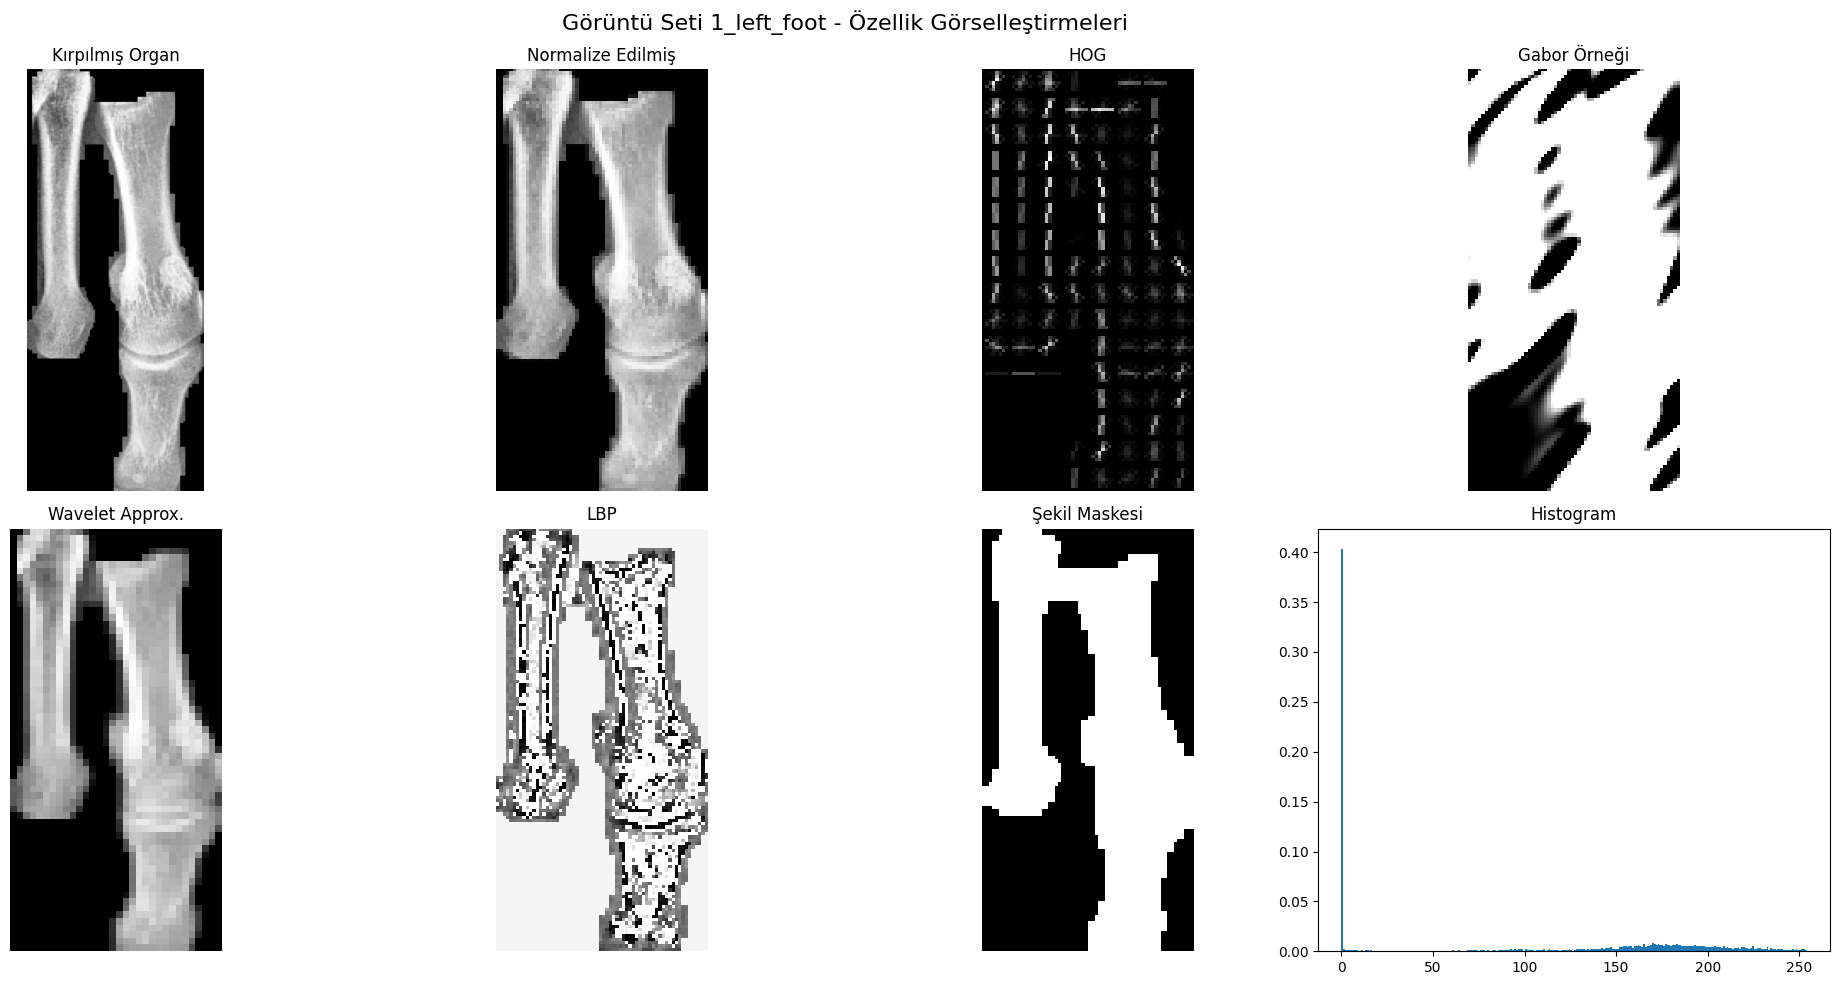


Sağ ayak işleniyor...

Organ özellikleri kaydedildi:
Konum: C:\Users\sense\PycharmProjects\PythonProject1\organ_features_detailed\Görüntü Seti 1_right_foot_features.pkl

Özellik boyutları:
HOG: 6516
Gabor: 224
Wavelet: 36
Zernike: 25
LBP histogram: 26

Dosya boyutu: 63.71 KB


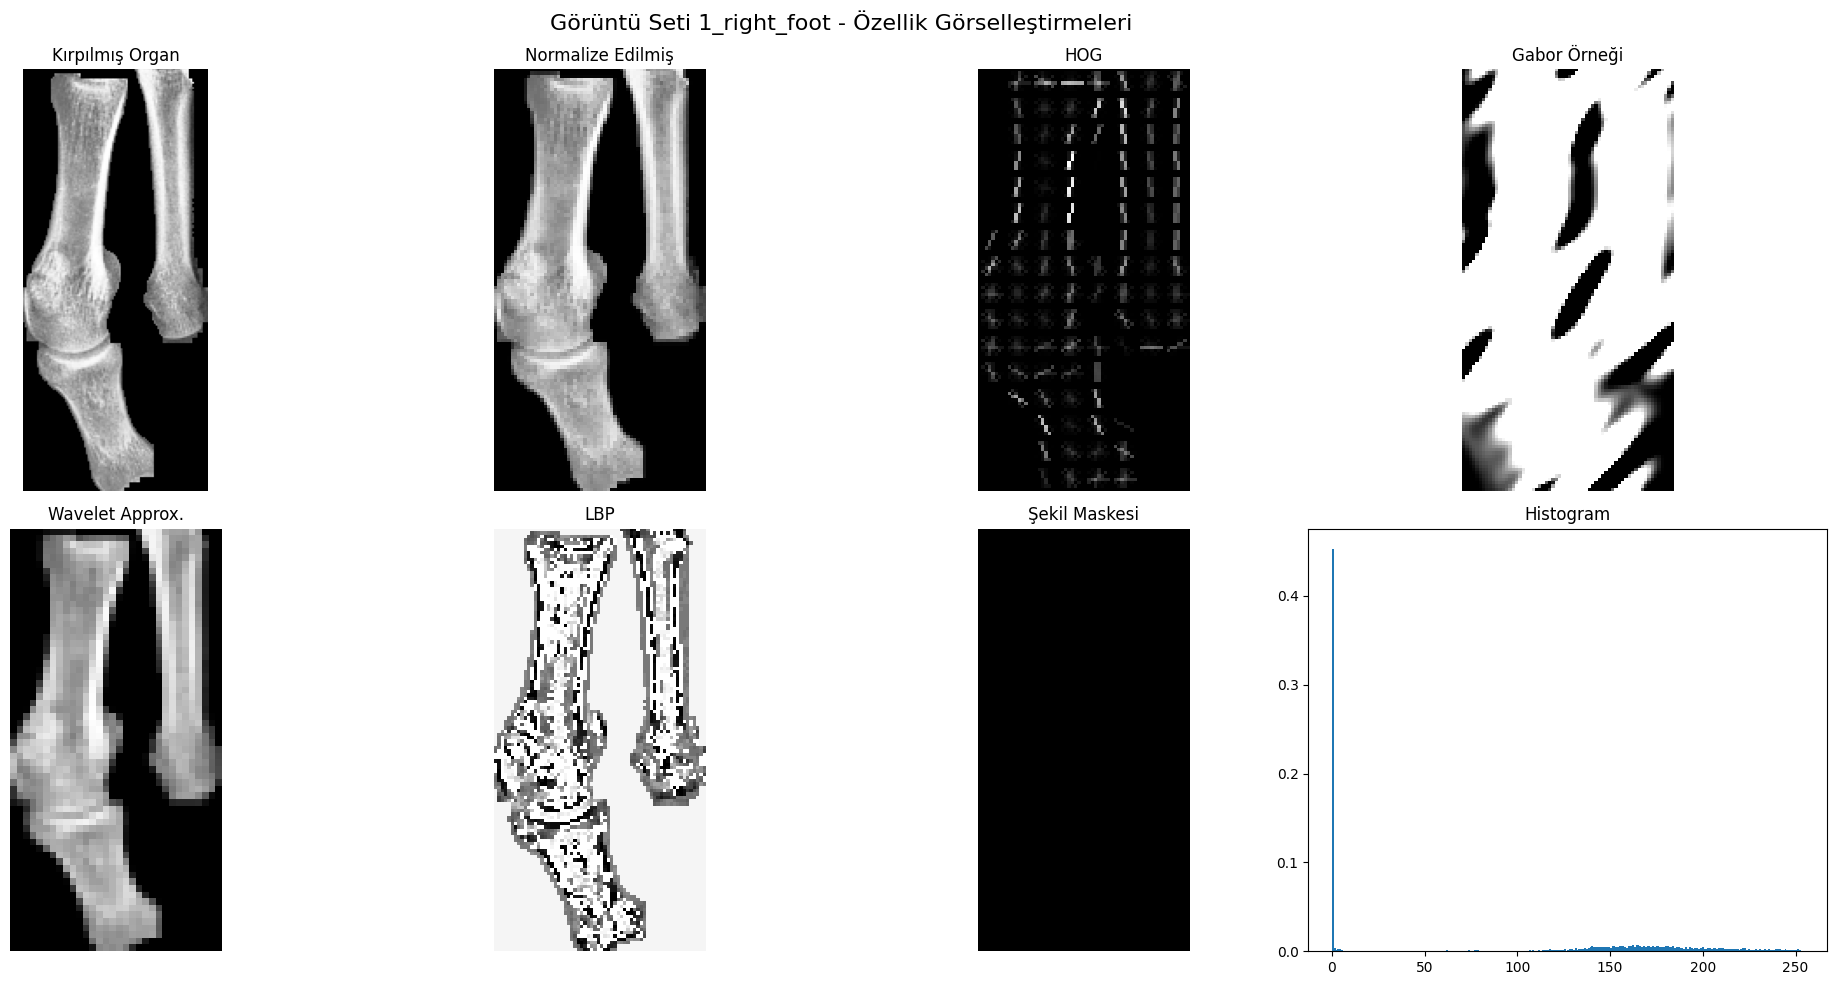

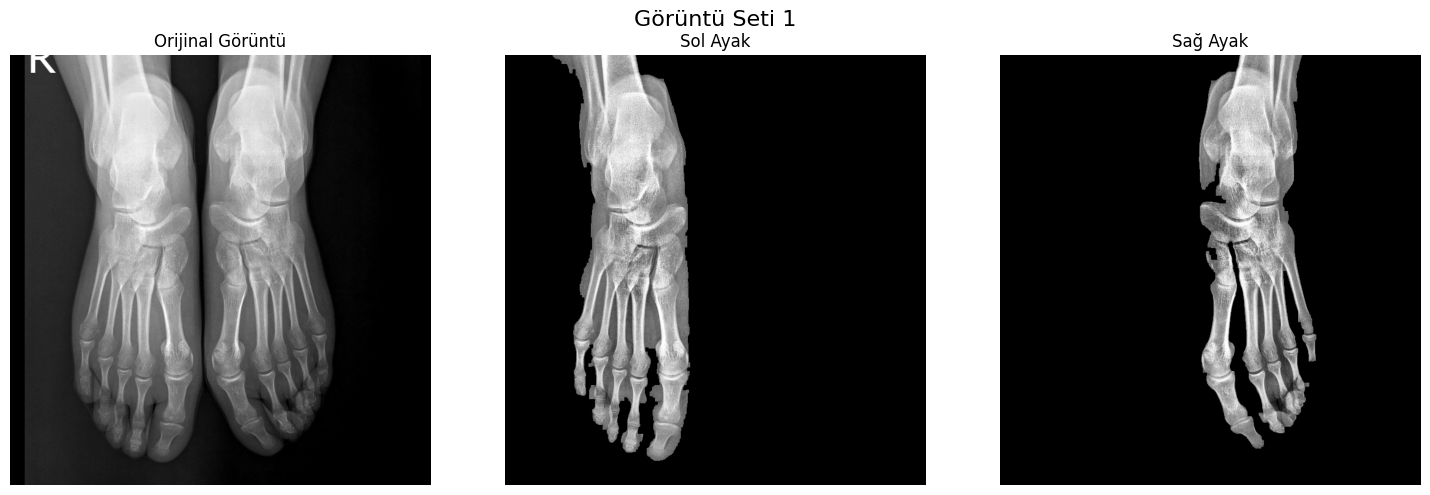


İşleniyor: Görüntü Seti 2
Görüntü dosyası: C:\Users\sense\PycharmProjects\PythonProject1\img2.png
Label dosyası: C:\Users\sense\PycharmProjects\PythonProject1\label2.png

Organ özellikleri çıkarılıyor...

Sol ayak işleniyor...

Organ özellikleri kaydedildi:
Konum: C:\Users\sense\PycharmProjects\PythonProject1\organ_features_detailed\Görüntü Seti 2_left_foot_features.pkl

Özellik boyutları:
HOG: 6516
Gabor: 224
Wavelet: 36
Zernike: 25
LBP histogram: 26

Dosya boyutu: 64.10 KB


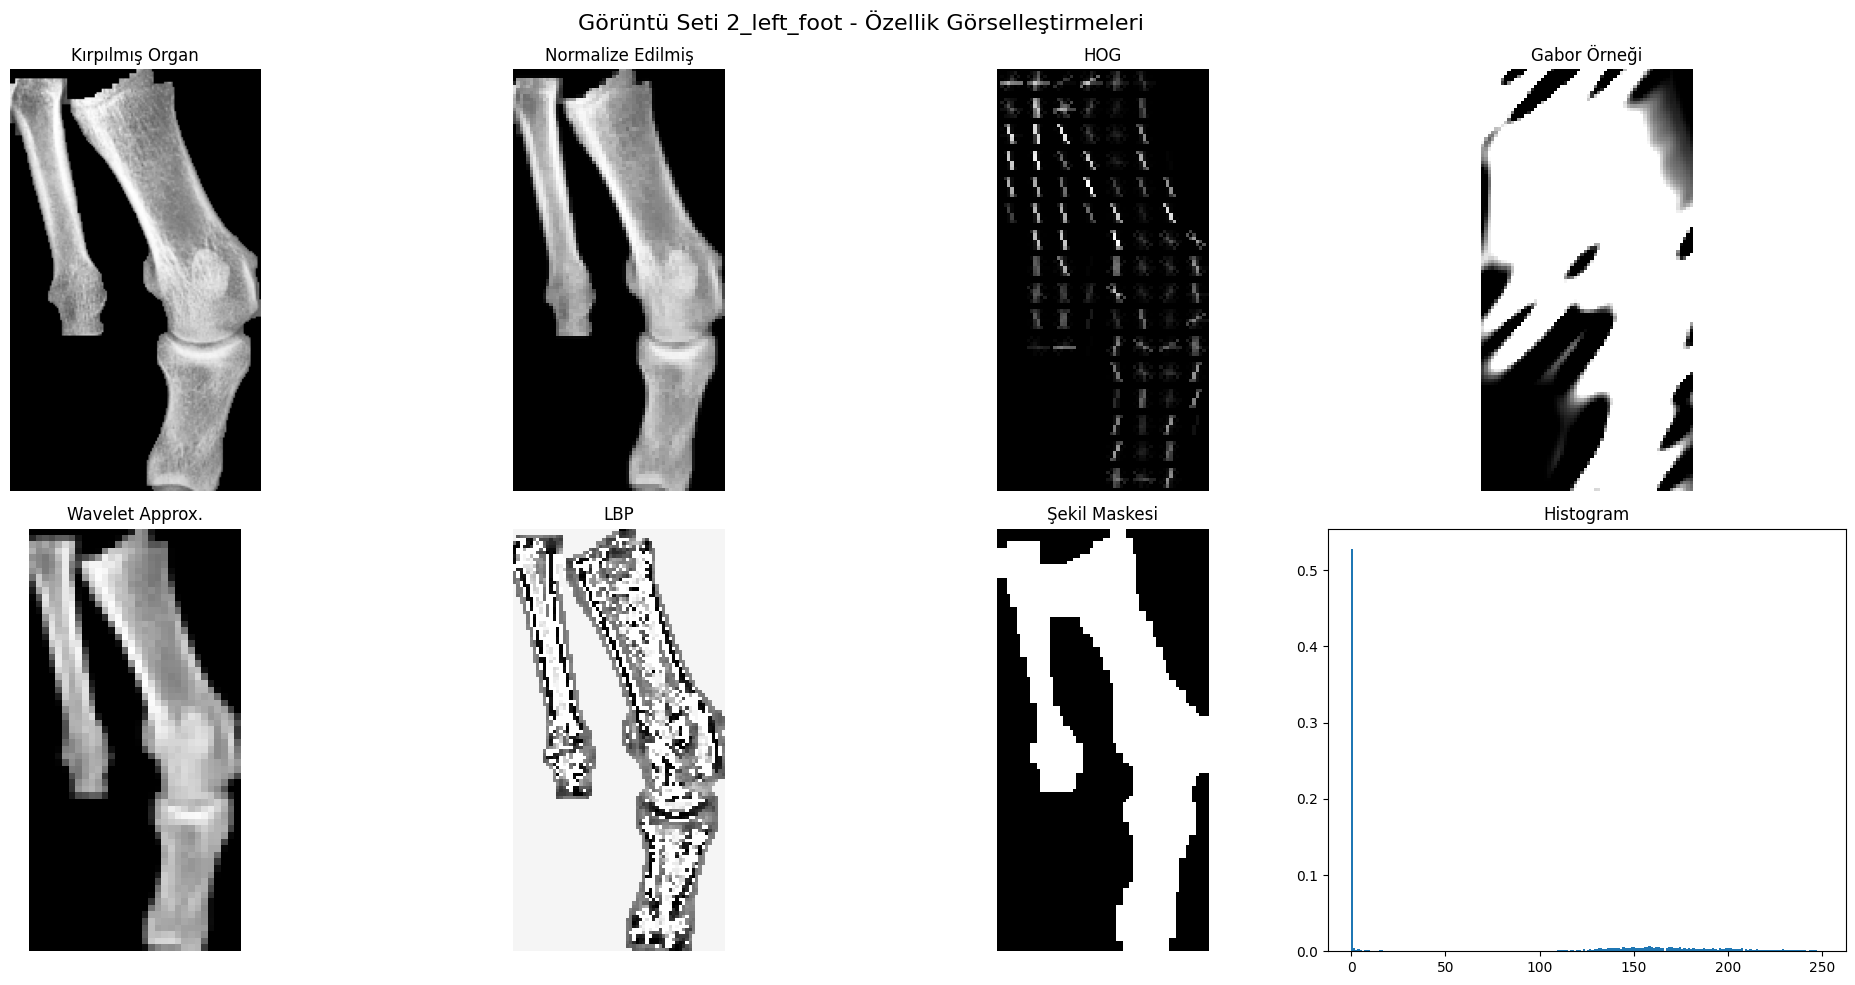


Sağ ayak işleniyor...

Organ özellikleri kaydedildi:
Konum: C:\Users\sense\PycharmProjects\PythonProject1\organ_features_detailed\Görüntü Seti 2_right_foot_features.pkl

Özellik boyutları:
HOG: 6516
Gabor: 224
Wavelet: 36
Zernike: 25
LBP histogram: 26

Dosya boyutu: 64.10 KB


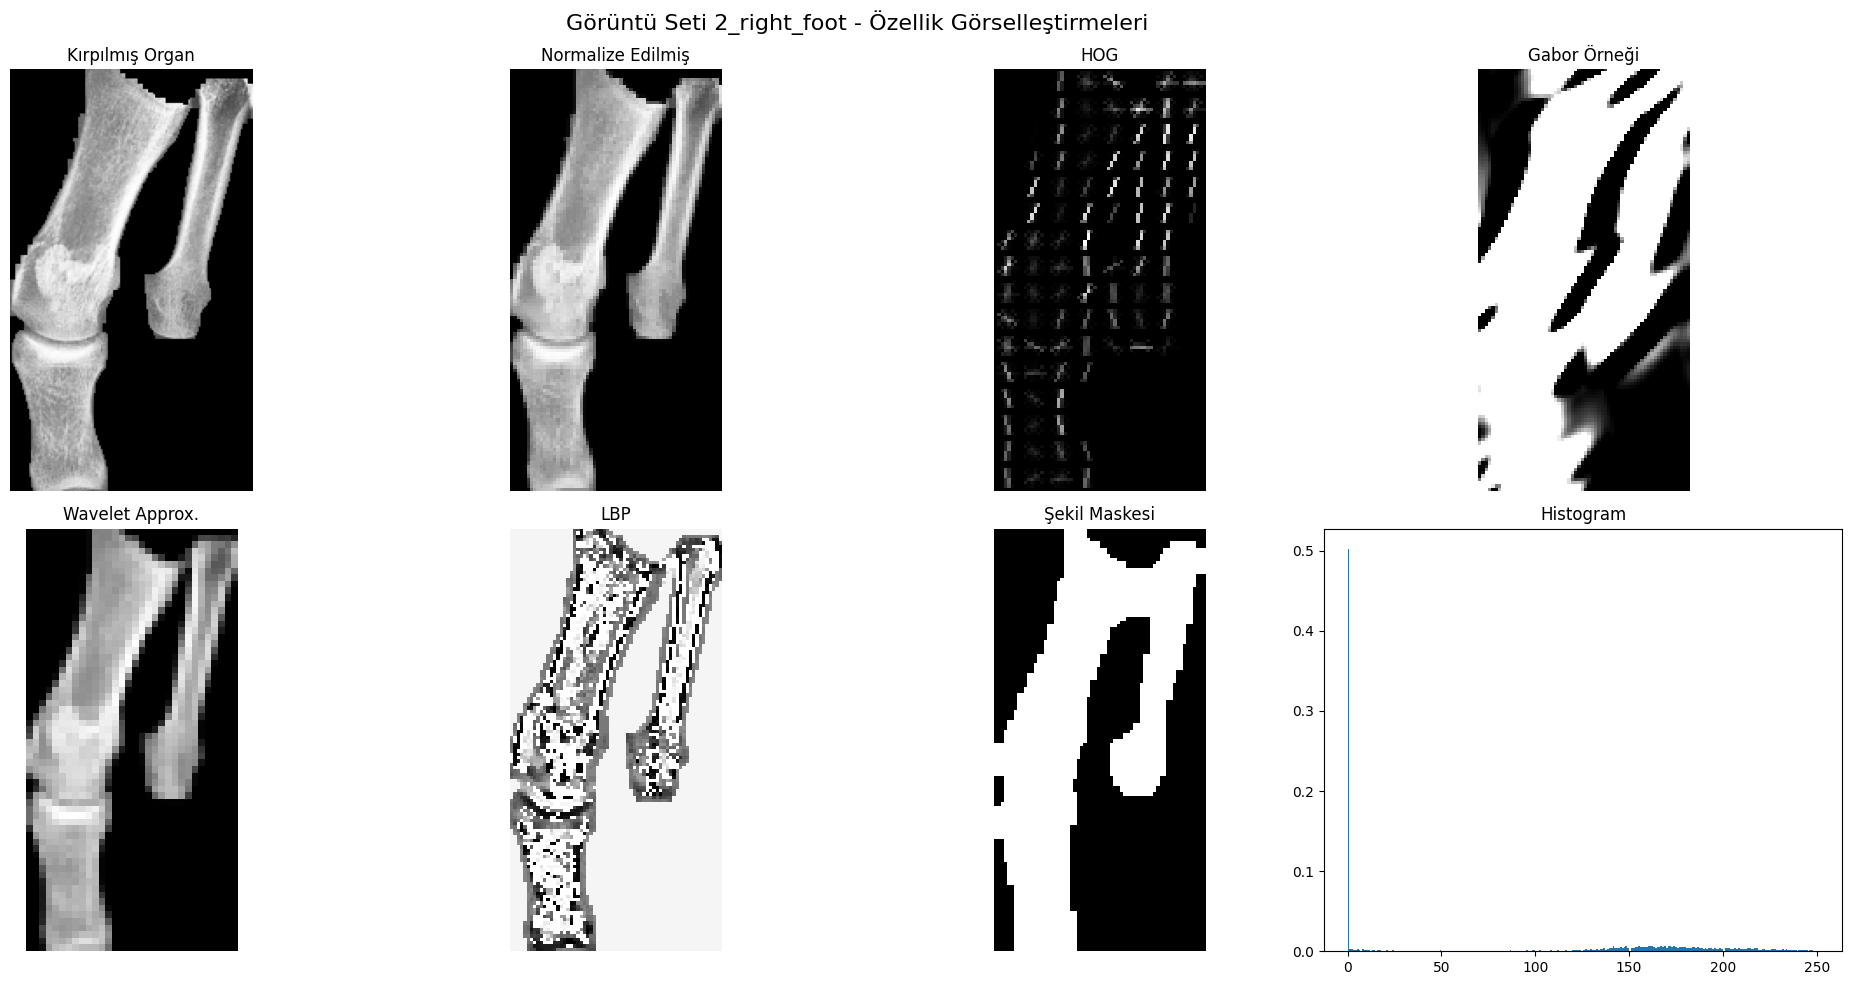

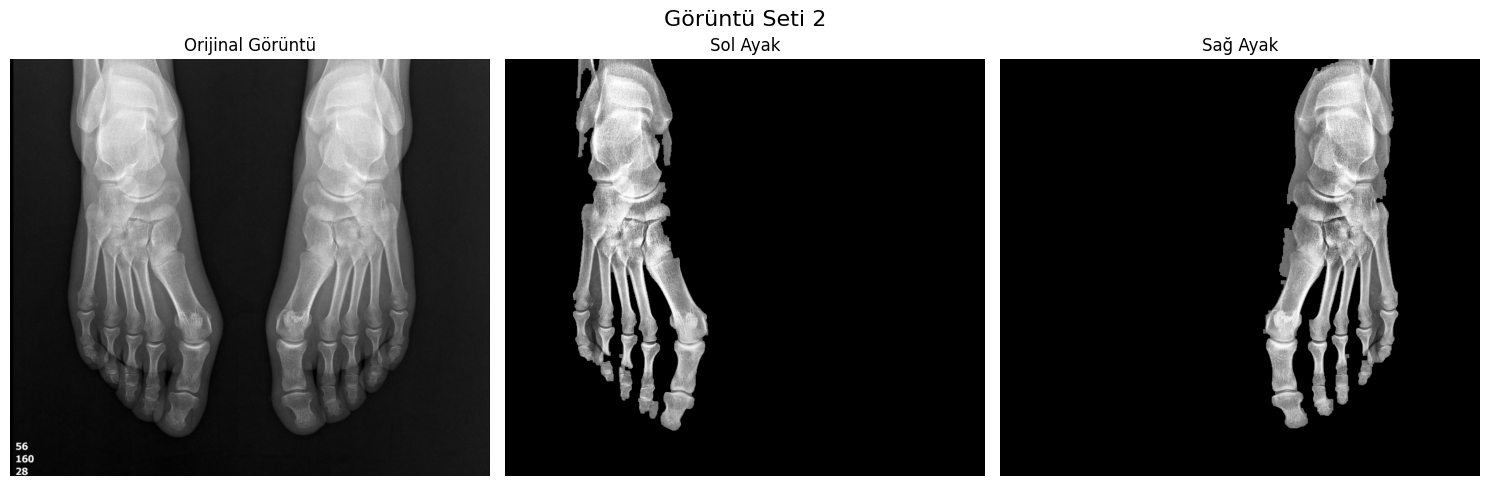


İşleniyor: Görüntü Seti 3
Görüntü dosyası: C:\Users\sense\PycharmProjects\PythonProject1\img3.png
Label dosyası: C:\Users\sense\PycharmProjects\PythonProject1\label3.png

Organ özellikleri çıkarılıyor...

Sol ayak işleniyor...

Organ özellikleri kaydedildi:
Konum: C:\Users\sense\PycharmProjects\PythonProject1\organ_features_detailed\Görüntü Seti 3_left_foot_features.pkl

Özellik boyutları:
HOG: 6516
Gabor: 224
Wavelet: 36
Zernike: 25
LBP histogram: 26

Dosya boyutu: 64.11 KB


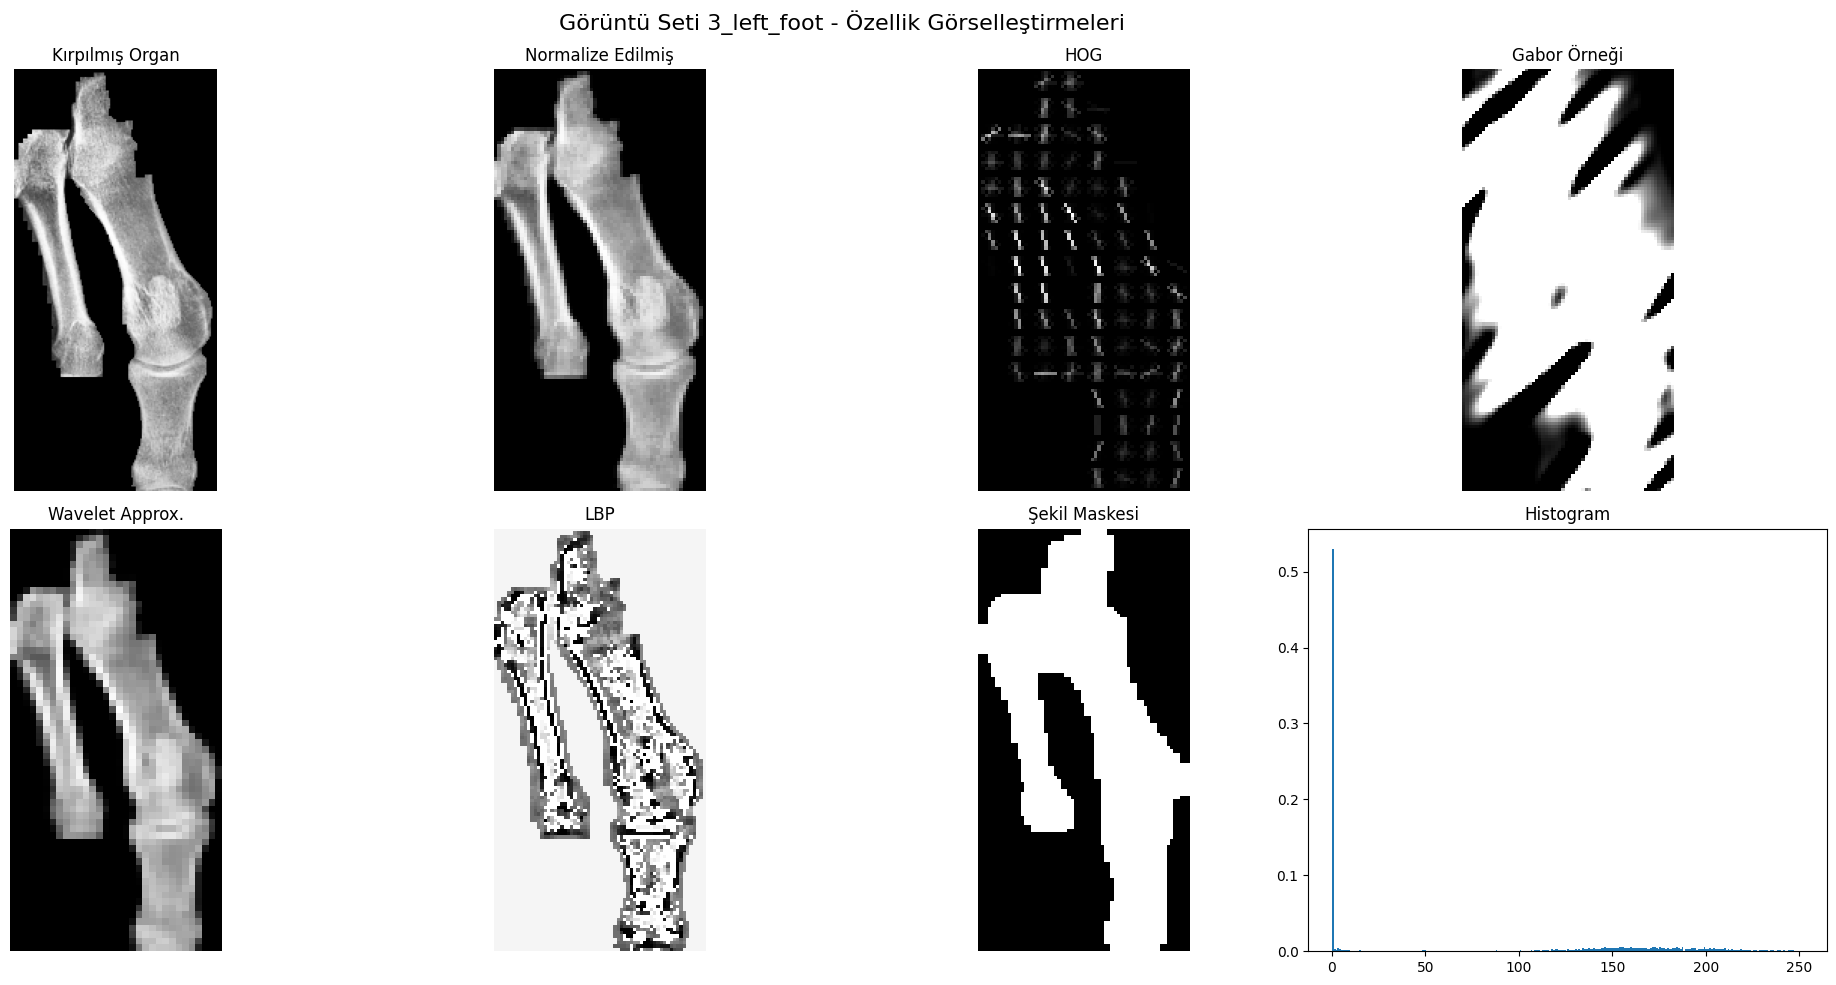


Sağ ayak işleniyor...

Organ özellikleri kaydedildi:
Konum: C:\Users\sense\PycharmProjects\PythonProject1\organ_features_detailed\Görüntü Seti 3_right_foot_features.pkl

Özellik boyutları:
HOG: 6516
Gabor: 224
Wavelet: 36
Zernike: 25
LBP histogram: 26

Dosya boyutu: 63.71 KB


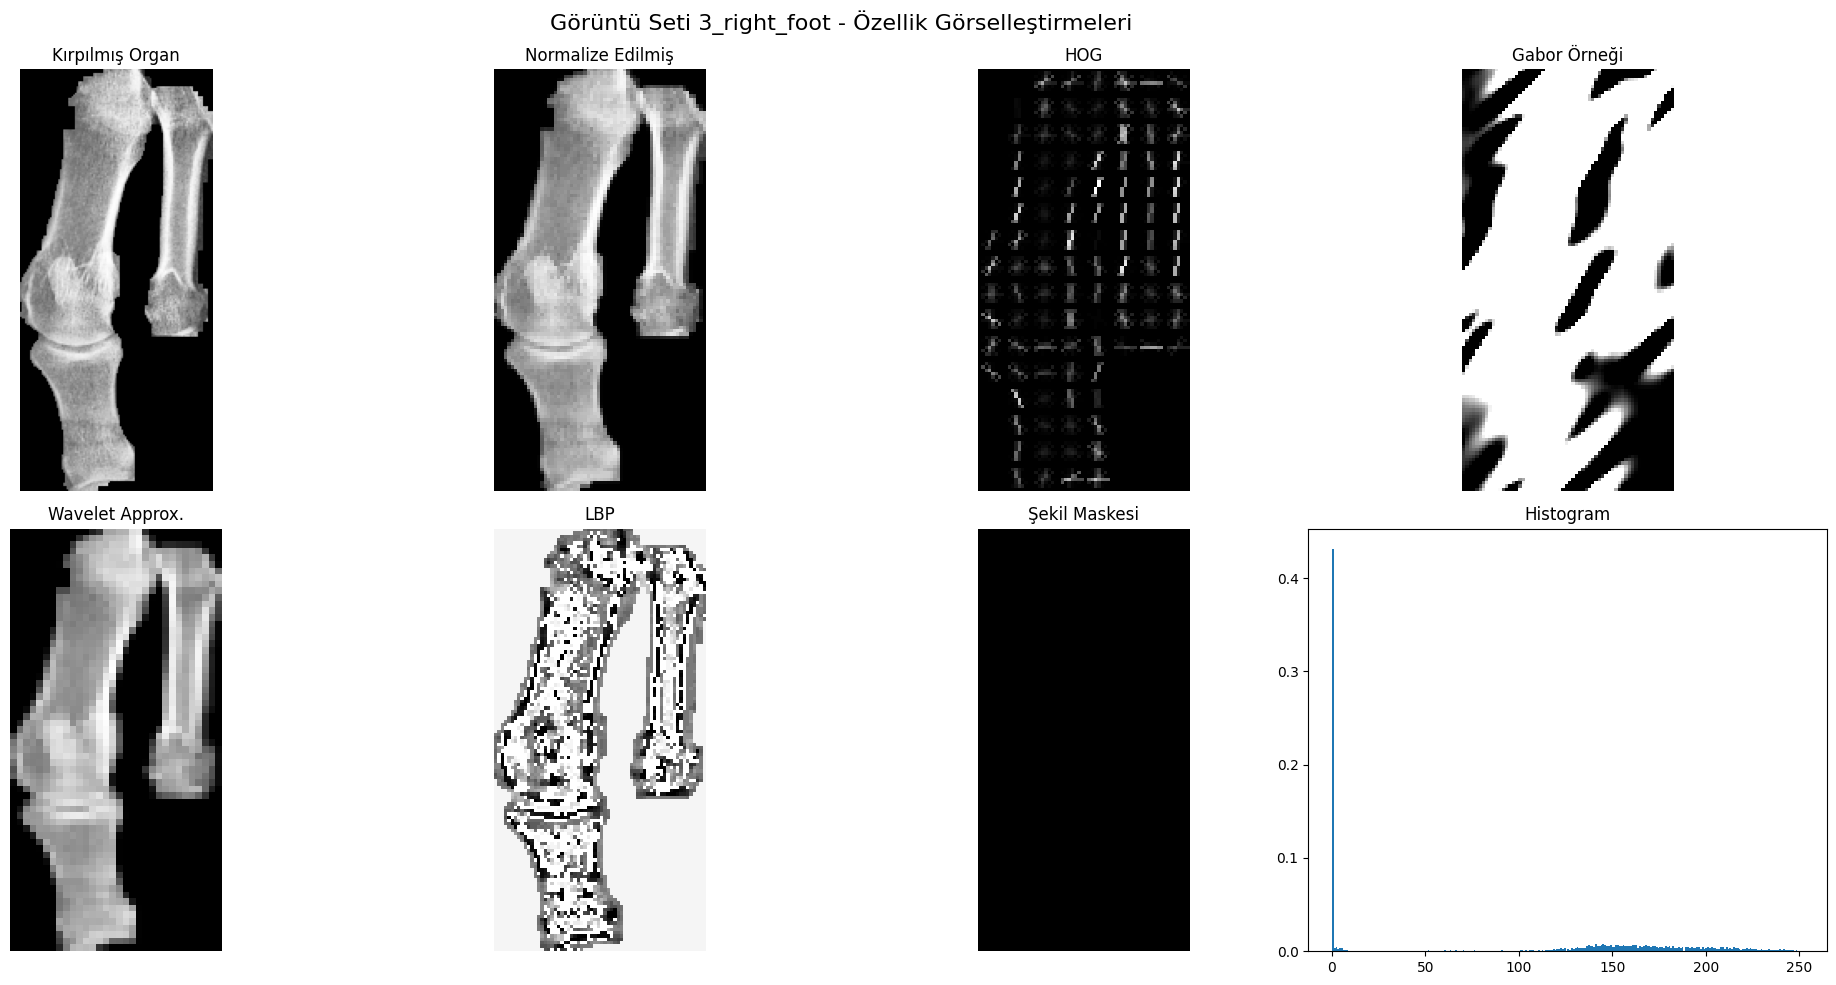

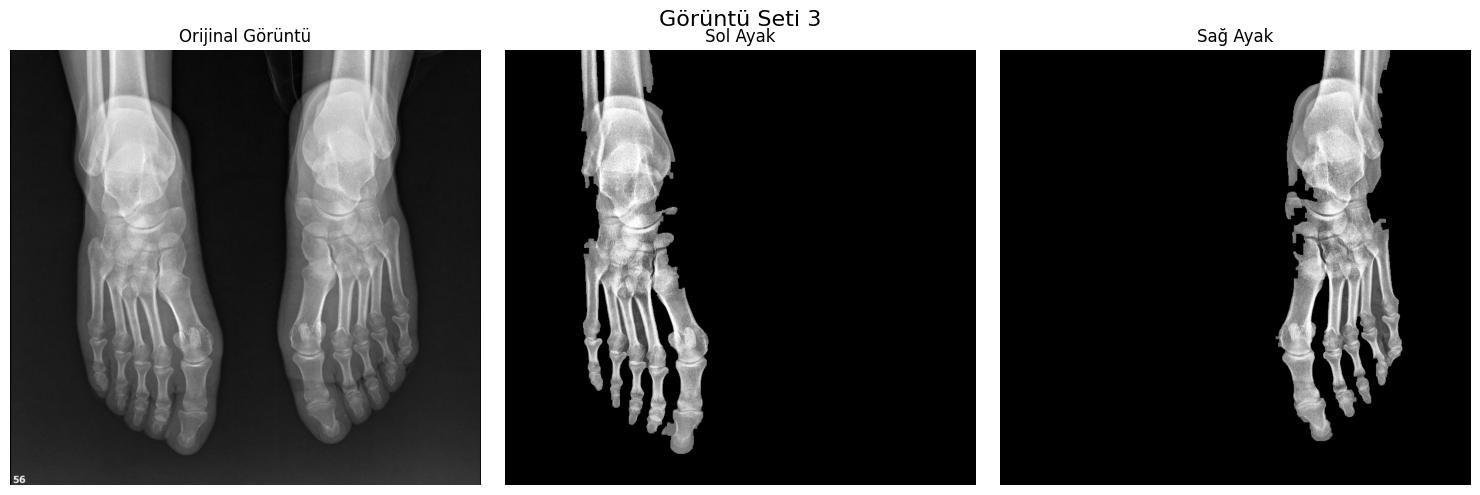


Tüm işlemler tamamlandı!


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.ndimage as ndi
from skimage import filters, feature, morphology
from skimage.util import img_as_ubyte
from skimage.feature import hog
from skimage.transform import resize
from scipy.stats import skew, kurtosis
import mahotas
import pywt
from pathlib import Path
import pickle
import os
%matplotlib inline

def apply_clahe(image):
    """Zıtlık Dönüşümü (CLAHE)"""
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    return clahe_image

def preprocess_image(image):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    enhanced = apply_clahe(gray)
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((5,5), np.uint8)
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

    return opening, enhanced

def minmax_norm(image):
    """MinMax normalizasyon"""
    image_float = image.astype(float)
    min_val = np.min(image_float)
    max_val = np.max(image_float)
    if max_val != min_val:
        normalized = (image_float - min_val) / (max_val - min_val) * 255
    else:
        normalized = image_float
    return normalized.astype(np.uint8)

def optimal_image_enhancement(image):
    """Görüntü iyileştirme"""
    normalized = minmax_norm(image)
    gaussian = cv2.GaussianBlur(normalized, (3,3), 0.3)
    enhanced_base = cv2.convertScaleAbs(gaussian, alpha=1.05, beta=0)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_clahe = clahe.apply(enhanced_base)

    _, threshold = cv2.threshold(enhanced_clahe, 140, 255, cv2.THRESH_TOZERO)

    return threshold

def find_feet_contours(processed_image):
    contours, _ = cv2.findContours(processed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    return contours

def separate_feet(image, processed, enhanced):
    contours = find_feet_contours(processed)

    if len(contours) == 2:
        mask1 = np.zeros_like(processed)
        mask2 = np.zeros_like(processed)

        cv2.drawContours(mask1, [contours[0]], -1, 255, -1)
        cv2.drawContours(mask2, [contours[1]], -1, 255, -1)

        foot1 = cv2.bitwise_and(enhanced, enhanced, mask=mask1)
        foot2 = cv2.bitwise_and(enhanced, enhanced, mask=mask2)

        M1 = cv2.moments(contours[0])
        M2 = cv2.moments(contours[1])

        if M1['m00'] != 0 and M2['m00'] != 0:
            cx1 = int(M1['m10']/M1['m00'])
            cx2 = int(M2['m10']/M2['m00'])

            if cx1 < cx2:
                left_foot = foot1
                right_foot = foot2
                left_mask = mask1
                right_mask = mask2
            else:
                left_foot = foot2
                right_foot = foot1
                left_mask = mask2
                right_mask = mask1

            return left_foot, right_foot, left_mask, right_mask

    height, width = enhanced.shape[:2]
    left_foot = enhanced[:, :width//2]
    right_foot = enhanced[:, width//2:]
    left_mask = np.zeros_like(processed)
    right_mask = np.zeros_like(processed)
    left_mask[:, :width//2] = 255
    right_mask[:, width//2:] = 255

    return left_foot, right_foot, left_mask, right_mask

def extract_gabor_features(image, num_scales=4, num_orientations=8):
    """Gabor özelliklerini çıkar"""
    gabor_features = []

    scales = np.logspace(np.log10(0.5), np.log10(2), num_scales)
    orientations = np.arange(0, np.pi, np.pi / num_orientations)

    for scale in scales:
        for theta in orientations:
            kernel = cv2.getGaborKernel(
                ksize=(31, 31),
                sigma=scale,
                theta=theta,
                lambd=10,
                gamma=0.5,
                psi=0,
                ktype=cv2.CV_32F
            )

            filtered = cv2.filter2D(image, cv2.CV_8UC3, kernel)

            features = [
                np.mean(filtered),
                np.std(filtered),
                np.max(filtered),
                np.min(filtered),
                np.median(filtered),
                skew(filtered.ravel()),
                kurtosis(filtered.ravel())
            ]
            gabor_features.extend(features)

    return np.array(gabor_features)

def extract_wavelet_features(image, wavelet='db1', level=3):
    """Wavelet özelliklerini çıkar"""
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    features = []

    for detail_coeffs in coeffs[1:]:
        for detail in detail_coeffs:
            stats = [
                np.mean(np.abs(detail)),
                np.std(detail),
                np.max(np.abs(detail)),
                np.sum(detail**2) / detail.size  # Energy
            ]
            features.extend(stats)

    return np.array(features)

def extract_zernike_moments(image, radius=50, degree=8):
    """Zernike momentlerini hesapla"""
    height, width = image.shape
    center = (width // 2, height // 2)

    Y, X = np.ogrid[:height, :width]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
    circular_mask = dist_from_center <= radius

    masked_img = image.copy()
    masked_img[~circular_mask] = 0

    zernike_moments = mahotas.features.zernike_moments(masked_img, radius, degree=degree)

    return zernike_moments

def extract_shape_features(binary_mask):
    """Şekil özelliklerini hesapla"""
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None

    contour = max(contours, key=cv2.contourArea)

    # Alan ve çevre
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    # Dairesellik
    circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0

    # Sınırlayıcı dikdörtgen
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = float(w) / h if h > 0 else 0
    extent = float(area) / (w * h) if w * h > 0 else 0

    # Minimum çevreleyen elips
    try:
        if len(contour) >= 5:
            (x, y), (MA, ma), angle = cv2.fitEllipse(contour)
            # Güvenli elips hesaplaması
            if MA > 0 and ma > 0:
                ratio = ma/MA
                if ratio > 1:  # Bazen ma, MA'dan büyük olabilir
                    ratio = 1/ratio
                eccentricity = np.sqrt(1 - ratio**2)
            else:
                eccentricity = 0
        else:
            eccentricity = 0
    except:
        eccentricity = 0

    # Hu momentleri
    moments = cv2.moments(contour)
    hu_moments = cv2.HuMoments(moments).flatten()

    # Fourier tanımlayıcıları
    try:
        contour = np.squeeze(contour)
        if len(contour.shape) == 2 and contour.shape[0] > 3:  # En az 4 nokta gerekli
            complex_contour = contour[:, 0] + 1j * contour[:, 1]
            fourier_desc = np.fft.fft(complex_contour)
            fourier_desc = np.abs(fourier_desc[:20])  # İlk 20 tanımlayıcı
            if fourier_desc[1] != 0:
                fourier_desc = fourier_desc / fourier_desc[1]  # Normalize et
            else:
                fourier_desc = np.zeros(20)
        else:
            fourier_desc = np.zeros(20)
    except:
        fourier_desc = np.zeros(20)

    return {
        'area': float(area),
        'perimeter': float(perimeter),
        'circularity': float(circularity),
        'aspect_ratio': float(aspect_ratio),
        'extent': float(extent),
        'eccentricity': float(eccentricity),
        'hu_moments': hu_moments.tolist(),
        'fourier_descriptors': fourier_desc[2:].tolist()  # İlk iki katsayıyı at
    }

def extract_texture_features(image):
    """Doku özelliklerini hesapla"""
    # GLCM özellikleri
    glcm = feature.graycomatrix(image, distances=[1, 2, 3],
                               angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                               levels=256, symmetric=True, normed=True)

    glcm_features = {
        'contrast': feature.graycoprops(glcm, 'contrast').tolist(),
        'dissimilarity': feature.graycoprops(glcm, 'dissimilarity').tolist(),
        'homogeneity': feature.graycoprops(glcm, 'homogeneity').tolist(),
        'energy': feature.graycoprops(glcm, 'energy').tolist(),
        'correlation': feature.graycoprops(glcm, 'correlation').tolist(),
        'ASM': feature.graycoprops(glcm, 'ASM').tolist()
    }

    # LBP özellikleri
    radius = 3
    n_points = 8 * radius
    lbp = feature.local_binary_pattern(image, n_points, radius, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, n_points + 3), density=True)

    return {
        'glcm_features': glcm_features,
        'lbp_histogram': lbp_hist.tolist()
    }

def extract_statistical_features(image):
    """İstatistiksel özellikleri hesapla"""
    hist, bins = np.histogram(image.ravel(), bins=256, density=True)

    stats = {
        'mean': float(np.mean(image)),
        'std': float(np.std(image)),
        'variance': float(np.var(image)),
        'skewness': float(skew(image.ravel())),
        'kurtosis': float(kurtosis(image.ravel())),
        'entropy': float(-np.sum(hist * np.log2(hist + 1e-7))),
        'energy': float(np.sum(hist**2)),
        'percentiles': np.percentile(image, [25, 50, 75]).tolist(),
        'histogram': hist.tolist()
    }

    return stats

def extract_multiscale_hog(image, scales=[1.0, 0.75, 0.5]):
    """Çoklu ölçekte HOG özelliklerini hesapla"""
    hog_features = []

    for scale in scales:
        scaled_size = tuple(int(dim * scale) for dim in image.shape[:2])
        scaled_image = cv2.resize(image, scaled_size[::-1])

        hog_feat = hog(scaled_image,
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      visualize=False,
                      feature_vector=True)

        hog_features.append(hog_feat)

    return np.concatenate(hog_features)

def extract_organ_features(image, label, title, output_dir, visualize=True):
    """Organ bölgesinden tüm özellikleri çıkar"""

    # Görüntü ve label boyutlarını eşitle
    if image.shape != label.shape:
        label = cv2.resize(label, (image.shape[1], image.shape[0]))

    # Label'ı binary maske olarak kullan
    mask = label > 0

    # Sadece organ bölgesini al
    organ_region = image.copy()
    organ_region[~mask] = 0

    # Organ bölgesinin sınırlarını bul
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)

    if not np.any(rows) or not np.any(cols):
        print(f"Uyarı: {title} için organ bölgesi bulunamadı!")
        return None

    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    # Organ bölgesini kırp
    cropped_organ = organ_region[rmin:rmax+1, cmin:cmax+1]
    cropped_mask = mask[rmin:rmax+1, cmin:cmax+1]

    # Boyutu normalize et
    normalized_size = (128, 64)
    resized_organ = resize(cropped_organ, normalized_size, preserve_range=True).astype(np.uint8)
    resized_mask = resize(cropped_mask.astype(np.uint8), normalized_size, preserve_range=True).astype(np.uint8)

    # Tüm özellikleri çıkar
    feature_data = {
        # Çoklu ölçek HOG özellikleri
        'multiscale_hog': extract_multiscale_hog(resized_organ).tolist(),

        # Gabor özellikleri
        'gabor_features': extract_gabor_features(resized_organ).tolist(),

        # Wavelet özellikleri
        'wavelet_features': extract_wavelet_features(resized_organ).tolist(),

        # Zernike momentleri
        'zernike_moments': extract_zernike_moments(resized_organ).tolist(),

        # Şekil özellikleri
        'shape_features': extract_shape_features(resized_mask),

        # Doku özellikleri
        'texture_features': extract_texture_features(resized_organ),

        # İstatistiksel özellikler
        'statistical_features': extract_statistical_features(resized_organ),

        # Metadata
        'metadata': {
            'original_size': cropped_organ.shape,
            'normalized_size': normalized_size,
            'feature_params': {
                'hog_scales': [1.0, 0.75, 0.5],
                'gabor_params': {'num_scales': 4, 'num_orientations': 8},
                'wavelet_params': {'wavelet': 'db1', 'level': 3},
                'zernike_params': {'radius': 50, 'degree': 8}
            }
        }
    }

    # Sonuçları kaydet
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    save_path = output_path / f'{title}_features.pkl'

    with open(save_path, 'wb') as f:
        pickle.dump(feature_data, f)

    print(f"\nOrgan özellikleri kaydedildi:")
    print(f"Konum: {os.path.abspath(save_path)}")
    print(f"\nÖzellik boyutları:")
    print(f"HOG: {len(feature_data['multiscale_hog'])}")
    print(f"Gabor: {len(feature_data['gabor_features'])}")
    print(f"Wavelet: {len(feature_data['wavelet_features'])}")
    print(f"Zernike: {len(feature_data['zernike_moments'])}")
    print(f"LBP histogram: {len(feature_data['texture_features']['lbp_histogram'])}")
    print(f"\nDosya boyutu: {os.path.getsize(save_path) / 1024:.2f} KB")

    if visualize:
        plt.figure(figsize=(20, 10))

        # Orijinal ve işlenmiş görüntüler
        plt.subplot(241)
        plt.imshow(cropped_organ, cmap='gray')
        plt.title('Kırpılmış Organ')
        plt.axis('off')

        plt.subplot(242)
        plt.imshow(resized_organ, cmap='gray')
        plt.title('Normalize Edilmiş')
        plt.axis('off')

        # HOG görselleştirme
        hog_img = hog(resized_organ, orientations=9, pixels_per_cell=(8, 8),
                     cells_per_block=(2, 2), visualize=True)[1]
        plt.subplot(243)
        plt.imshow(hog_img, cmap='gray')
        plt.title('HOG')
        plt.axis('off')

        # Gabor örneği
        gabor_kernel = cv2.getGaborKernel((31, 31), 4.0, np.pi/4, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        gabor_img = cv2.filter2D(resized_organ, cv2.CV_8UC3, gabor_kernel)
        plt.subplot(244)
        plt.imshow(gabor_img, cmap='gray')
        plt.title('Gabor Örneği')
        plt.axis('off')

        # Wavelet
        coeffs = pywt.wavedec2(resized_organ, 'db1', level=1)
        plt.subplot(245)
        plt.imshow(coeffs[0], cmap='gray')
        plt.title('Wavelet Approx.')
        plt.axis('off')

        # LBP
        lbp = feature.local_binary_pattern(resized_organ, 24, 3, method='uniform')
        plt.subplot(246)
        plt.imshow(lbp, cmap='gray')
        plt.title('LBP')
        plt.axis('off')

        # Şekil özellikleri
        plt.subplot(247)
        plt.imshow(resized_mask, cmap='gray')
        plt.title('Şekil Maskesi')
        plt.axis('off')

        # Histogram
        plt.subplot(248)
        plt.hist(resized_organ.ravel(), bins=256, density=True)
        plt.title('Histogram')

        plt.suptitle(f'{title} - Özellik Görselleştirmeleri', fontsize=16)
        plt.tight_layout()
        plt.show()

    return feature_data

def show_comparison(img_path, label_path, title, output_dir='features'):
    """Görüntü, label ve özellikleri işle"""
    print(f"\n{'='*50}")
    print(f"İşleniyor: {title}")
    print(f"{'='*50}")

    # Görüntüleri oku
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

    print(f"Görüntü dosyası: {os.path.abspath(img_path)}")
    print(f"Label dosyası: {os.path.abspath(label_path)}")

    # Görüntüleri işle
    processed_img, enhanced_img = preprocess_image(img)
    processed_label, enhanced_label = preprocess_image(label)

    # Ayakları ayır
    left_img, right_img, left_mask_img, right_mask_img = separate_feet(img, processed_img, enhanced_img)
    left_label, right_label, left_mask_label, right_mask_label = separate_feet(label, processed_label, enhanced_label)

    # Organ özelliklerini çıkar
    print("\nOrgan özellikleri çıkarılıyor...")

    # Sol ayak için
    print("\nSol ayak işleniyor...")
    left_features = extract_organ_features(
        left_img,
        left_label,
        f'{title}_left_foot',
        output_dir
    )

    # Sağ ayak için
    print("\nSağ ayak işleniyor...")
    right_features = extract_organ_features(
        right_img,
        right_label,
        f'{title}_right_foot',
        output_dir
    )

    # Görselleştirme
    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)

    # Orijinal görüntü
    plt.subplot(131)
    plt.imshow(img, cmap='gray')
    plt.title('Orijinal Görüntü')
    plt.axis('off')

    # Sol ve sağ ayak
    plt.subplot(132)
    plt.imshow(left_img, cmap='gray')
    plt.title('Sol Ayak')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(right_img, cmap='gray')
    plt.title('Sağ Ayak')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Ana çalıştırma kodu
output_directory = 'organ_features_detailed'
print(f"\nÖzellikler şu dizine kaydedilecek: {os.path.abspath(output_directory)}")

show_comparison('img1.png', 'label1.png', 'Görüntü Seti 1', output_directory)
show_comparison('img2.png', 'label2.png', 'Görüntü Seti 2', output_directory)
show_comparison('img3.png', 'label3.png', 'Görüntü Seti 3', output_directory)

print("\nTüm işlemler tamamlandı!")

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.ndimage as ndi
from scipy.stats import skew, kurtosis
from scipy.fftpack import dct, fft2
from skimage import filters, feature, morphology, measure
from skimage.util import img_as_ubyte
from skimage.feature import hog, local_binary_pattern
from skimage.transform import resize, pyramid_gaussian
from skimage.filters import gabor_kernel, frangi, hessian
from mahotas.features import haralick, zernike, lbp
import pywt
from pathlib import Path
import pickle
import os
%matplotlib inline

def safe_entropy(data):
    """Güvenli entropi hesaplama"""
    try:
        data = np.array(data, dtype=float)
        # Sıfır ve negatif değerleri filtrele
        data = data[data > 0]
        if len(data) > 0:
            # Olasılık dağılımını hesapla
            pk = data / data.sum()
            # Entropi hesapla
            return float(-np.sum(pk * np.log2(pk)))
        return 0.0
    except:
        return 0.0

def apply_clahe(image):
    """Zıtlık Dönüşümü (CLAHE)"""
    try:
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        clahe_image = clahe.apply(image)
        return clahe_image
    except:
        return image

def preprocess_image(image):
    """Görüntü ön işleme"""
    try:
        if image is None:
            raise ValueError("Geçersiz görüntü")

        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image

        enhanced = apply_clahe(gray)
        blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)
        _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        kernel = np.ones((5,5), np.uint8)
        closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

        return opening, enhanced
    except Exception as e:
        print(f"Görüntü ön işleme hatası: {str(e)}")
        return None, None

def find_feet_contours(processed_image):
    """Ayak konturlarını bul"""
    try:
        if processed_image is None:
            return []
        contours, _ = cv2.findContours(processed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        return sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    except:
        return []

def separate_feet(image, processed, enhanced):
    """Ayakları ayır"""
    try:
        contours = find_feet_contours(processed)

        if len(contours) == 2:
            mask1 = np.zeros_like(processed)
            mask2 = np.zeros_like(processed)

            cv2.drawContours(mask1, [contours[0]], -1, 255, -1)
            cv2.drawContours(mask2, [contours[1]], -1, 255, -1)

            foot1 = cv2.bitwise_and(enhanced, enhanced, mask=mask1)
            foot2 = cv2.bitwise_and(enhanced, enhanced, mask=mask2)

            M1 = cv2.moments(contours[0])
            M2 = cv2.moments(contours[1])

            if M1['m00'] != 0 and M2['m00'] != 0:
                cx1 = int(M1['m10']/M1['m00'])
                cx2 = int(M2['m10']/M2['m00'])

                if cx1 < cx2:
                    return foot1, foot2, mask1, mask2
                else:
                    return foot2, foot1, mask2, mask1

        # Eğer kontur bulunamazsa görüntüyü ortadan böl
        height, width = enhanced.shape[:2]
        left_foot = enhanced[:, :width//2]
        right_foot = enhanced[:, width//2:]
        left_mask = np.zeros_like(processed)
        right_mask = np.zeros_like(processed)
        left_mask[:, :width//2] = 255
        right_mask[:, width//2:] = 255

        return left_foot, right_foot, left_mask, right_mask
    except Exception as e:
        print(f"Ayak ayırma hatası: {str(e)}")
        return None, None, None, None

class TextureFeatureExtractor:
    """Doku özelliklerini çıkaran sınıf"""

    @staticmethod
    def compute_glcm_features(image, distances=[1, 2, 3], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
        """Genişletilmiş GLCM özelliklerini hesapla"""
        try:
            glcm = feature.graycomatrix(image, distances, angles, 256, symmetric=True, normed=True)

            features = {
                'contrast': feature.graycoprops(glcm, 'contrast').tolist(),
                'dissimilarity': feature.graycoprops(glcm, 'dissimilarity').tolist(),
                'homogeneity': feature.graycoprops(glcm, 'homogeneity').tolist(),
                'energy': feature.graycoprops(glcm, 'energy').tolist(),
                'correlation': feature.graycoprops(glcm, 'correlation').tolist(),
                'ASM': feature.graycoprops(glcm, 'ASM').tolist()
            }

            haralick_feat = haralick(image)
            features['haralick'] = haralick_feat.mean(axis=0).tolist()

            return features
        except:
            return {
                'contrast': [0.0],
                'dissimilarity': [0.0],
                'homogeneity': [0.0],
                'energy': [0.0],
                'correlation': [0.0],
                'ASM': [0.0],
                'haralick': [0.0] * 13
            }

    @staticmethod
    def compute_gabor_features(image, num_scales=5, num_orientations=8):
        """Gabor filtre bankası özelliklerini hesapla"""
        try:
            gabor_features = []
            kernels = []

            for theta in range(num_orientations):
                theta = theta / num_orientations * np.pi
                for sigma in (1, 3):
                    for frequency in (0.05, 0.25):
                        kernel = np.real(gabor_kernel(frequency, theta=theta,
                                                    sigma_x=sigma, sigma_y=sigma))
                        kernels.append(kernel)

            for kernel in kernels:
                filtered = ndi.convolve(image, kernel, mode='wrap')
                gabor_features.extend([
                    float(filtered.mean()),
                    float(filtered.var()),
                    float(skew(filtered.ravel())),
                    float(kurtosis(filtered.ravel()))
                ])

            return gabor_features
        except:
            return [0.0] * (num_scales * num_orientations * 4)

    @staticmethod
    def compute_lbp_features(image, P=8, R=1, method='uniform'):
        """Çok ölçekli LBP özelliklerini hesapla"""
        try:
            lbp_features = []

            for r in [1, 2, 3]:
                lbp = local_binary_pattern(image, P * r, r, method=method)
                hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P * r + 3),
                                     density=True)
                lbp_features.extend(hist.tolist())

            return lbp_features
        except:
            return [0.0] * (P * 3 + 6)

    @staticmethod
    def compute_laws_features(image):
        """Laws doku özelliklerini hesapla"""
        try:
            L5 = np.array([1, 4, 6, 4, 1])
            E5 = np.array([-1, -2, 0, 2, 1])
            S5 = np.array([-1, 0, 2, 0, -1])
            R5 = np.array([1, -4, 6, -4, 1])

            filters = []
            for i in [L5, E5, S5, R5]:
                for j in [L5, E5, S5, R5]:
                    filters.append(np.outer(i, j))

            features = []
            for filt in filters:
                filtered = ndi.convolve(image.astype(float), filt)
                features.extend([
                    float(filtered.mean()),
                    float(filtered.std()),
                    float(filtered.var()),
                    float(safe_entropy(filtered.ravel()))
                ])

            return features
        except:
            return [0.0] * (16 * 4)
class ShapeFeatureExtractor:
    """Şekil özelliklerini çıkaran sınıf"""

    @staticmethod
    def compute_contour_features(binary_mask):
        """Kontur özelliklerini hesapla"""
        try:
            contours = measure.find_contours(binary_mask, 0.5)
            if not contours:
                raise ValueError("Kontur bulunamadı")

            contour = max(contours, key=len)

            area = float(binary_mask.sum())
            perimeter = float(len(contour))
            compactness = float(4 * np.pi * area / (perimeter * perimeter)) if perimeter > 0 else 0

            props = measure.regionprops(binary_mask.astype(int))[0]

            features = {
                'area': area,
                'perimeter': perimeter,
                'compactness': compactness,
                'eccentricity': float(props.eccentricity),
                'extent': float(props.extent),
                'solidity': float(props.solidity),
                'equivalent_diameter': float(props.equivalent_diameter),
                'orientation': float(props.orientation)
            }

            return features
        except Exception as e:
            print(f"Kontur özellik hesaplama hatası: {str(e)}")
            return {
                'area': 0.0,
                'perimeter': 0.0,
                'compactness': 0.0,
                'eccentricity': 0.0,
                'extent': 0.0,
                'solidity': 0.0,
                'equivalent_diameter': 0.0,
                'orientation': 0.0
            }

    @staticmethod
    def compute_moment_features(binary_mask):
        """Moment özelliklerini hesapla"""
        try:
            # Hu momentleri
            moments = cv2.moments(binary_mask.astype(np.uint8))
            hu_moments = cv2.HuMoments(moments).flatten().tolist()

            # Zernike momentleri için görüntüyü hazırla
            normalized_mask = binary_mask.astype(float)
            if normalized_mask.max() > 0:
                normalized_mask /= normalized_mask.max()

            # Zernike momentlerini hesapla
            try:
                radius = min(binary_mask.shape) // 2 - 1
                if radius > 0:
                    zernike_moments = zernike(normalized_mask, radius=radius, degree=8)
                    zernike_moments = zernike_moments.tolist()
                else:
                    zernike_moments = [0.0] * 25
            except:
                zernike_moments = [0.0] * 25

            return {
                'hu_moments': hu_moments,
                'zernike_moments': zernike_moments
            }
        except Exception as e:
            print(f"Moment hesaplama hatası: {str(e)}")
            return {
                'hu_moments': [0.0] * 7,
                'zernike_moments': [0.0] * 25
            }

    @staticmethod
    def compute_fourier_descriptors(binary_mask, n_descriptors=20):
        """Fourier tanımlayıcılarını hesapla"""
        try:
            contours = measure.find_contours(binary_mask, 0.5)
            if not contours:
                return [0.0] * (n_descriptors - 2)

            contour = max(contours, key=len)
            complex_contour = contour[:, 1] + 1j * contour[:, 0]
            fourier_result = np.fft.fft(complex_contour)
            descriptors = np.abs(fourier_result[:n_descriptors])

            if descriptors[1] != 0:
                descriptors = descriptors / descriptors[1]

            return descriptors[2:].tolist()
        except:
            return [0.0] * (n_descriptors - 2)

class StatisticalFeatureExtractor:
    """İstatistiksel özellikleri çıkaran sınıf"""

    @staticmethod
    def compute_histogram_features(image):
        """Genişletilmiş histogram özelliklerini hesapla"""
        try:
            hist, _ = np.histogram(image.ravel(), bins=256, density=True)
            hist = hist + np.finfo(float).eps

            features = {
                'mean': float(np.mean(image)),
                'std': float(np.std(image)),
                'var': float(np.var(image)),
                'skewness': float(skew(image.ravel())),
                'kurtosis': float(kurtosis(image.ravel())),
                'entropy': float(safe_entropy(hist)),
                'energy': float(np.sum(hist**2)),
                'percentiles': np.percentile(image, [10, 25, 50, 75, 90]).tolist()
            }

            return features
        except Exception as e:
            print(f"Histogram özellik hesaplama hatası: {str(e)}")
            return {
                'mean': 0.0,
                'std': 0.0,
                'var': 0.0,
                'skewness': 0.0,
                'kurtosis': 0.0,
                'entropy': 0.0,
                'energy': 0.0,
                'percentiles': [0.0] * 5
            }

    @staticmethod
    def compute_local_statistics(image, window_size=7):
        """Yerel istatistikleri hesapla"""
        try:
            local_mean = ndi.uniform_filter(image, size=window_size)
            local_var = ndi.uniform_filter(image**2, size=window_size) - local_mean**2

            def local_entropy(values):
                hist, _ = np.histogram(values, bins=256, density=True)
                return safe_entropy(hist)

            local_entropy = ndi.generic_filter(image, local_entropy, size=window_size)

            features = {
                'local_mean': float(local_mean.mean()),
                'local_var': float(local_var.mean()),
                'local_entropy': float(local_entropy.mean())
            }

            return features
        except:
            return {
                'local_mean': 0.0,
                'local_var': 0.0,
                'local_entropy': 0.0
            }

class FrequencyFeatureExtractor:
    """Frekans domeni özelliklerini çıkaran sınıf"""

    @staticmethod
    def compute_fft_features(image):
        """FFT özelliklerini hesapla"""
        try:
            f_transform = fft2(image)
            f_shift = np.fft.fftshift(f_transform)
            magnitude_spectrum = np.abs(f_shift)

            norm_magnitude = magnitude_spectrum / (magnitude_spectrum.sum() + np.finfo(float).eps)

            features = {
                'mean_magnitude': float(magnitude_spectrum.mean()),
                'std_magnitude': float(magnitude_spectrum.std()),
                'max_magnitude': float(magnitude_spectrum.max()),
                'energy': float(np.sum(magnitude_spectrum**2)),
                'entropy': float(safe_entropy(norm_magnitude))
            }

            return features
        except:
            return {
                'mean_magnitude': 0.0,
                'std_magnitude': 0.0,
                'max_magnitude': 0.0,
                'energy': 0.0,
                'entropy': 0.0
            }

    @staticmethod
    def compute_dct_features(image):
        """DCT özelliklerini hesapla"""
        try:
            dct_result = dct(dct(image.T, norm='ortho').T, norm='ortho')

            norm_dct = np.abs(dct_result) / (np.abs(dct_result).sum() + np.finfo(float).eps)

            features = {
                'mean_dct': float(dct_result.mean()),
                'std_dct': float(dct_result.std()),
                'max_dct': float(dct_result.max()),
                'energy': float(np.sum(dct_result**2)),
                'entropy': float(safe_entropy(norm_dct))
            }

            return features
        except:
            return {
                'mean_dct': 0.0,
                'std_dct': 0.0,
                'max_dct': 0.0,
                'energy': 0.0,
                'entropy': 0.0
            }

class MultiScaleFeatureExtractor:
    """Çoklu ölçek özelliklerini çıkaran sınıf"""

    @staticmethod
    def compute_pyramid_features(image, levels=3):
        """Gaussian piramidi özelliklerini hesapla"""
        try:
            features = []
            pyramid = list(pyramid_gaussian(image, max_layer=levels))

            for level in range(levels):
                level_features = {
                    'mean': float(pyramid[level].mean()),
                    'std': float(pyramid[level].std()),
                    'var': float(pyramid[level].var()),
                    'entropy': float(safe_entropy(pyramid[level].ravel()))
                }
                features.append(level_features)

            return features
        except:
            return [{
                'mean': 0.0,
                'std': 0.0,
                'var': 0.0,
                'entropy': 0.0
            } for _ in range(levels)]

    @staticmethod
    def compute_wavelet_features(image, wavelet='db1', level=3):
        """Wavelet özelliklerini hesapla"""
        try:
            coeffs = pywt.wavedec2(image, wavelet, level=level)
            features = []

            for detail_coeffs in coeffs[1:]:
                for detail in detail_coeffs:
                    stats = {
                        'mean': float(np.mean(np.abs(detail))),
                        'std': float(np.std(detail)),
                        'energy': float(np.sum(detail**2) / detail.size)
                    }
                    features.append(stats)

            return features
        except:
            return [{
                'mean': 0.0,
                'std': 0.0,
                'energy': 0.0
            } for _ in range(3 * level)]

class OrganFeatureExtractor:
    """Organ bölgesinden tüm özellikleri çıkaran ana sınıf"""

    def __init__(self):
        self.texture_extractor = TextureFeatureExtractor()
        self.shape_extractor = ShapeFeatureExtractor()
        self.statistical_extractor = StatisticalFeatureExtractor()
        self.frequency_extractor = FrequencyFeatureExtractor()
        self.multiscale_extractor = MultiScaleFeatureExtractor()

    def extract_all_features(self, image, mask, normalize_size=(128, 64)):
        """Tüm özellikleri çıkar"""
        try:
            # Görüntüyü normalize et
            normalized_image = resize(image, normalize_size, preserve_range=True).astype(np.uint8)
            normalized_mask = resize(mask.astype(float), normalize_size, preserve_range=True) > 0.5

            features = {
                'texture': {
                    'glcm': self.texture_extractor.compute_glcm_features(normalized_image),
                    'gabor': self.texture_extractor.compute_gabor_features(normalized_image),
                    'lbp': self.texture_extractor.compute_lbp_features(normalized_image),
                    'laws': self.texture_extractor.compute_laws_features(normalized_image)
                },
                'shape': {
                    'contour': self.shape_extractor.compute_contour_features(normalized_mask),
                    'moments': self.shape_extractor.compute_moment_features(normalized_mask),
                    'fourier': self.shape_extractor.compute_fourier_descriptors(normalized_mask)
                },
                'statistical': {
                    'histogram': self.statistical_extractor.compute_histogram_features(normalized_image),
                    'local_stats': self.statistical_extractor.compute_local_statistics(normalized_image)
                },
                'frequency': {
                    'fft': self.frequency_extractor.compute_fft_features(normalized_image),
                    'dct': self.frequency_extractor.compute_dct_features(normalized_image)
                },
                'multiscale': {
                    'pyramid': self.multiscale_extractor.compute_pyramid_features(normalized_image),
                    'wavelet': self.multiscale_extractor.compute_wavelet_features(normalized_image)
                },
                'metadata': {
                    'original_size': image.shape,
                    'normalized_size': normalize_size
                }
            }

            return features
        except Exception as e:
            print(f"Özellik çıkarma hatası: {str(e)}")
            return None
def process_organ_image(image, label, title, output_dir, visualize=True):
    """Organ görüntüsünü işle ve özellikleri çıkar"""
    try:
        # Görüntü kontrolü
        if image is None or label is None:
            print(f"Hata: {title} için geçersiz görüntü veya etiket")
            return None

        # Görüntü ve label boyutlarını eşitle
        if image.shape != label.shape:
            label = cv2.resize(label, (image.shape[1], image.shape[0]))

        # Label'ı binary maske olarak kullan
        mask = label > 0

        # Sadece organ bölgesini al
        organ_region = image.copy()
        organ_region[~mask] = 0

        # Organ bölgesinin sınırlarını bul
        rows = np.any(mask, axis=1)
        cols = np.any(mask, axis=0)

        if not np.any(rows) or not np.any(cols):
            print(f"Uyarı: {title} için organ bölgesi bulunamadı!")
            return None

        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]

        # Organ bölgesini kırp
        cropped_organ = organ_region[rmin:rmax+1, cmin:cmax+1]
        cropped_mask = mask[rmin:rmax+1, cmin:cmax+1]

        # Minimum boyut kontrolü
        if cropped_organ.shape[0] < 8 or cropped_organ.shape[1] < 8:
            print(f"Uyarı: {title} için organ bölgesi çok küçük!")
            return None

        # Tüm özellikleri çıkar
        feature_extractor = OrganFeatureExtractor()
        features = feature_extractor.extract_all_features(cropped_organ, cropped_mask)

        if features is None:
            print(f"Uyarı: {title} için özellik çıkarma başarısız!")
            return None

        # Sonuçları kaydet
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)
        save_path = output_path / f'{title}_features.pkl'

        with open(save_path, 'wb') as f:
            pickle.dump(features, f)

        print(f"\nOrgan özellikleri kaydedildi:")
        print(f"Konum: {os.path.abspath(save_path)}")
        print("\nÖzellik özeti:")
        print_feature_summary(features)
        print(f"\nDosya boyutu: {os.path.getsize(save_path) / 1024:.2f} KB")

        if visualize:
            visualize_features(cropped_organ, cropped_mask, features, title)

        return features

    except Exception as e:
        print(f"Hata: {title} işlenirken bir sorun oluştu - {str(e)}")
        return None

def print_feature_summary(features):
    """Özellik özetini yazdır"""
    try:
        print("\nDoku özellikleri:")
        print(f"- GLCM özellikleri: {len(features['texture']['glcm'])} özellik")
        print(f"- Gabor özellikleri: {len(features['texture']['gabor'])} özellik")
        print(f"- LBP özellikleri: {len(features['texture']['lbp'])} özellik")
        print(f"- Laws özellikleri: {len(features['texture']['laws'])} özellik")

        print("\nŞekil özellikleri:")
        if features['shape']['contour']:
            print(f"- Kontur özellikleri: {len(features['shape']['contour'])} özellik")
        print(f"- Moment özellikleri: {len(features['shape']['moments']['hu_moments'])} Hu momenti")
        print(f"- Zernike momentleri: {len(features['shape']['moments']['zernike_moments'])} moment")
        if features['shape']['fourier'] is not None:
            print(f"- Fourier tanımlayıcıları: {len(features['shape']['fourier'])} tanımlayıcı")

        print("\nİstatistiksel özellikler:")
        print(f"- Histogram özellikleri: {len(features['statistical']['histogram'])} özellik")
        print(f"- Yerel istatistikler: {len(features['statistical']['local_stats'])} özellik")

        print("\nFrekans domeni özellikleri:")
        print(f"- FFT özellikleri: {len(features['frequency']['fft'])} özellik")
        print(f"- DCT özellikleri: {len(features['frequency']['dct'])} özellik")

        print("\nÇoklu ölçek özellikleri:")
        print(f"- Piramit seviyeleri: {len(features['multiscale']['pyramid'])}")
        print(f"- Wavelet seviyeleri: {len(features['multiscale']['wavelet'])}")
    except Exception as e:
        print(f"Özellik özeti yazdırma hatası: {str(e)}")

def visualize_features(image, mask, features, title):
    """Özellik görselleştirmelerini göster"""
    try:
        plt.figure(figsize=(20, 10))

        # Orijinal görüntü ve maske
        plt.subplot(241)
        plt.imshow(image, cmap='gray')
        plt.title('Organ Görüntüsü')
        plt.axis('off')

        plt.subplot(242)
        plt.imshow(mask, cmap='gray')
        plt.title('Organ Maskesi')
        plt.axis('off')

        # GLCM görselleştirme
        try:
            glcm = feature.graycomatrix(image, [1], [0], levels=256, symmetric=True, normed=True)
            plt.subplot(243)
            plt.imshow(glcm[:,:,0,0], cmap='hot')
            plt.title('GLCM')
            plt.colorbar()
            plt.axis('off')
        except:
            plt.subplot(243)
            plt.text(0.5, 0.5, 'GLCM\nHesaplanamadı', ha='center', va='center')
            plt.axis('off')

        # Gabor filtre örneği
        try:
            kernel = gabor_kernel(frequency=0.1, theta=0)
            filtered = ndi.convolve(image, np.real(kernel), mode='wrap')
            plt.subplot(244)
            plt.imshow(filtered, cmap='gray')
            plt.title('Gabor Filtre')
            plt.axis('off')
        except:
            plt.subplot(244)
            plt.text(0.5, 0.5, 'Gabor\nHesaplanamadı', ha='center', va='center')
            plt.axis('off')

        # LBP
        try:
            lbp = local_binary_pattern(image, P=8, R=1, method='uniform')
            plt.subplot(245)
            plt.imshow(lbp, cmap='gray')
            plt.title('LBP')
            plt.axis('off')
        except:
            plt.subplot(245)
            plt.text(0.5, 0.5, 'LBP\nHesaplanamadı', ha='center', va='center')
            plt.axis('off')

        # FFT
        try:
            f_transform = np.fft.fft2(image)
            f_shift = np.fft.fftshift(f_transform)
            magnitude_spectrum = np.log(np.abs(f_shift) + 1)
            plt.subplot(246)
            plt.imshow(magnitude_spectrum, cmap='gray')
            plt.title('FFT Spektrum')
            plt.axis('off')
        except:
            plt.subplot(246)
            plt.text(0.5, 0.5, 'FFT\nHesaplanamadı', ha='center', va='center')
            plt.axis('off')

        # Wavelet
        try:
            coeffs = pywt.dwt2(image, 'db1')
            plt.subplot(247)
            plt.imshow(coeffs[0], cmap='gray')
            plt.title('Wavelet Approx.')
            plt.axis('off')
        except:
            plt.subplot(247)
            plt.text(0.5, 0.5, 'Wavelet\nHesaplanamadı', ha='center', va='center')
            plt.axis('off')

        # Histogram
        try:
            plt.subplot(248)
            plt.hist(image.ravel(), bins=256, density=True, alpha=0.75)
            plt.title('Histogram')
        except:
            plt.subplot(248)
            plt.text(0.5, 0.5, 'Histogram\nHesaplanamadı', ha='center', va='center')
            plt.axis('off')

        plt.suptitle(f'{title} - Özellik Görselleştirmeleri', fontsize=16)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Görselleştirme hatası: {str(e)}")

def show_comparison(img_path, label_path, title, output_dir='features_detailed'):
    """Görüntü, label ve özellikleri işle"""
    try:
        print(f"\n{'='*50}")
        print(f"İşleniyor: {title}")
        print(f"{'='*50}")

        # Görüntüleri oku
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Görüntü okunamadı: {img_path}")

        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        if label is None:
            raise ValueError(f"Label okunamadı: {label_path}")

        print(f"Görüntü dosyası: {os.path.abspath(img_path)}")
        print(f"Label dosyası: {os.path.abspath(label_path)}")

        # Görüntüleri işle
        processed_img, enhanced_img = preprocess_image(img)
        if processed_img is None or enhanced_img is None:
            raise ValueError("Görüntü ön işleme başarısız")

        processed_label, enhanced_label = preprocess_image(label)
        if processed_label is None or enhanced_label is None:
            raise ValueError("Label ön işleme başarısız")

        # Ayakları ayır
        left_img, right_img, left_mask_img, right_mask_img = separate_feet(
            img, processed_img, enhanced_img)
        if None in (left_img, right_img, left_mask_img, right_mask_img):
            raise ValueError("Görüntü ayırma başarısız")

        left_label, right_label, left_mask_label, right_mask_label = separate_feet(
            label, processed_label, enhanced_label)
        if None in (left_label, right_label, left_mask_label, right_mask_label):
            raise ValueError("Label ayırma başarısız")

        # Organ özelliklerini çıkar
        print("\nOrgan özellikleri çıkarılıyor...")

        # Sol ayak için
        print("\nSol ayak işleniyor...")
        left_features = process_organ_image(
            left_img,
            left_label,
            f'{title}_left_foot',
            output_dir
        )

        # Sağ ayak için
        print("\nSağ ayak işleniyor...")
        right_features = process_organ_image(
            right_img,
            right_label,
            f'{title}_right_foot',
            output_dir
        )

        return left_features, right_features

    except Exception as e:
        print(f"Hata: {str(e)}")
        return None, None

# Ana çalıştırma kodu
def main():
    try:
        output_directory = 'organ_features_detailed'
        print(f"\nÖzellikler şu dizine kaydedilecek: {os.path.abspath(output_directory)}")

        # Test görüntülerini işle
        for i in range(1, 4):
            left_feat, right_feat = show_comparison(
                f'img{i}.png',
                f'label{i}.png',
                f'Görüntü Seti {i}',
                output_directory
            )

        print("\nTüm işlemler tamamlandı!")
    except Exception as e:
        print(f"Ana program hatası: {str(e)}")

if __name__ == "__main__":
    main()

# Ana işleme ve görselleştirme fonksiyonları buraya gelecek...


Özellikler şu dizine kaydedilecek: C:\Users\sense\PycharmProjects\PythonProject1\organ_features_detailed

İşleniyor: Görüntü Seti 1
Görüntü dosyası: C:\Users\sense\PycharmProjects\PythonProject1\img1.png
Label dosyası: C:\Users\sense\PycharmProjects\PythonProject1\label1.png
Hata: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

İşleniyor: Görüntü Seti 2
Görüntü dosyası: C:\Users\sense\PycharmProjects\PythonProject1\img2.png
Label dosyası: C:\Users\sense\PycharmProjects\PythonProject1\label2.png
Hata: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

İşleniyor: Görüntü Seti 3
Görüntü dosyası: C:\Users\sense\PycharmProjects\PythonProject1\img3.png
Label dosyası: C:\Users\sense\PycharmProjects\PythonProject1\label3.png
Hata: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Tüm işlemler tamamlandı!



Özellikler şu dizine kaydedilecek: C:\Users\sense\PycharmProjects\PythonProject1\cohog_features

İşleniyor: Görüntü Seti 1
Görüntü dosyası: C:\Users\sense\PycharmProjects\PythonProject1\img1.png
Label dosyası: C:\Users\sense\PycharmProjects\PythonProject1\label1.png

CoHOG özellikleri çıkarılıyor...

Sol ayak işleniyor...

Organ CoHOG özellikleri kaydedildi:
Konum: C:\Users\sense\PycharmProjects\PythonProject1\cohog_features\Görüntü Seti 1_left_foot_single_cohog.pkl
CoHOG vektör boyutu: 3812
GLCM özellik sayısı: 32
HOG özellik sayısı: 3780
Dosya boyutu: 59.87 KB


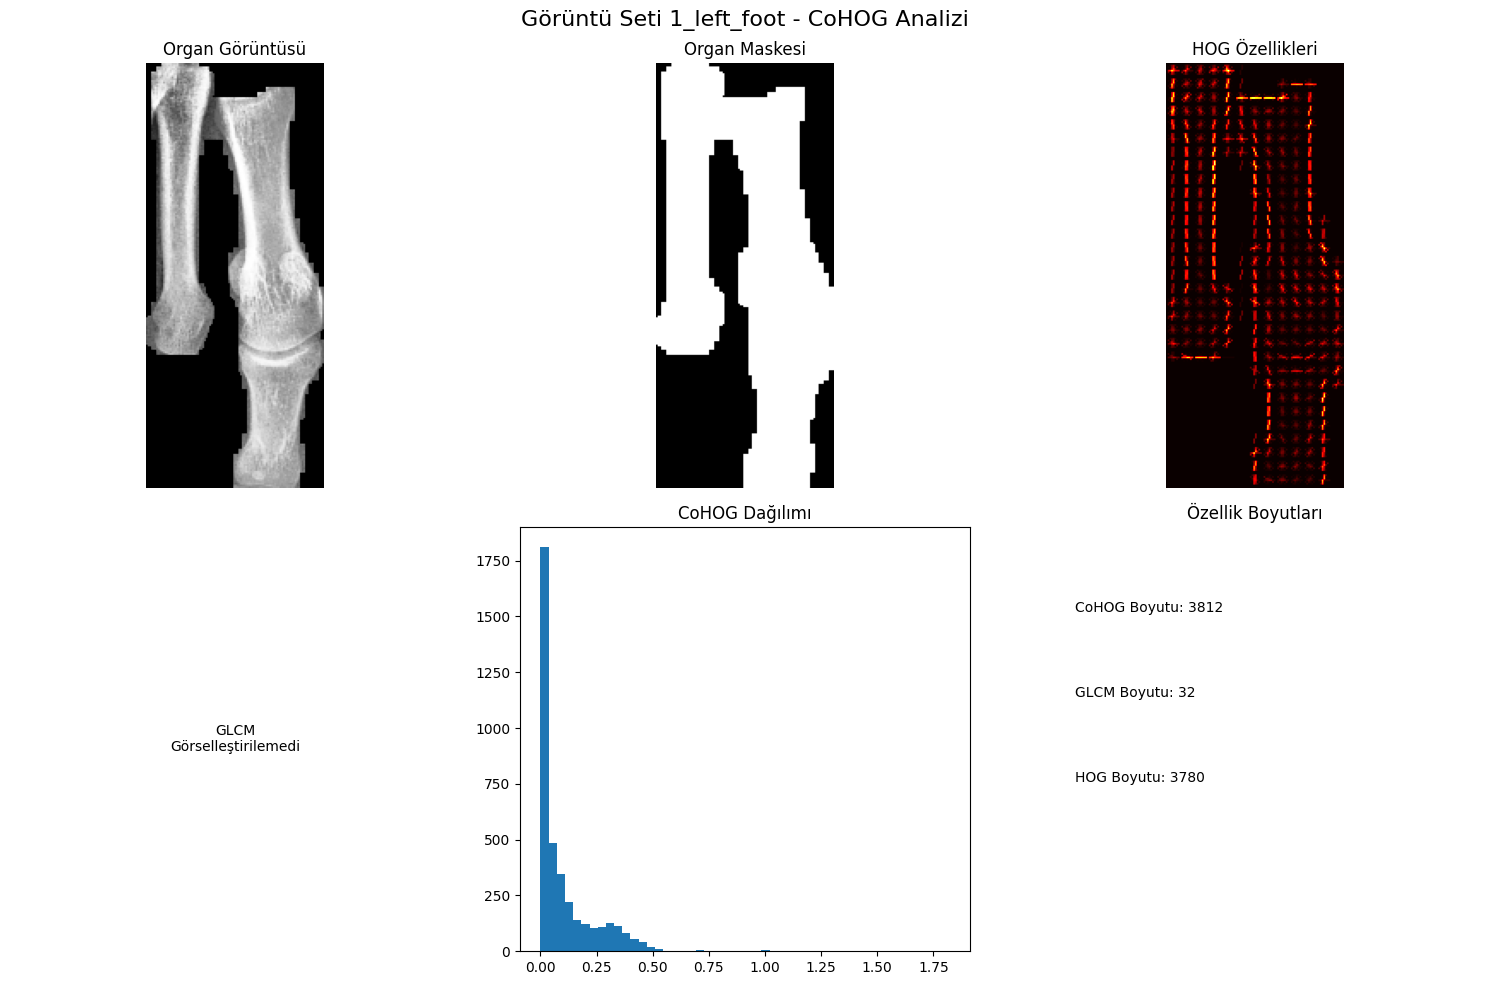


Sağ ayak işleniyor...

Organ CoHOG özellikleri kaydedildi:
Konum: C:\Users\sense\PycharmProjects\PythonProject1\cohog_features\Görüntü Seti 1_right_foot_single_cohog.pkl
CoHOG vektör boyutu: 3812
GLCM özellik sayısı: 32
HOG özellik sayısı: 3780
Dosya boyutu: 59.87 KB


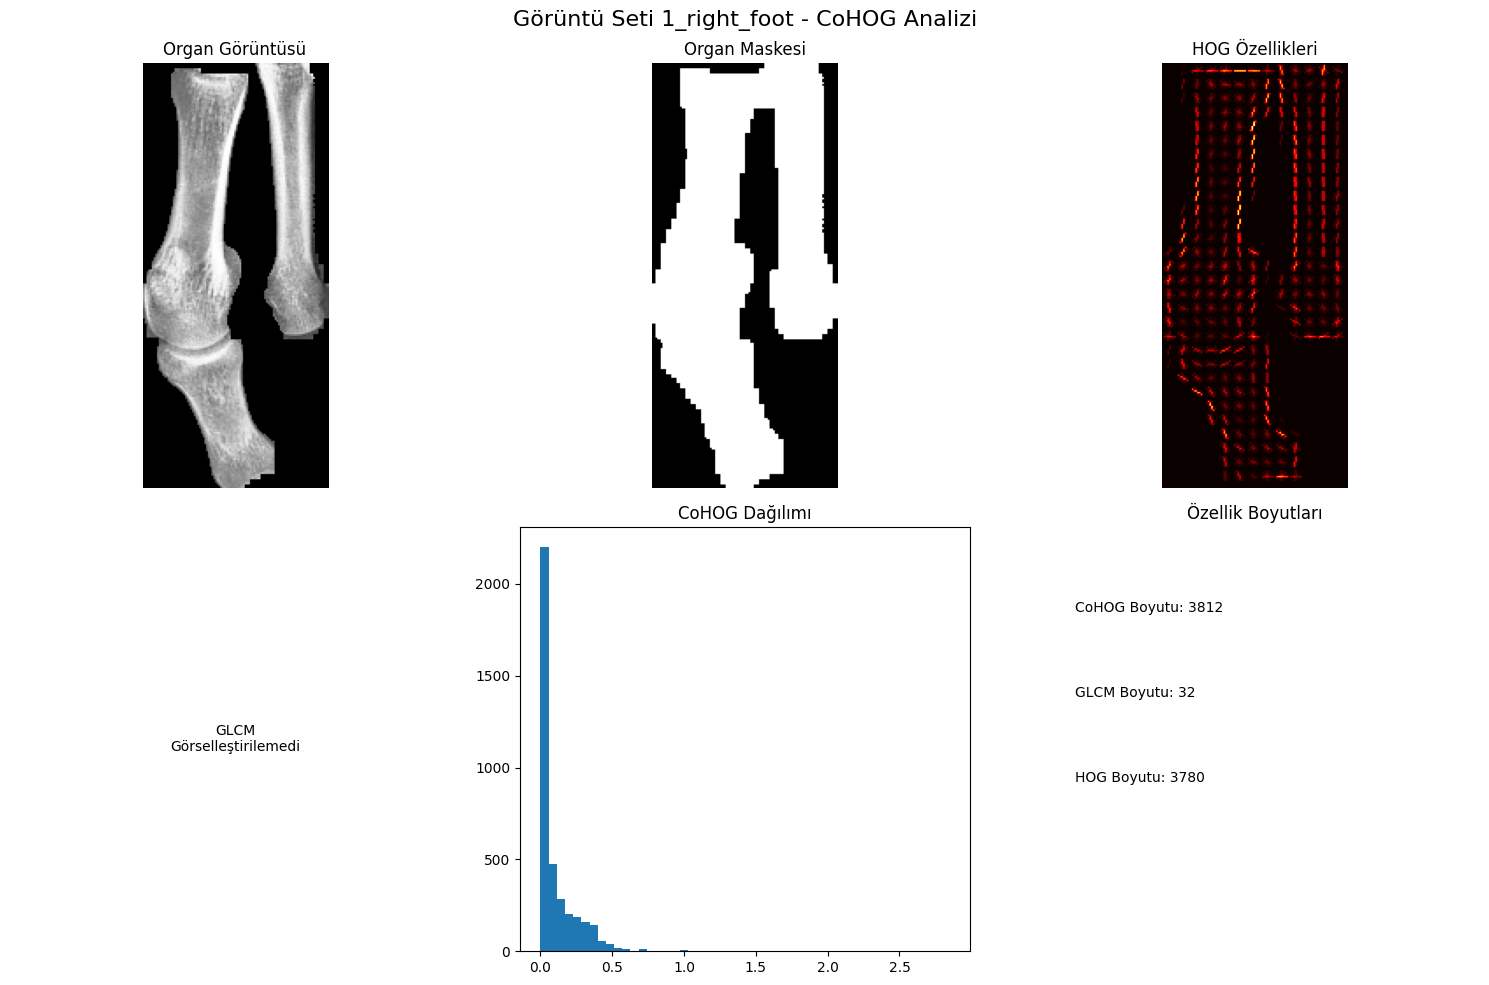


İşleniyor: Görüntü Seti 2
Görüntü dosyası: C:\Users\sense\PycharmProjects\PythonProject1\img2.png
Label dosyası: C:\Users\sense\PycharmProjects\PythonProject1\label2.png

CoHOG özellikleri çıkarılıyor...

Sol ayak işleniyor...

Organ CoHOG özellikleri kaydedildi:
Konum: C:\Users\sense\PycharmProjects\PythonProject1\cohog_features\Görüntü Seti 2_left_foot_single_cohog.pkl
CoHOG vektör boyutu: 3812
GLCM özellik sayısı: 32
HOG özellik sayısı: 3780
Dosya boyutu: 59.87 KB


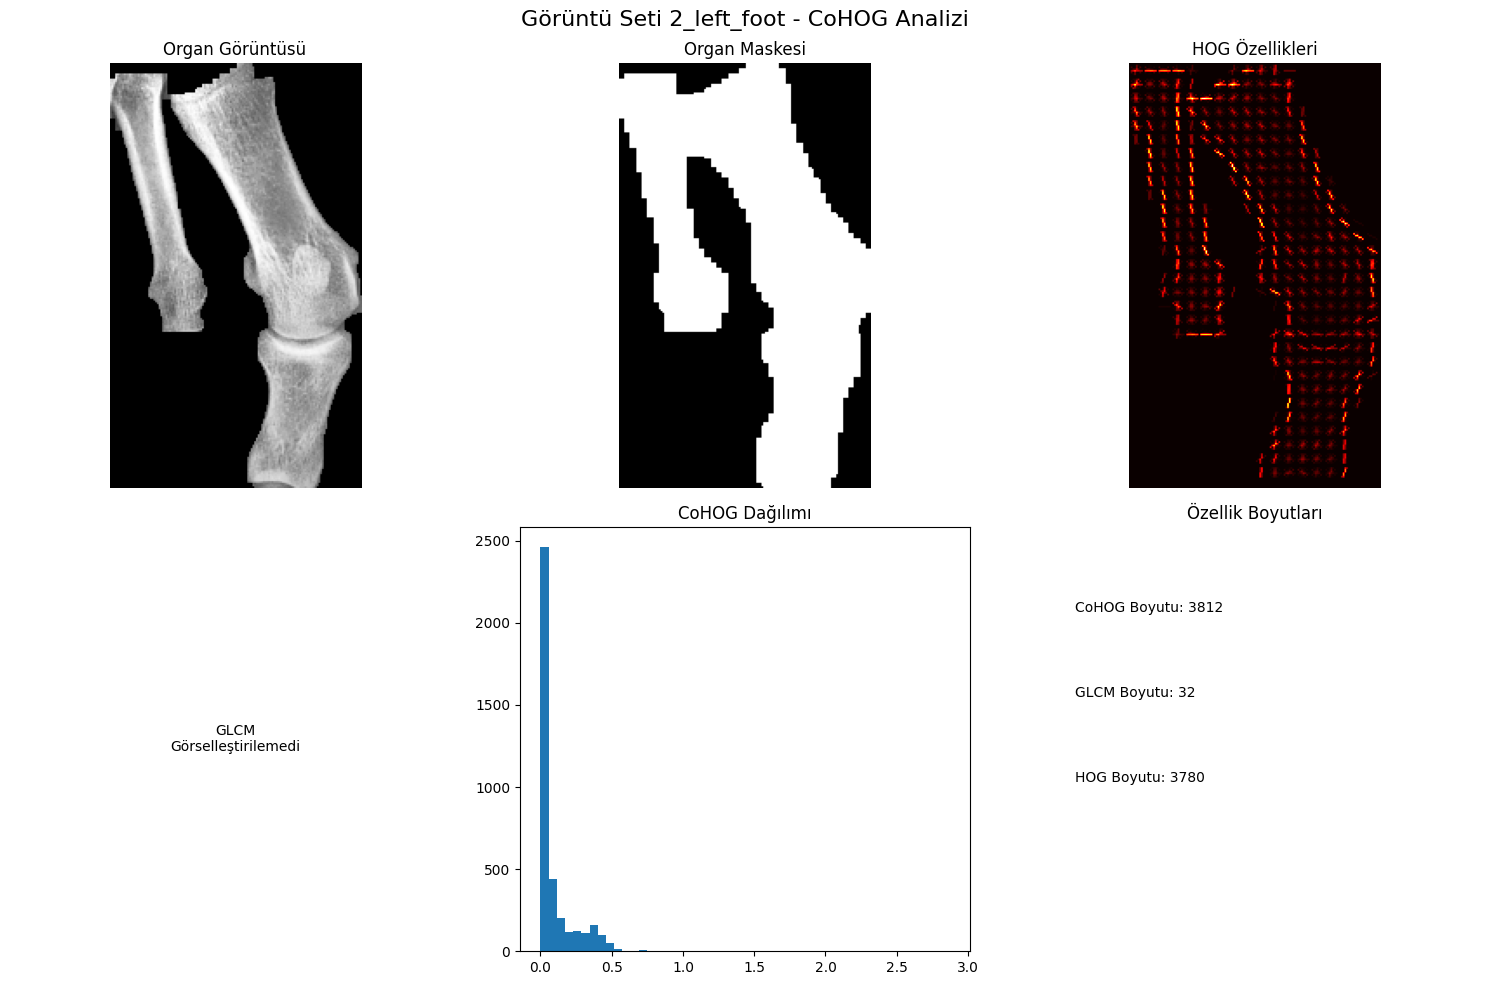


Sağ ayak işleniyor...

Organ CoHOG özellikleri kaydedildi:
Konum: C:\Users\sense\PycharmProjects\PythonProject1\cohog_features\Görüntü Seti 2_right_foot_single_cohog.pkl
CoHOG vektör boyutu: 3812
GLCM özellik sayısı: 32
HOG özellik sayısı: 3780
Dosya boyutu: 59.87 KB


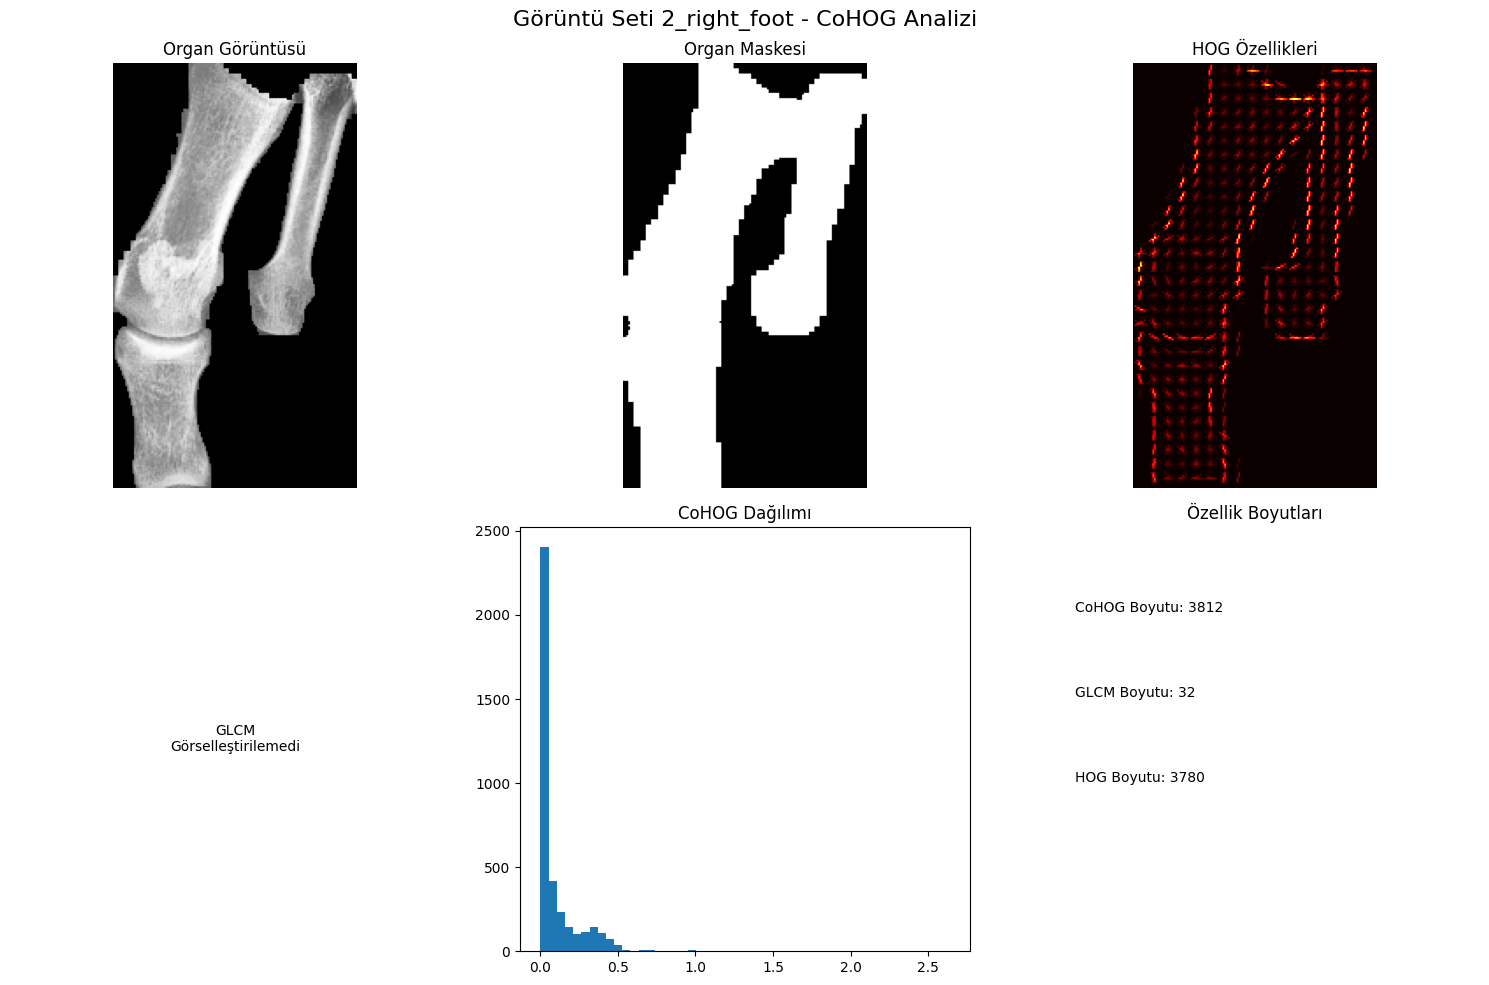


İşleniyor: Görüntü Seti 3
Görüntü dosyası: C:\Users\sense\PycharmProjects\PythonProject1\img3.png
Label dosyası: C:\Users\sense\PycharmProjects\PythonProject1\label3.png

CoHOG özellikleri çıkarılıyor...

Sol ayak işleniyor...

Organ CoHOG özellikleri kaydedildi:
Konum: C:\Users\sense\PycharmProjects\PythonProject1\cohog_features\Görüntü Seti 3_left_foot_single_cohog.pkl
CoHOG vektör boyutu: 3812
GLCM özellik sayısı: 32
HOG özellik sayısı: 3780
Dosya boyutu: 59.87 KB


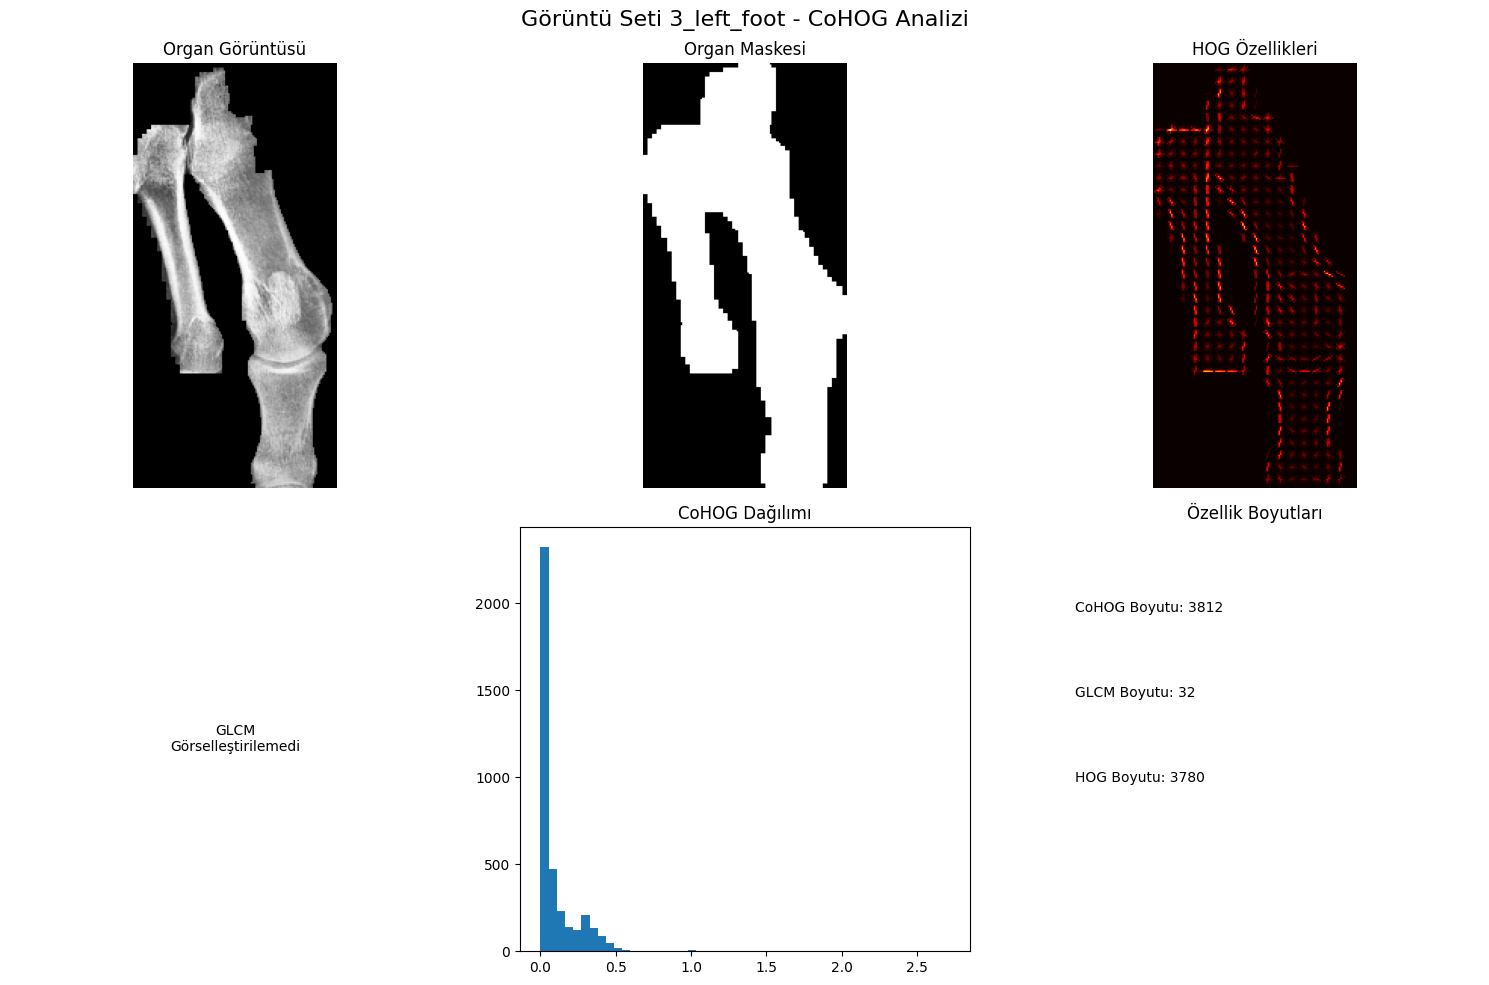


Sağ ayak işleniyor...

Organ CoHOG özellikleri kaydedildi:
Konum: C:\Users\sense\PycharmProjects\PythonProject1\cohog_features\Görüntü Seti 3_right_foot_single_cohog.pkl
CoHOG vektör boyutu: 3812
GLCM özellik sayısı: 32
HOG özellik sayısı: 3780
Dosya boyutu: 59.87 KB


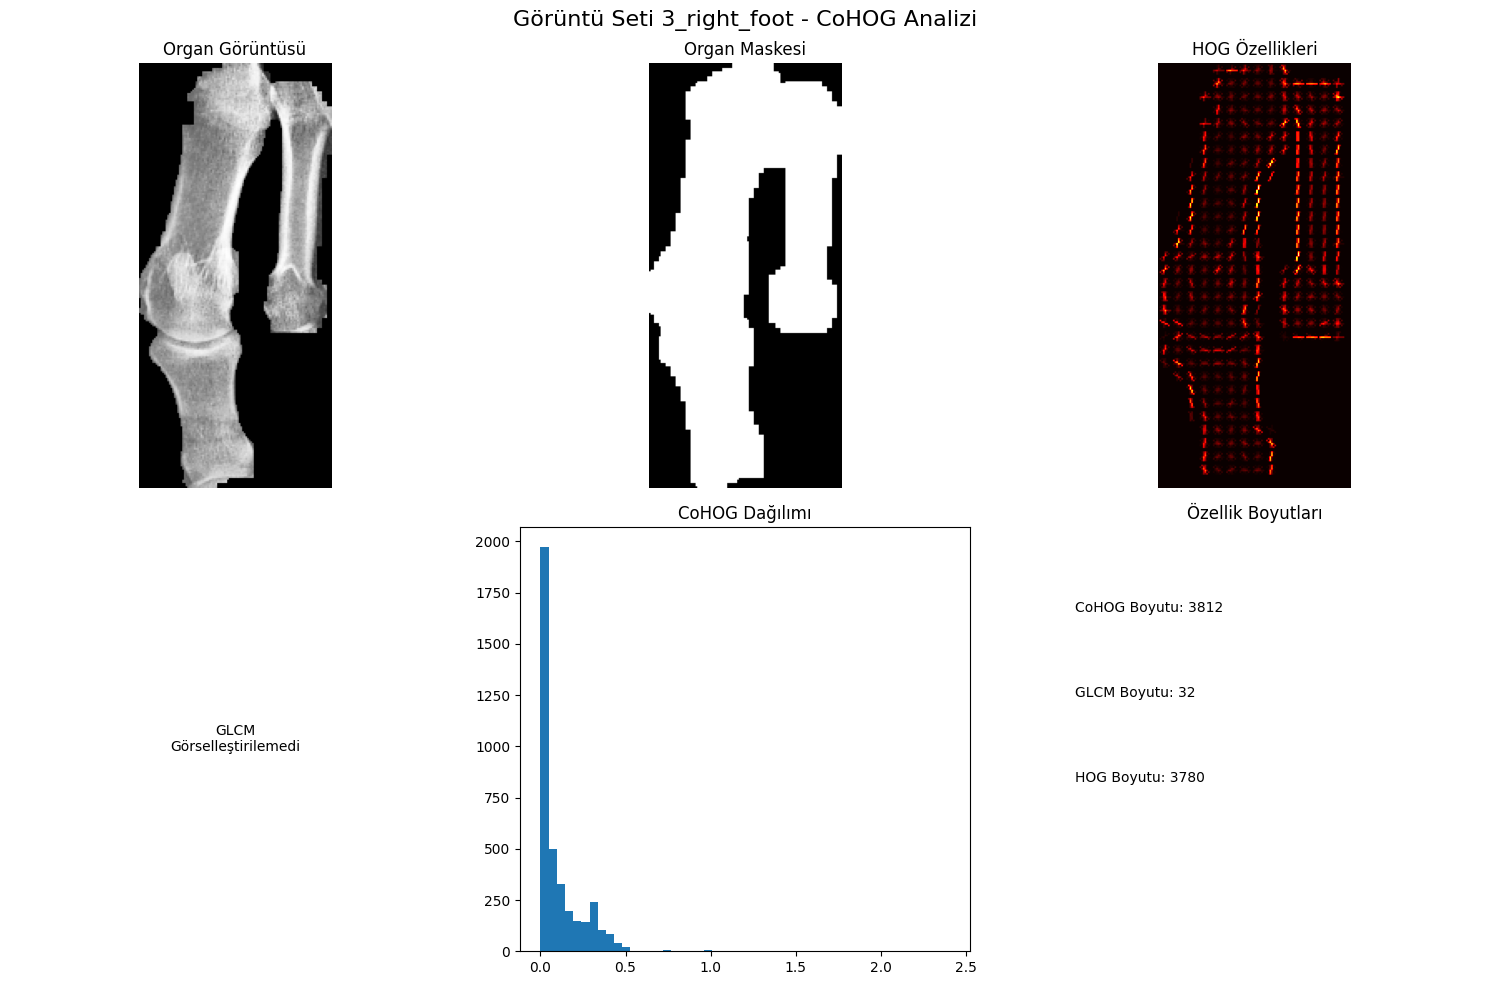


Tüm işlemler tamamlandı!


In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.ndimage as ndi
from scipy.stats import skew, kurtosis
from scipy.fftpack import dct, fft2
from skimage import filters, feature, morphology, measure
from skimage.util import img_as_ubyte
from skimage.feature import hog, local_binary_pattern
from skimage.transform import resize, pyramid_gaussian
from skimage.filters import gabor_kernel, frangi, hessian
from mahotas.features import haralick, zernike, lbp
import pywt
from pathlib import Path
import pickle
import os
%matplotlib inline

def safe_entropy(data):
    """Güvenli entropi hesaplama"""
    try:
        data = np.array(data, dtype=float)
        data = data[data > 0]
        if len(data) > 0:
            pk = data / data.sum()
            return float(-np.sum(pk * np.log2(pk)))
        return 0.0
    except:
        return 0.0

def compute_cohog_features(image, mask, angles=[0, 90], distances=[1], levels=8):
    """CoHOG özelliklerini hesapla"""
    try:
        def compute_glcm(img, angle, distance):
            """Belirli açı ve mesafe için GLCM matrisini hesapla"""
            rows, cols = img.shape
            glcm = np.zeros((levels, levels))

            theta = np.radians(angle)
            dx = int(distance * np.cos(theta))
            dy = int(distance * np.sin(theta))

            for i in range(rows):
                for j in range(cols):
                    if mask[i, j] == 0:
                        continue

                    ni, nj = i + dy, j + dx
                    if 0 <= ni < rows and 0 <= nj < cols and mask[ni, nj] > 0:
                        pi = int((img[i, j] / 255.0) * (levels-1))
                        pj = int((img[ni, nj] / 255.0) * (levels-1))
                        glcm[pi, pj] += 1

            # Simetrik matris oluştur
            glcm = glcm + glcm.T

            # Normalize et
            glcm_sum = glcm.sum()
            if glcm_sum > 0:
                glcm = glcm / glcm_sum

            return glcm

        def compute_glcm_features(glcm):
            """GLCM matrisinden istatistiksel özellikleri çıkar"""
            features = []

            if glcm.size == 0:
                return [0.0] * 4

            # İndeks matrisleri
            rows, cols = glcm.shape
            I, J = np.ogrid[0:rows, 0:cols]

            # Contrast
            contrast = np.sum(glcm * ((I-J)**2))
            features.append(float(contrast))

            # Correlation
            mu_i = np.sum(I * glcm)
            mu_j = np.sum(J * glcm)
            sigma_i = np.sqrt(np.sum(glcm * (I-mu_i)**2))
            sigma_j = np.sqrt(np.sum(glcm * (J-mu_j)**2))
            if sigma_i > 0 and sigma_j > 0:
                correlation = np.sum(glcm * (I-mu_i) * (J-mu_j) / (sigma_i * sigma_j))
            else:
                correlation = 0
            features.append(float(correlation))

            # Energy
            energy = np.sum(glcm**2)
            features.append(float(energy))

            # Homogeneity
            homogeneity = np.sum(glcm / (1 + (I-J)**2))
            features.append(float(homogeneity))

            return features

        # HOG özelliklerini hesapla
        hog_features, hog_image = hog(
            image,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=True,
            feature_vector=True
        )

        # Her açı ve mesafe için GLCM hesapla
        all_glcm_features = []
        for angle in angles:
            for distance in distances:
                glcm = compute_glcm(image, angle, distance)
                glcm_features = compute_glcm_features(glcm)
                all_glcm_features.extend(glcm_features)

        # GLCM özelliklerini numpy dizisine dönüştür
        glcm_features = np.array(all_glcm_features)

        # HOG ve GLCM özelliklerini birleştir
        cohog_features = np.concatenate([hog_features, glcm_features])

        return cohog_features, glcm_features, hog_features

    except Exception as e:
        print(f"CoHOG özellik hesaplama hatası: {str(e)}")
        # Varsayılan boyutlarda sıfır dizileri döndür
        hog_dim = 9 * ((image.shape[0]//8 - 1) * (image.shape[1]//8 - 1)) * 4
        glcm_dim = len(angles) * len(distances) * 4
        return np.zeros(hog_dim + glcm_dim), np.zeros(glcm_dim), np.zeros(hog_dim)

def apply_clahe(image):
    """Zıtlık Dönüşümü (CLAHE)"""
    try:
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        clahe_image = clahe.apply(image)
        return clahe_image
    except:
        return image

def preprocess_image(image):
    """Görüntü ön işleme"""
    try:
        if image is None:
            raise ValueError("Geçersiz görüntü")

        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image

        enhanced = apply_clahe(gray)
        blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)
        _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        kernel = np.ones((5,5), np.uint8)
        closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

        return opening, enhanced
    except Exception as e:
        print(f"Görüntü ön işleme hatası: {str(e)}")
        return None, None

def find_feet_contours(processed_image):
    """Ayak konturlarını bul"""
    try:
        if processed_image is None:
            return []
        contours, _ = cv2.findContours(processed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        return sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    except:
        return []
def separate_feet(image, processed, enhanced):
    """Ayakları ayır"""
    try:
        if processed is None or enhanced is None:
            return None, None, None, None

        contours = find_feet_contours(processed)
        height, width = enhanced.shape[:2]

        if len(contours) == 2:
            mask1 = np.zeros_like(processed)
            mask2 = np.zeros_like(processed)

            cv2.drawContours(mask1, [contours[0]], -1, 255, -1)
            cv2.drawContours(mask2, [contours[1]], -1, 255, -1)

            foot1 = cv2.bitwise_and(enhanced, enhanced, mask=mask1)
            foot2 = cv2.bitwise_and(enhanced, enhanced, mask=mask2)

            M1 = cv2.moments(contours[0])
            M2 = cv2.moments(contours[1])

            if M1['m00'] != 0 and M2['m00'] != 0:
                cx1 = int(M1['m10']/M1['m00'])
                cx2 = int(M2['m10']/M2['m00'])

                if cx1 < cx2:
                    return foot1, foot2, mask1, mask2
                else:
                    return foot2, foot1, mask2, mask1

        # Eğer kontur bulunamazsa görüntüyü ortadan böl
        left_foot = enhanced[:, :width//2].copy()
        right_foot = enhanced[:, width//2:].copy()
        left_mask = np.zeros_like(processed)
        right_mask = np.zeros_like(processed)
        left_mask[:, :width//2] = 255
        right_mask[:, width//2:] = 255

        return left_foot, right_foot, left_mask, right_mask

    except Exception as e:
        print(f"Ayak ayırma hatası: {str(e)}")
        return None, None, None, None

def extract_single_cohog_from_organ(image, label, title, output_dir, visualize=True):
    """Label maskesi kullanarak organ bölgesinden tek bir CoHOG vektörü çıkar"""
    try:
        # Görüntü kontrolü
        if image is None or label is None:
            raise ValueError("Geçersiz görüntü veya etiket")

        # Görüntü ve label boyutlarını eşitle
        if image.shape != label.shape:
            label = cv2.resize(label, (image.shape[1], image.shape[0]))

        # Label'ı binary maske olarak kullan
        mask = (label > 0).astype(np.uint8)

        # Sadece organ bölgesini al
        organ_region = image.copy()
        organ_region[mask == 0] = 0

        # Organ bölgesinin sınırlarını bul
        rows = np.any(mask, axis=1)
        cols = np.any(mask, axis=0)

        if not np.any(rows) or not np.any(cols):
            raise ValueError("Organ bölgesi bulunamadı")

        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]

        # Organ bölgesini kırp
        cropped_organ = organ_region[rmin:rmax+1, cmin:cmax+1]
        cropped_mask = mask[rmin:rmax+1, cmin:cmax+1]

        # Minimum boyut kontrolü
        if cropped_organ.shape[0] < 8 or cropped_organ.shape[1] < 8:
            raise ValueError("Organ bölgesi çok küçük")

        # Boyutu normalize et
        normalized_size = (128, 64)
        resized_organ = resize(cropped_organ, normalized_size, preserve_range=True).astype(np.uint8)
        resized_mask = resize(cropped_mask.astype(float), normalized_size, preserve_range=True) > 0.5

        # CoHOG özelliklerini hesapla
        cohog_features, glcm_features, hog_features = compute_cohog_features(
            resized_organ,
            resized_mask.astype(np.uint8),
            angles=[0, 45, 90, 135],
            distances=[1, 2],
            levels=8
        )

        # Sonuçları kaydet
        feature_data = {
            'cohog_vector': cohog_features,
            'glcm_features': glcm_features,
            'hog_features': hog_features,
            'organ_shape': cropped_organ.shape,
            'normalized_size': normalized_size
        }

        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)
        save_path = output_path / f'{title}_single_cohog.pkl'

        with open(save_path, 'wb') as f:
            pickle.dump(feature_data, f)

        print(f"\nOrgan CoHOG özellikleri kaydedildi:")
        print(f"Konum: {os.path.abspath(save_path)}")
        print(f"CoHOG vektör boyutu: {len(cohog_features)}")
        print(f"GLCM özellik sayısı: {len(glcm_features)}")
        print(f"HOG özellik sayısı: {len(hog_features)}")
        print(f"Dosya boyutu: {os.path.getsize(save_path) / 1024:.2f} KB")

        if visualize:
            visualize_cohog_features(cropped_organ, cropped_mask, feature_data, title)

        return feature_data

    except Exception as e:
        print(f"Özellik çıkarma hatası: {str(e)}")
        return None

def visualize_cohog_features(image, mask, features, title):
    """CoHOG özelliklerini görselleştir"""
    try:
        plt.figure(figsize=(15, 10))

        # Orijinal görüntü
        plt.subplot(231)
        plt.imshow(image, cmap='gray')
        plt.title('Organ Görüntüsü')
        plt.axis('off')

        # Maske
        plt.subplot(232)
        plt.imshow(mask, cmap='gray')
        plt.title('Organ Maskesi')
        plt.axis('off')

        # HOG görselleştirme
        try:
            _, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                             cells_per_block=(2, 2), visualize=True)
            plt.subplot(233)
            plt.imshow(hog_image, cmap='hot')
            plt.title('HOG Özellikleri')
            plt.axis('off')
        except:
            plt.subplot(233)
            plt.text(0.5, 0.5, 'HOG\nGörselleştirilemedi', ha='center', va='center')
            plt.axis('off')

        # GLCM görselleştirme
        try:
            glcm = feature.graycomatrix(image, [1], [0], levels=8, symmetric=True, normed=True)
            plt.subplot(234)
            plt.imshow(glcm[:,:,0,0], cmap='hot')
            plt.title('GLCM')
            plt.colorbar()
            plt.axis('off')
        except:
            plt.subplot(234)
            plt.text(0.5, 0.5, 'GLCM\nGörselleştirilemedi', ha='center', va='center')
            plt.axis('off')

        # CoHOG özellik vektörü dağılımı
        try:
            plt.subplot(235)
            plt.hist(features['cohog_vector'], bins=50)
            plt.title('CoHOG Dağılımı')
        except:
            plt.subplot(235)
            plt.text(0.5, 0.5, 'CoHOG Dağılımı\nGörselleştirilemedi', ha='center', va='center')
            plt.axis('off')

        # Özellik boyutları
        plt.subplot(236)
        plt.text(0.1, 0.8, f"CoHOG Boyutu: {len(features['cohog_vector'])}")
        plt.text(0.1, 0.6, f"GLCM Boyutu: {len(features['glcm_features'])}")
        plt.text(0.1, 0.4, f"HOG Boyutu: {len(features['hog_features'])}")
        plt.axis('off')
        plt.title('Özellik Boyutları')

        plt.suptitle(f'{title} - CoHOG Analizi', fontsize=16)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Görselleştirme hatası: {str(e)}")

def process_image_set(img_path, label_path, title, output_dir='cohog_features'):
    """Görüntü setini işle"""
    try:
        print(f"\n{'='*50}")
        print(f"İşleniyor: {title}")
        print(f"{'='*50}")

        # Görüntüleri oku
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Görüntü okunamadı: {img_path}")

        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        if label is None:
            raise ValueError(f"Label okunamadı: {label_path}")

        print(f"Görüntü dosyası: {os.path.abspath(img_path)}")
        print(f"Label dosyası: {os.path.abspath(label_path)}")

        # Görüntüleri işle
        processed_img, enhanced_img = preprocess_image(img)
        processed_label, enhanced_label = preprocess_image(label)

        # Ayakları ayır
        left_img, right_img, left_mask_img, right_mask_img = separate_feet(
            img, processed_img, enhanced_img)

        if any(x is None for x in [left_img, right_img, left_mask_img, right_mask_img]):
            raise ValueError("Görüntü ayırma başarısız")

        left_label, right_label, left_mask_label, right_mask_label = separate_feet(
            label, processed_label, enhanced_label)

        if any(x is None for x in [left_label, right_label, left_mask_label, right_mask_label]):
            raise ValueError("Label ayırma başarısız")

        # CoHOG özelliklerini çıkar
        print("\nCoHOG özellikleri çıkarılıyor...")

        # Sol ayak için
        print("\nSol ayak işleniyor...")
        left_features = extract_single_cohog_from_organ(
            left_img,
            left_label,
            f'{title}_left_foot',
            output_dir
        )

        # Sağ ayak için
        print("\nSağ ayak işleniyor...")
        right_features = extract_single_cohog_from_organ(
            right_img,
            right_label,
            f'{title}_right_foot',
            output_dir
        )

        return left_features, right_features

    except Exception as e:
        print(f"Hata: {str(e)}")
        return None, None

def main():
    """Ana program"""
    try:
        output_directory = 'cohog_features'
        print(f"\nÖzellikler şu dizine kaydedilecek: {os.path.abspath(output_directory)}")

        # Test görüntülerini işle
        for i in range(1, 4):
            left_feat, right_feat = process_image_set(
                f'img{i}.png',
                f'label{i}.png',
                f'Görüntü Seti {i}',
                output_directory
            )

        print("\nTüm işlemler tamamlandı!")
    except Exception as e:
        print(f"Ana program hatası: {str(e)}")

if __name__ == "__main__":
    main()


Özellikler şu dizine kaydedilecek: C:\Users\sense\PycharmProjects\PythonProject1\organ_features_cohog

İşleniyor: Görüntü Seti 1
Görüntü dosyası: C:\Users\sense\PycharmProjects\PythonProject1\img1.png
Label dosyası: C:\Users\sense\PycharmProjects\PythonProject1\label1.png

Sol ayak işleniyor...

Patch'ler işleniyor (12508 piksel)...


100%|██████████| 12508/12508 [00:32<00:00, 388.57it/s]



CoHOG özellikleri kaydedildi:
Konum: C:\Users\sense\PycharmProjects\PythonProject1\organ_features_cohog\Görüntü Seti 1_left_foot_cohog_patches.pkl
İşlenen patch sayısı: 12508
CoHOG özellik boyutu: 296
GLCM özellik boyutu: 8
HOG özellik boyutu: 288


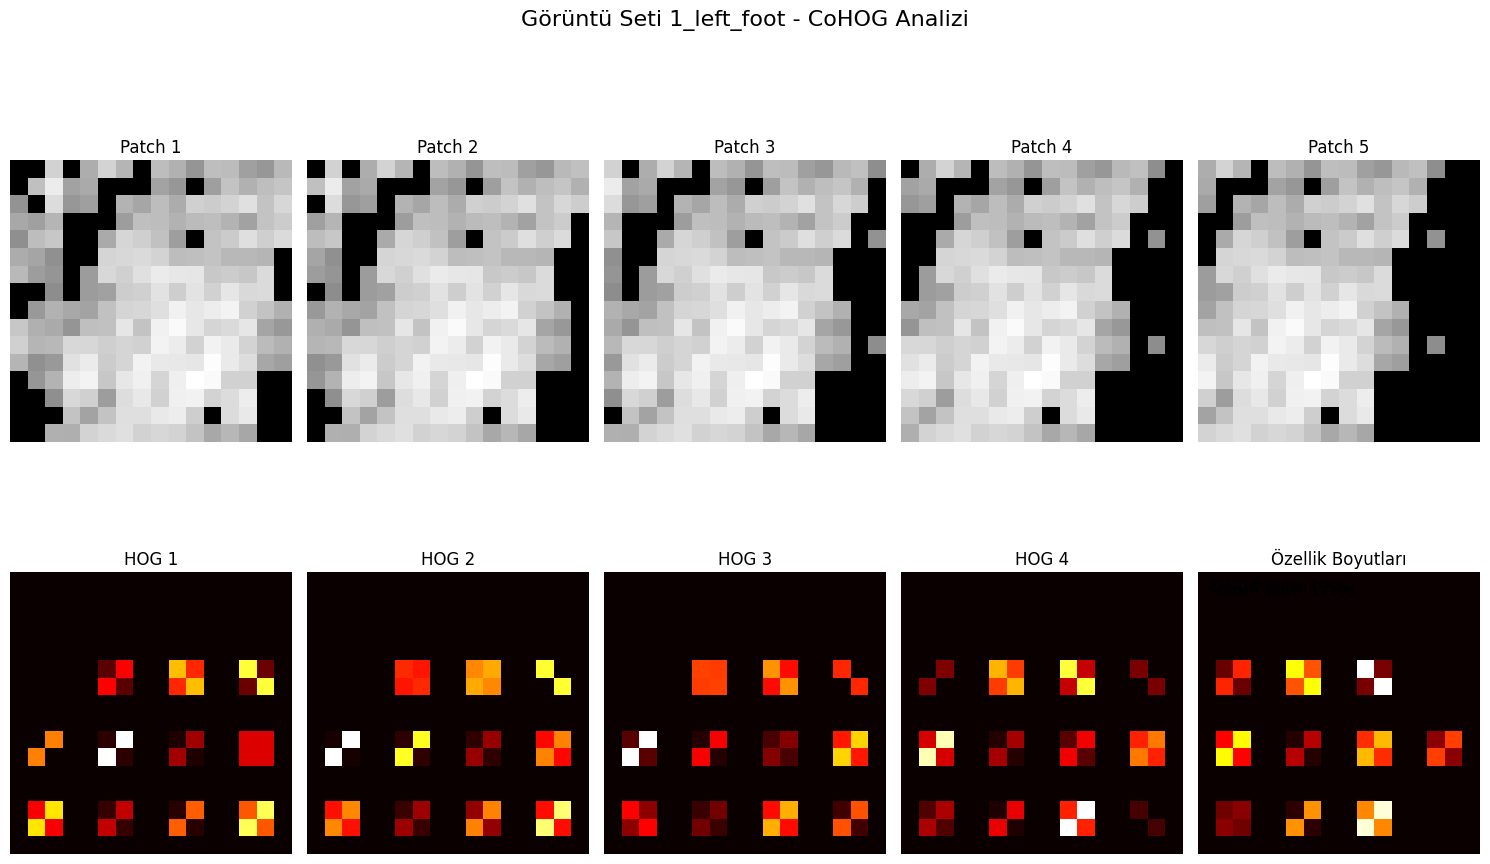

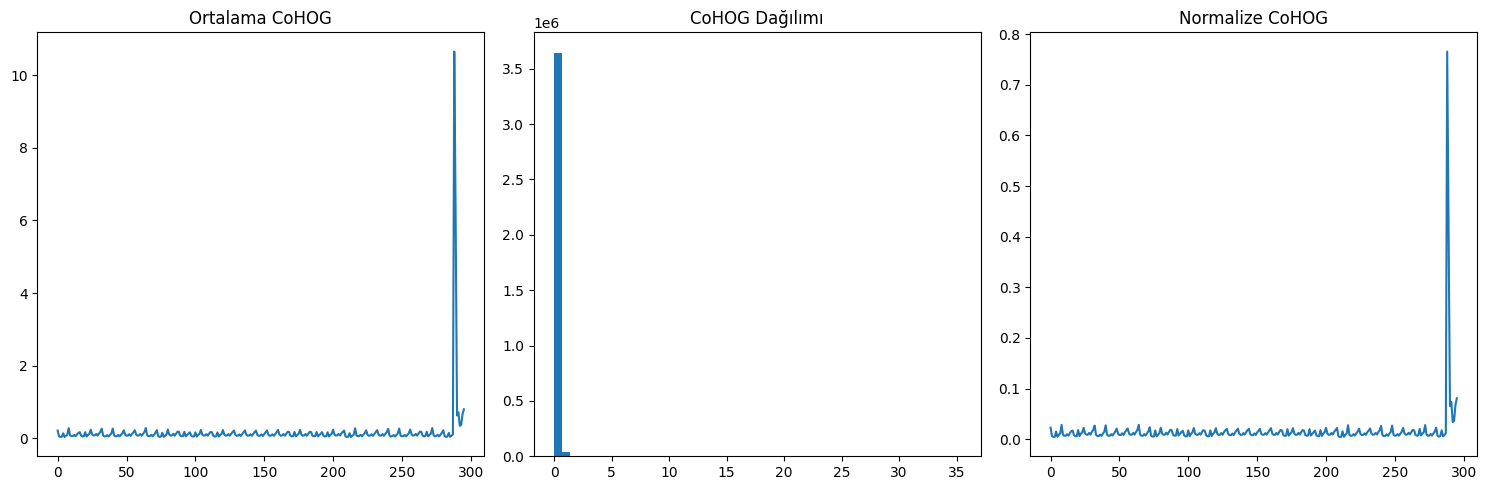


Sağ ayak işleniyor...

Patch'ler işleniyor (12226 piksel)...


100%|██████████| 12226/12226 [00:31<00:00, 390.35it/s]



CoHOG özellikleri kaydedildi:
Konum: C:\Users\sense\PycharmProjects\PythonProject1\organ_features_cohog\Görüntü Seti 1_right_foot_cohog_patches.pkl
İşlenen patch sayısı: 12226
CoHOG özellik boyutu: 296
GLCM özellik boyutu: 8
HOG özellik boyutu: 288


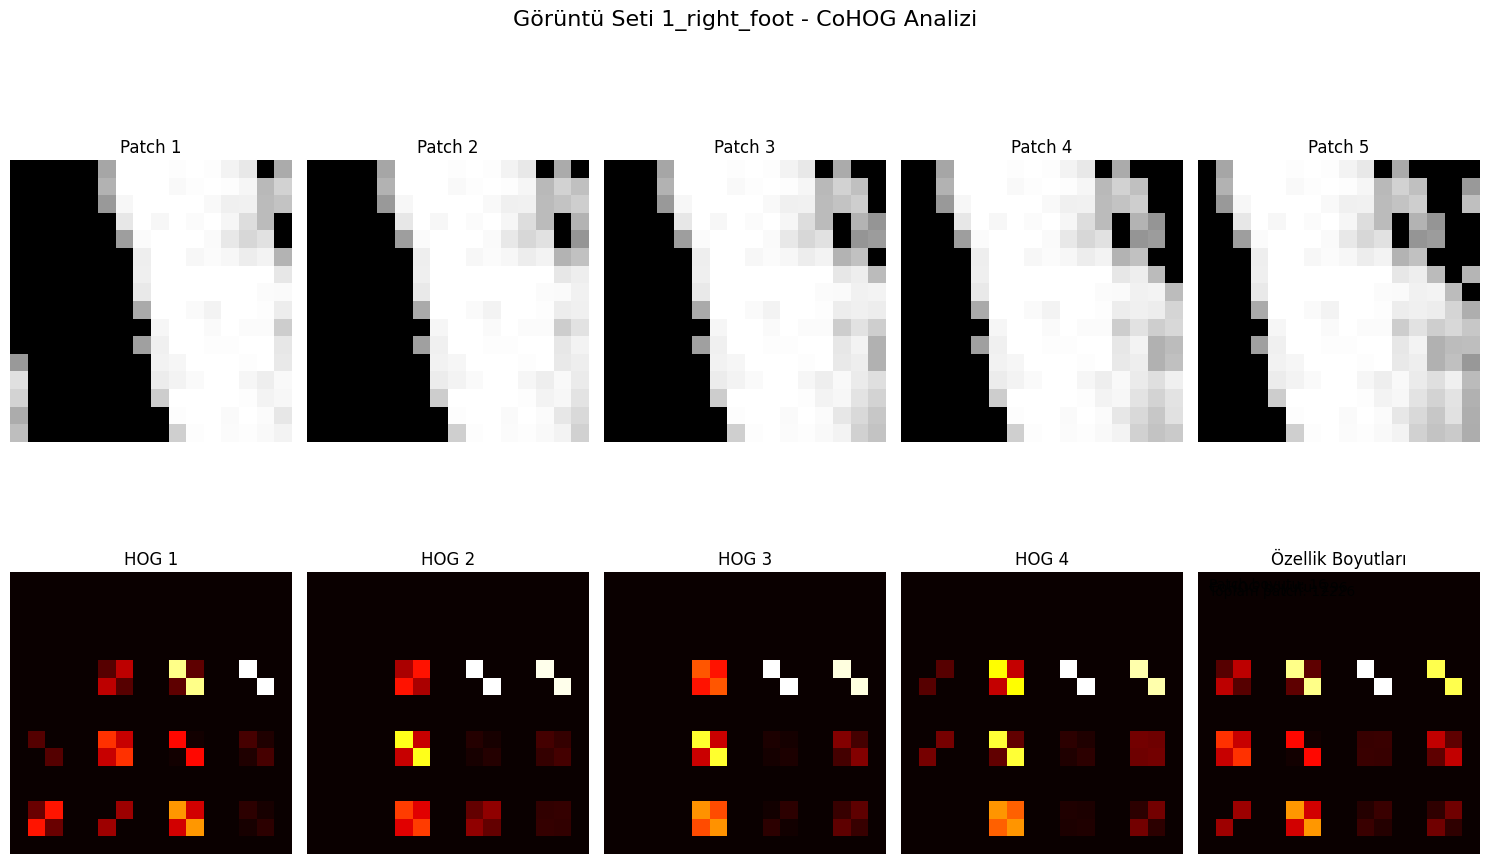

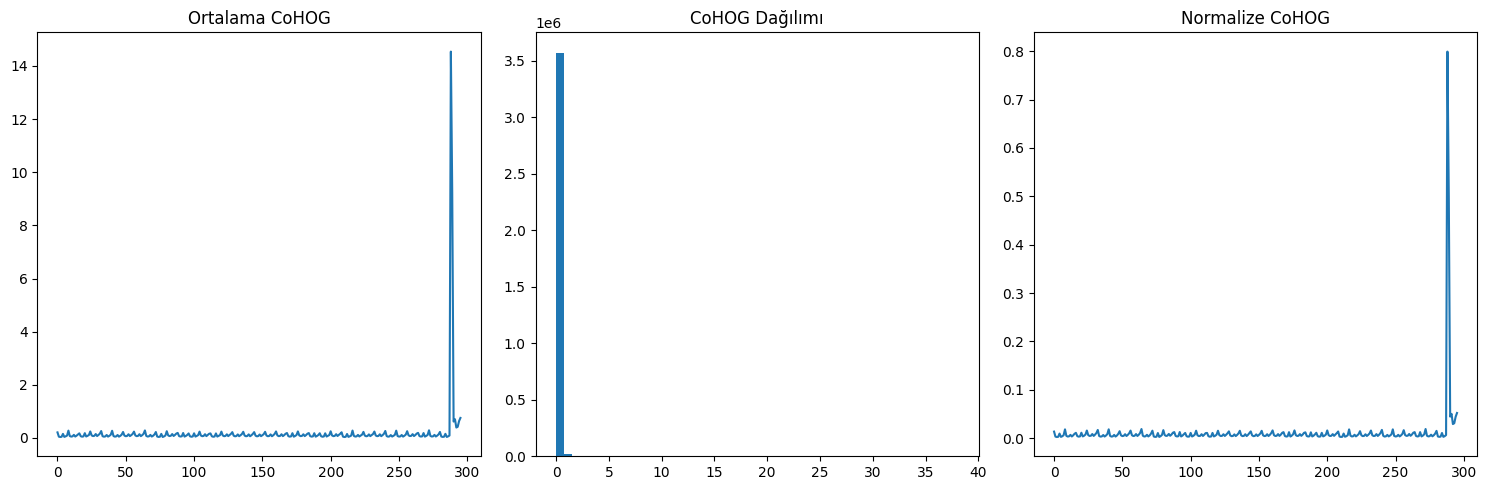


İşleniyor: Görüntü Seti 2
Görüntü dosyası: C:\Users\sense\PycharmProjects\PythonProject1\img2.png
Label dosyası: C:\Users\sense\PycharmProjects\PythonProject1\label2.png

Sol ayak işleniyor...

Patch'ler işleniyor (15114 piksel)...


100%|██████████| 15114/15114 [00:37<00:00, 400.19it/s]



CoHOG özellikleri kaydedildi:
Konum: C:\Users\sense\PycharmProjects\PythonProject1\organ_features_cohog\Görüntü Seti 2_left_foot_cohog_patches.pkl
İşlenen patch sayısı: 15114
CoHOG özellik boyutu: 296
GLCM özellik boyutu: 8
HOG özellik boyutu: 288


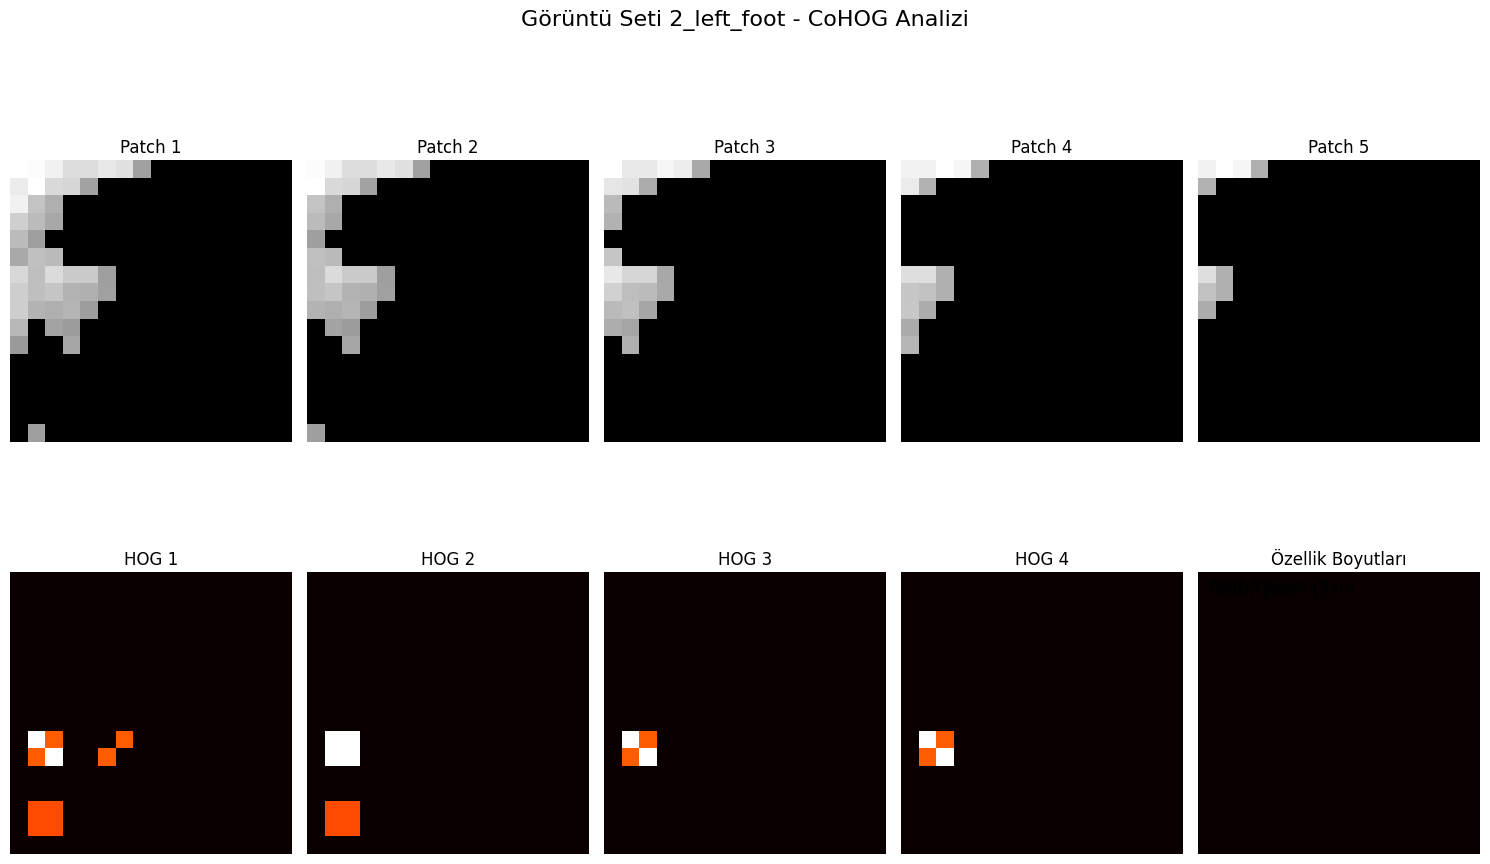

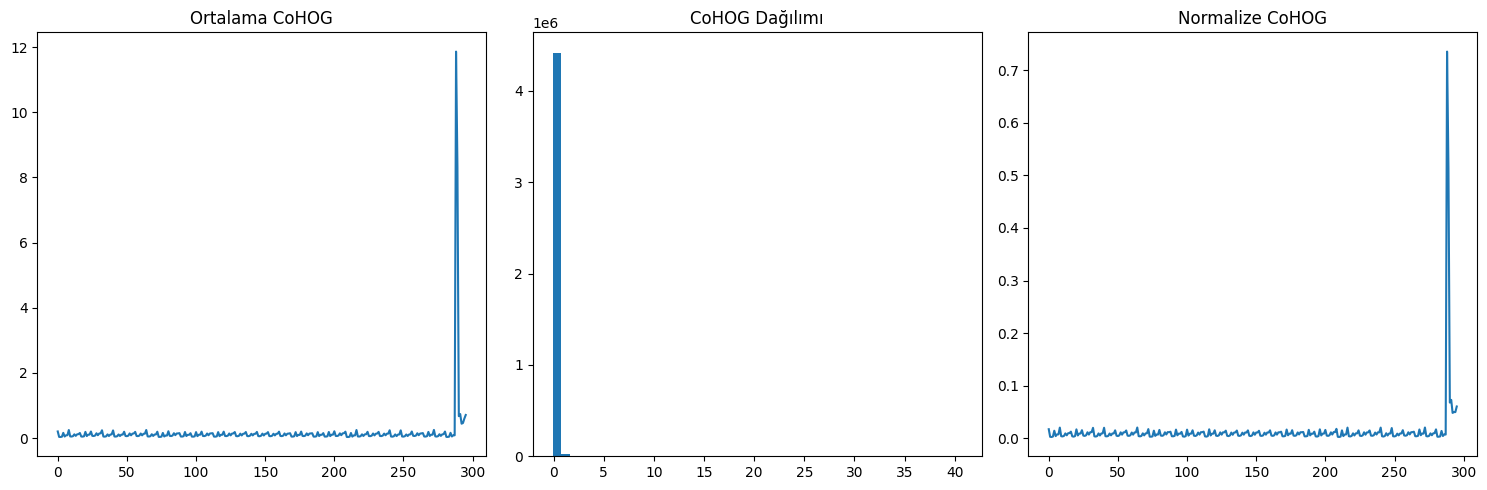


Sağ ayak işleniyor...

Patch'ler işleniyor (14650 piksel)...


100%|██████████| 14650/14650 [00:37<00:00, 392.92it/s]



CoHOG özellikleri kaydedildi:
Konum: C:\Users\sense\PycharmProjects\PythonProject1\organ_features_cohog\Görüntü Seti 2_right_foot_cohog_patches.pkl
İşlenen patch sayısı: 14650
CoHOG özellik boyutu: 296
GLCM özellik boyutu: 8
HOG özellik boyutu: 288


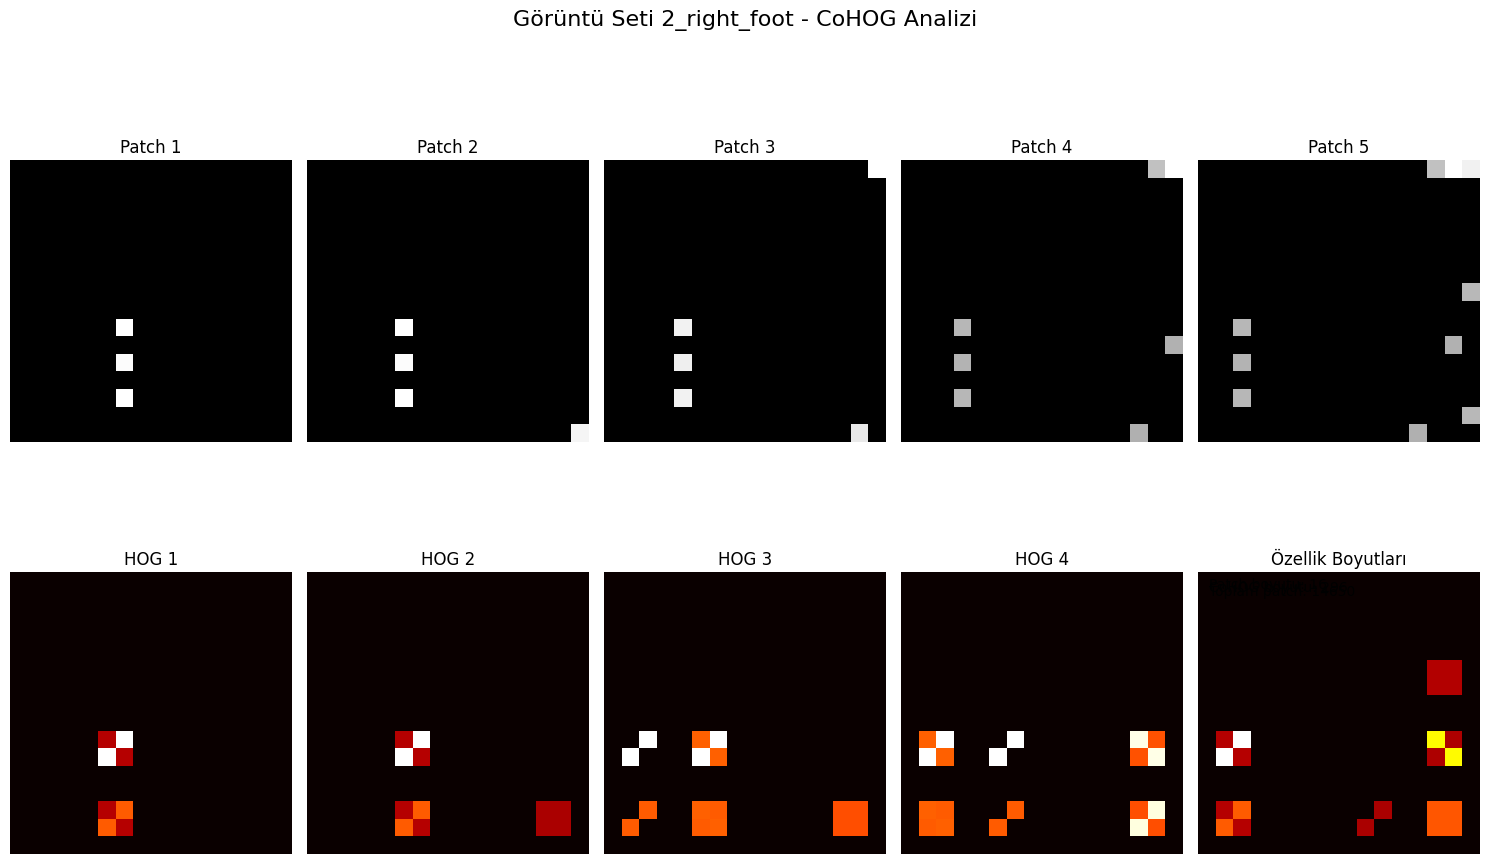

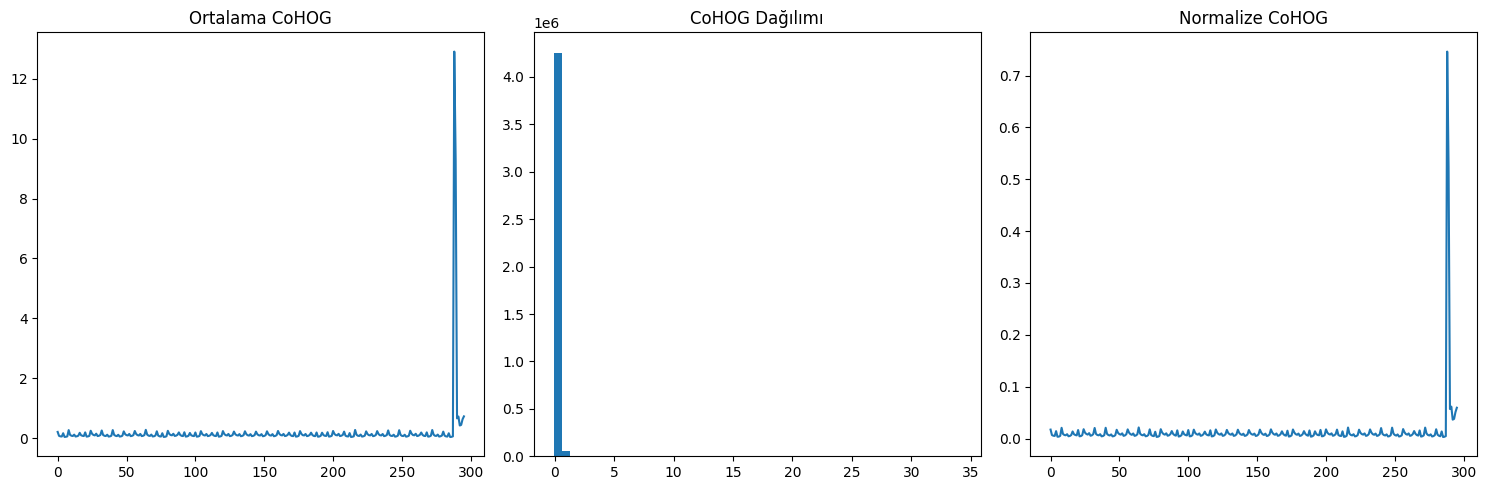


İşleniyor: Görüntü Seti 3
Görüntü dosyası: C:\Users\sense\PycharmProjects\PythonProject1\img3.png
Label dosyası: C:\Users\sense\PycharmProjects\PythonProject1\label3.png

Sol ayak işleniyor...

Patch'ler işleniyor (16548 piksel)...


100%|██████████| 16548/16548 [00:39<00:00, 414.74it/s]



CoHOG özellikleri kaydedildi:
Konum: C:\Users\sense\PycharmProjects\PythonProject1\organ_features_cohog\Görüntü Seti 3_left_foot_cohog_patches.pkl
İşlenen patch sayısı: 16548
CoHOG özellik boyutu: 296
GLCM özellik boyutu: 8
HOG özellik boyutu: 288


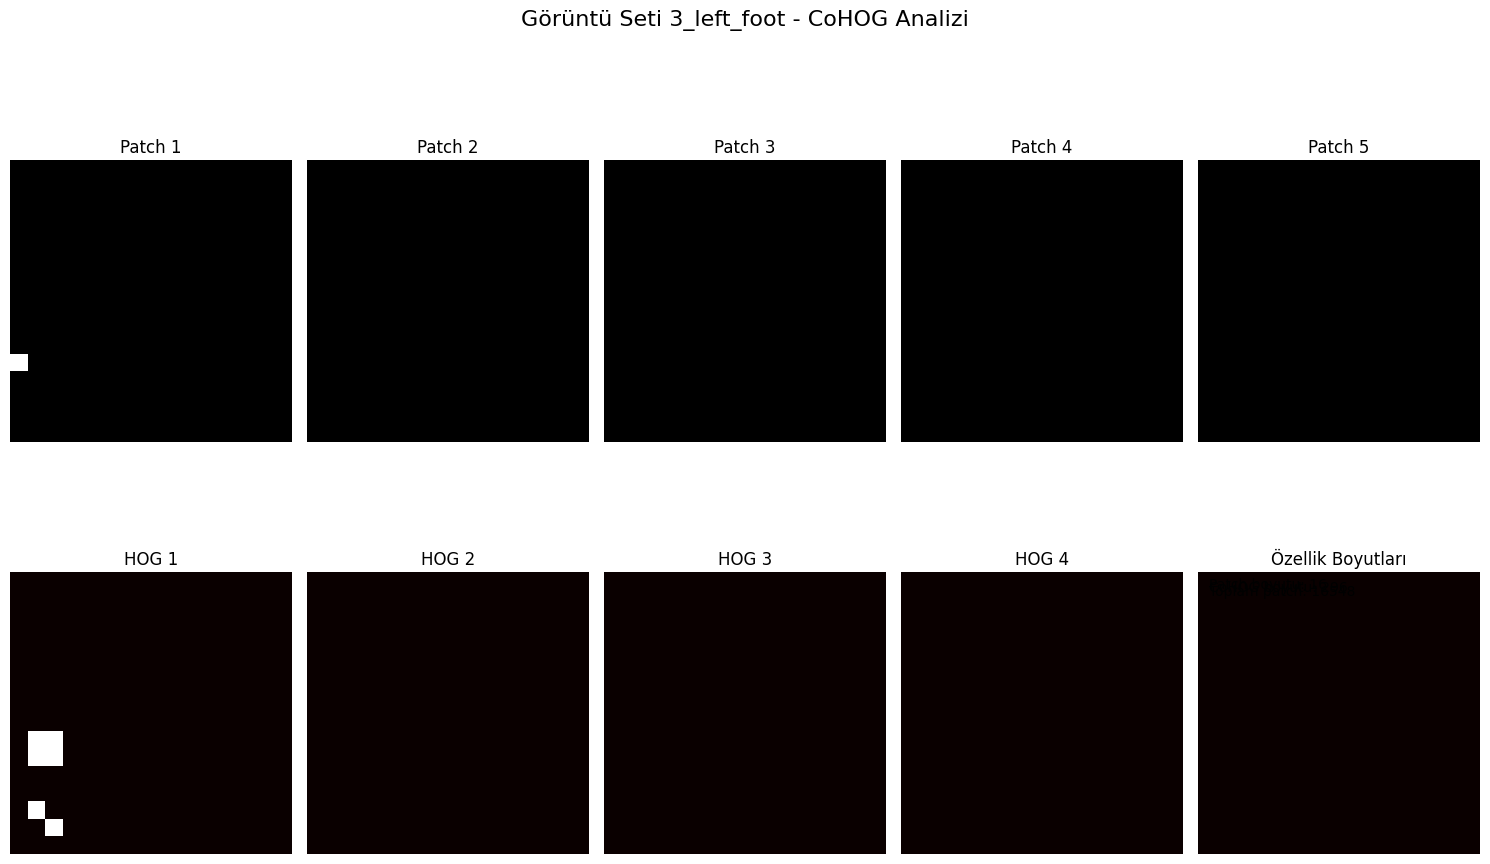

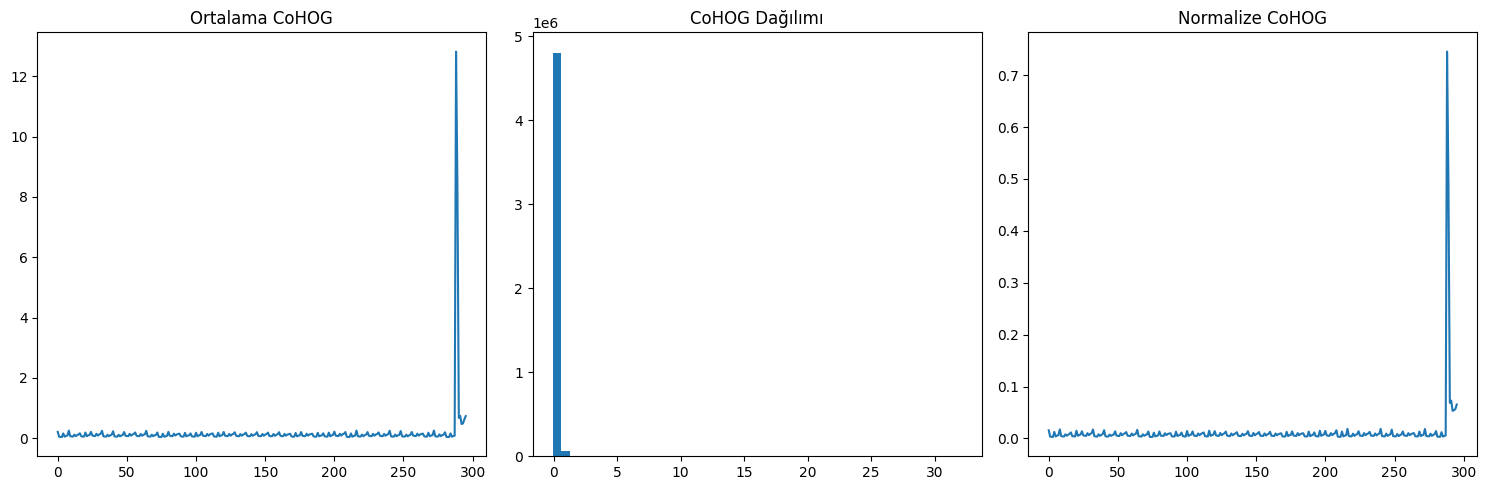


Sağ ayak işleniyor...

Patch'ler işleniyor (14819 piksel)...


100%|██████████| 14819/14819 [00:39<00:00, 373.30it/s]



CoHOG özellikleri kaydedildi:
Konum: C:\Users\sense\PycharmProjects\PythonProject1\organ_features_cohog\Görüntü Seti 3_right_foot_cohog_patches.pkl
İşlenen patch sayısı: 14819
CoHOG özellik boyutu: 296
GLCM özellik boyutu: 8
HOG özellik boyutu: 288


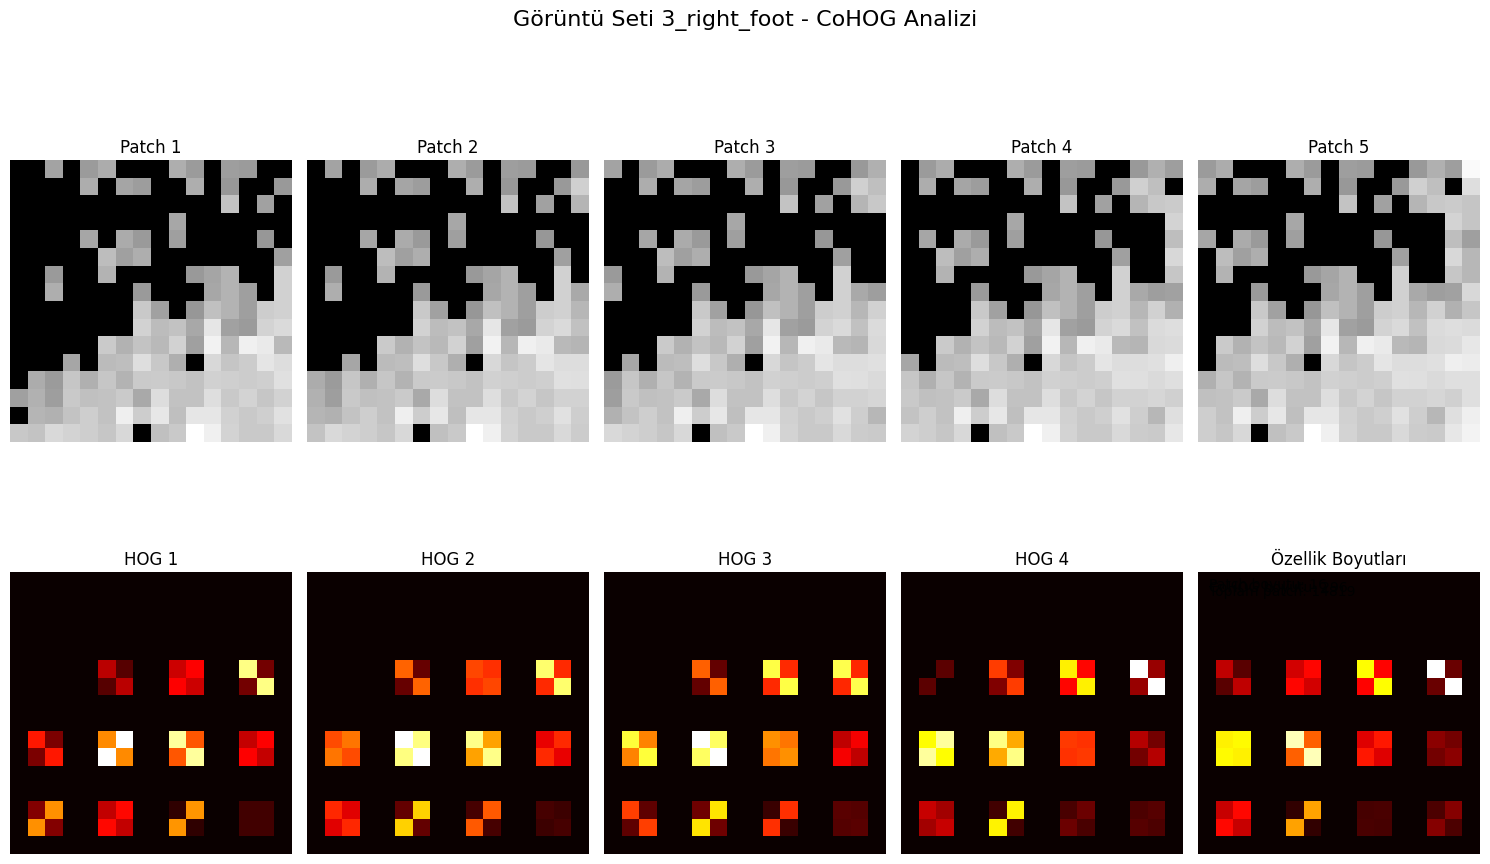

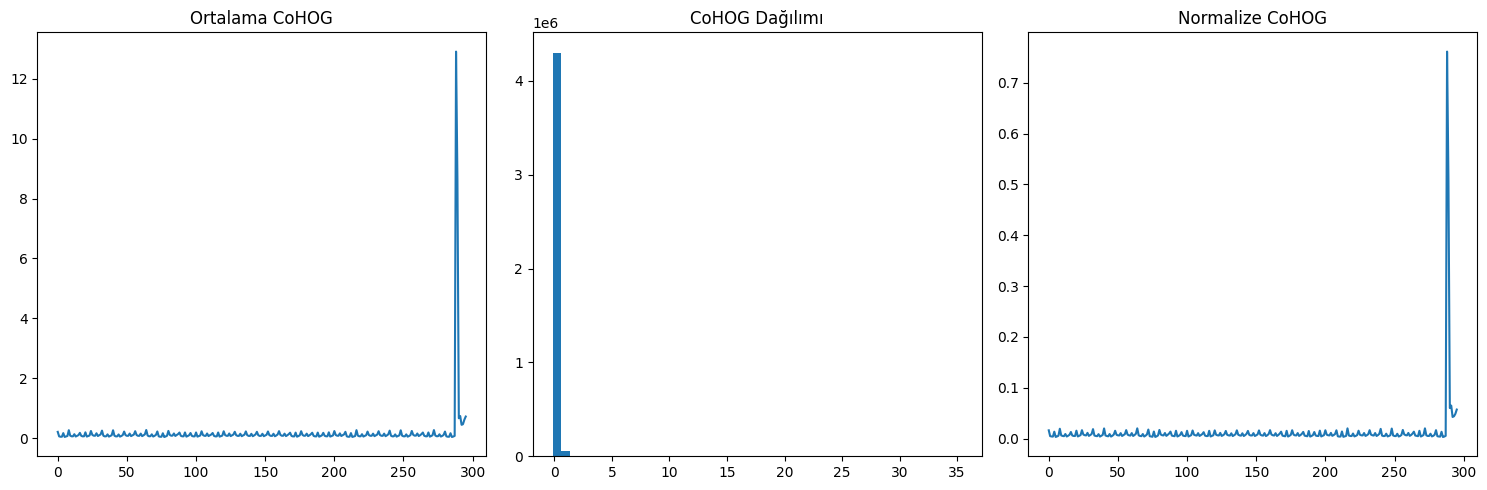


Tüm işlemler tamamlandı!


In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.ndimage as ndi
from skimage import filters, feature, morphology
from skimage.util import img_as_ubyte
from skimage.feature import hog
from skimage.transform import resize
from pathlib import Path
import pickle
import os
from tqdm import tqdm  # İlerleme çubuğu için
%matplotlib inline

def apply_clahe(image):
    """Zıtlık Dönüşümü (CLAHE)"""
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    return clahe_image

def preprocess_image(image):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    enhanced = apply_clahe(gray)
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((5,5), np.uint8)
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

    return opening, enhanced

def minmax_norm(image):
    """MinMax normalizasyon"""
    image_float = image.astype(float)
    min_val = np.min(image_float)
    max_val = np.max(image_float)
    if max_val != min_val:
        normalized = (image_float - min_val) / (max_val - min_val) * 255
    else:
        normalized = image_float
    return normalized.astype(np.uint8)

def optimal_image_enhancement(image):
    """Görüntü iyileştirme"""
    normalized = minmax_norm(image)
    gaussian = cv2.GaussianBlur(normalized, (3,3), 0.3)
    enhanced_base = cv2.convertScaleAbs(gaussian, alpha=1.05, beta=0)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_clahe = clahe.apply(enhanced_base)

    _, threshold = cv2.threshold(enhanced_clahe, 140, 255, cv2.THRESH_TOZERO)

    return threshold

def compute_cohog_features(image, mask, patch_size=16, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(2, 2)):
    """
    Görüntüden CoHOG özelliklerini hesapla - Optimize edilmiş versiyon
    """
    try:
        # Görüntü boyutunu kontrol et
        if image.shape[0] < 8 or image.shape[1] < 8:
            return None, None, None, None

        # Maskelenmiş görüntüyü oluştur
        masked_image = cv2.bitwise_and(image, image, mask=mask.astype(np.uint8))

        # HOG özelliklerini hesapla - optimize edilmiş parametreler
        hog_features, hog_image = hog(
            masked_image,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            visualize=True,
            feature_vector=True
        )

        # GLCM için görüntüyü yeniden boyutlandır ve normalize et
        scaled_image = cv2.resize(masked_image, (16, 16))

        # Görüntüyü 0-15 aralığına normalize et
        scaled_image = ((scaled_image / 255.0) * 15).astype(np.uint8)

        # Co-occurrence matrisini hesapla - optimize edilmiş parametreler
        glcm = feature.graycomatrix(
            scaled_image,
            distances=[1],
            angles=[0, np.pi/2],
            levels=16,  # Gri seviye sayısı
            symmetric=True,
            normed=True
        )

        # GLCM özelliklerini çıkar
        contrast = feature.graycoprops(glcm, 'contrast').ravel()
        homogeneity = feature.graycoprops(glcm, 'homogeneity').ravel()
        energy = feature.graycoprops(glcm, 'energy').ravel()
        correlation = feature.graycoprops(glcm, 'correlation').ravel()

        # GLCM özelliklerini birleştir
        glcm_features = np.concatenate([
            contrast,
            homogeneity,
            energy,
            correlation
        ])

        # HOG ve GLCM özelliklerini birleştir
        cohog_features = np.concatenate([hog_features, glcm_features])

        return cohog_features, glcm_features, hog_features, hog_image

    except Exception as e:
        print(f"CoHOG özellik hesaplama hatası: {str(e)}")
        return None, None, None, None

def find_feet_contours(processed_image):
    contours, _ = cv2.findContours(processed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    return contours

def separate_feet(image, processed, enhanced):
    contours = find_feet_contours(processed)

    if len(contours) == 2:
        mask1 = np.zeros_like(processed)
        mask2 = np.zeros_like(processed)

        cv2.drawContours(mask1, [contours[0]], -1, 255, -1)
        cv2.drawContours(mask2, [contours[1]], -1, 255, -1)

        foot1 = cv2.bitwise_and(enhanced, enhanced, mask=mask1)
        foot2 = cv2.bitwise_and(enhanced, enhanced, mask=mask2)

        M1 = cv2.moments(contours[0])
        M2 = cv2.moments(contours[1])

        if M1['m00'] != 0 and M2['m00'] != 0:
            cx1 = int(M1['m10']/M1['m00'])
            cx2 = int(M2['m10']/M2['m00'])

            if cx1 < cx2:
                return foot1, foot2, mask1, mask2
            else:
                return foot2, foot1, mask2, mask1

    height, width = enhanced.shape[:2]
    left_foot = enhanced[:, :width//2]
    right_foot = enhanced[:, width//2:]
    left_mask = np.zeros_like(processed)
    right_mask = np.zeros_like(processed)
    left_mask[:, :width//2] = 255
    right_mask[:, width//2:] = 255

    return left_foot, right_foot, left_mask, right_mask

def safe_normalize(features, epsilon=1e-10):
    """
    Güvenli L2 normalizasyon
    epsilon: sıfıra bölünmeyi önlemek için küçük bir değer
    """
    if len(features.shape) == 1:
        features = features.reshape(1, -1)

    norms = np.linalg.norm(features, axis=1)
    norms[norms < epsilon] = epsilon
    normalized = features / norms[:, np.newaxis]

    return normalized
def extract_patches_and_encode(image, label, patch_size=16, erosion_kernel_size=3, title='', output_dir='features', visualize=True):
    """Label'i erosion ile küçült, her piksel için patch çıkar, CoHOG ile kodla ve kaydet - Optimize edilmiş"""
    try:
        # Görüntü ve label kontrolü
        if image is None or label is None or image.size == 0 or label.size == 0:
            print(f"Uyarı: {title} için geçersiz görüntü veya label!")
            return None

        # Label'ı görüntü boyutuna resize et
        if label.shape != image.shape:
            label = cv2.resize(label, (image.shape[1], image.shape[0]))

        # Label'ı binary'ye çevir
        if np.max(label) > 1:
            _, label = cv2.threshold(label, 127, 255, cv2.THRESH_BINARY)

        # Erosion uygula
        kernel = np.ones((erosion_kernel_size, erosion_kernel_size), np.uint8)
        eroded_label = cv2.erode(label, kernel, iterations=1)

        # Label piksellerinin koordinatlarını bul
        y_coords, x_coords = np.where(eroded_label > 0)

        if len(y_coords) == 0:
            print(f"Uyarı: {title} için label pikseli bulunamadı!")
            return None

        # Görüntü sınırlarını al
        height, width = image.shape
        half_patch = patch_size // 2

        # Veri yapıları
        patches = []
        valid_coords = []
        cohog_features_list = []
        glcm_features_list = []
        hog_features_list = []
        hog_images_list = []

        # Her piksel için patch çıkar (ilerleme çubuğu ile)
        print(f"\nPatch'ler işleniyor ({len(y_coords)} piksel)...")
        for idx in tqdm(range(len(y_coords))):
            y, x = y_coords[idx], x_coords[idx]

            if (y - half_patch >= 0 and y + half_patch < height and
                x - half_patch >= 0 and x + half_patch < width):

                # Patch ve mask çıkar
                patch = image[y-half_patch:y+half_patch,
                            x-half_patch:x+half_patch]
                patch_mask = label[y-half_patch:y+half_patch,
                                 x-half_patch:x+half_patch] > 0

                # CoHOG özelliklerini hesapla
                cohog_feat, glcm_feat, hog_feat, hog_img = compute_cohog_features(
                    patch, patch_mask)

                if cohog_feat is not None and not np.isnan(cohog_feat).any():
                    patches.append(patch)
                    valid_coords.append((y, x))
                    cohog_features_list.append(cohog_feat)
                    glcm_features_list.append(glcm_feat)
                    hog_features_list.append(hog_feat)
                    hog_images_list.append(hog_img)

                    # Bellek optimizasyonu için ara ara temizlik
                    if len(patches) % 100 == 0:
                        import gc
                        gc.collect()

        if not patches:
            print(f"Uyarı: {title} için geçerli patch bulunamadı!")
            return None

        # Numpy dizilerine dönüştür
        cohog_features_array = np.array(cohog_features_list)
        glcm_features_array = np.array(glcm_features_list)
        hog_features_array = np.array(hog_features_list)

        # İstatistiksel özellikler
        feature_data = {
            'patches': patches[:10],  # Sadece ilk 10 patch'i sakla
            'coordinates': valid_coords,
            'cohog_features': cohog_features_array,
            'glcm_features': glcm_features_array,
            'hog_features': hog_features_array,
            'hog_images': hog_images_list[:10],  # Sadece ilk 10 HOG görüntüsünü sakla
            'mean_cohog': np.mean(cohog_features_array, axis=0),
            'std_cohog': np.std(cohog_features_array, axis=0),
            'max_cohog': np.max(cohog_features_array, axis=0),
            'min_cohog': np.min(cohog_features_array, axis=0),
            'normalized_cohog': safe_normalize(cohog_features_array),
            'patch_size': patch_size,
            'erosion_kernel_size': erosion_kernel_size
        }

        # Sonuçları kaydet
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)
        save_path = output_path / f'{title}_cohog_patches.pkl'

        with open(save_path, 'wb') as f:
            pickle.dump(feature_data, f)

        print(f"\nCoHOG özellikleri kaydedildi:")
        print(f"Konum: {os.path.abspath(save_path)}")
        print(f"İşlenen patch sayısı: {len(patches)}")
        print(f"CoHOG özellik boyutu: {cohog_features_array.shape[1]}")
        print(f"GLCM özellik boyutu: {glcm_features_array.shape[1]}")
        print(f"HOG özellik boyutu: {hog_features_array.shape[1]}")

        if visualize and patches:
            visualize_cohog_results(patches[:10], feature_data, title)  # Sadece ilk 10 patch'i görselleştir

        return feature_data

    except Exception as e:
        print(f"Patch çıkarma hatası: {str(e)}")
        return None

def visualize_cohog_results(patches, feature_data, title):
    """CoHOG sonuçlarını görselleştir"""
    try:
        plt.figure(figsize=(15, 10))

        # Örnek patch'ler
        n_samples = min(5, len(patches))
        for i in range(n_samples):
            plt.subplot(2, 5, i+1)
            plt.imshow(patches[i], cmap='gray')
            plt.title(f'Patch {i+1}')
            plt.axis('off')

        # HOG görüntüleri
        for i in range(min(n_samples, len(feature_data['hog_images']))):
            plt.subplot(2, 5, i+6)
            plt.imshow(feature_data['hog_images'][i], cmap='hot')
            plt.title(f'HOG {i+1}')
            plt.axis('off')

        plt.subplot(2, 5, 10)
        plt.text(0.1, 0.8, f"Toplam patch: {len(feature_data['coordinates'])}")
        plt.text(0.1, 0.6, f"CoHOG boyutu: {feature_data['cohog_features'].shape[1]}")
        plt.text(0.1, 0.4, f"Patch boyutu: {feature_data['patch_size']}")
        plt.axis('off')
        plt.title('Özellik Boyutları')

        plt.suptitle(f'{title} - CoHOG Analizi', fontsize=16)
        plt.tight_layout()
        plt.show()

        # Özellik dağılımları
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.plot(feature_data['mean_cohog'])
        plt.title('Ortalama CoHOG')

        plt.subplot(132)
        plt.hist(feature_data['cohog_features'].ravel(), bins=50)
        plt.title('CoHOG Dağılımı')

        plt.subplot(133)
        plt.plot(feature_data['normalized_cohog'].mean(axis=0))
        plt.title('Normalize CoHOG')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Görselleştirme hatası: {str(e)}")

def process_image_with_patches(img_path, label_path, title, output_dir='features'):
    """Görüntüyü patch'ler ile işle"""
    print(f"\n{'='*50}")
    print(f"İşleniyor: {title}")
    print(f"{'='*50}")

    # Görüntüleri oku
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

    if img is None or label is None:
        print("Hata: Görüntüler okunamadı!")
        print(f"Görüntü yolu: {img_path}")
        print(f"Label yolu: {label_path}")
        return None, None

    print(f"Görüntü dosyası: {os.path.abspath(img_path)}")
    print(f"Label dosyası: {os.path.abspath(label_path)}")

    # Görüntüleri işle
    processed_img, enhanced_img = preprocess_image(img)
    processed_label, _ = preprocess_image(label)

    # Ayakları ayır
    left_img, right_img, left_mask_img, right_mask_img = separate_feet(
        img, processed_img, enhanced_img)
    left_label, right_label, left_mask_label, right_mask_label = separate_feet(
        label, processed_label, processed_label)

    # Threshold uygula
    left_threshold = optimal_image_enhancement(left_img)
    right_threshold = optimal_image_enhancement(right_img)

    # Sol ayak için
    print("\nSol ayak işleniyor...")
    left_features = extract_patches_and_encode(
        left_threshold,
        left_label,
        patch_size=16,
        erosion_kernel_size=3,
        title=f'{title}_left_foot',
        output_dir=output_dir
    )

    # Sağ ayak için
    print("\nSağ ayak işleniyor...")
    right_features = extract_patches_and_encode(
        right_threshold,
        right_label,
        patch_size=16,
        erosion_kernel_size=3,
        title=f'{title}_right_foot',
        output_dir=output_dir
    )

    return left_features, right_features

def main():
    """Ana program"""
    try:
        output_directory = 'organ_features_cohog'
        print(f"\nÖzellikler şu dizine kaydedilecek: {os.path.abspath(output_directory)}")

        # Test görüntülerini işle
        for i in range(1, 4):
            process_image_with_patches(
                f'img{i}.png',
                f'label{i}.png',
                f'Görüntü Seti {i}',
                output_directory
            )

        print("\nTüm işlemler tamamlandı!")
    except Exception as e:
        print(f"Ana program hatası: {str(e)}")

if __name__ == "__main__":
    main()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.ndimage as ndi
from skimage import filters, feature, morphology
from skimage.util import img_as_ubyte
from skimage.feature import hog
from skimage.transform import resize, rotate
from pathlib import Path
import pickle
import os
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

def apply_clahe(image):
    """Zıtlık Dönüşümü (CLAHE)"""
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    return clahe_image

def preprocess_image(image):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    enhanced = apply_clahe(gray)
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((5,5), np.uint8)
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

    return opening, enhanced

def minmax_norm(image):
    """MinMax normalizasyon"""
    image_float = image.astype(float)
    min_val = np.min(image_float)
    max_val = np.max(image_float)
    if max_val != min_val:
        normalized = (image_float - min_val) / (max_val - min_val) * 255
    else:
        normalized = image_float
    return normalized.astype(np.uint8)

def optimal_image_enhancement(image):
    """Görüntü iyileştirme"""
    normalized = minmax_norm(image)
    gaussian = cv2.GaussianBlur(normalized, (3,3), 0.3)
    enhanced_base = cv2.convertScaleAbs(gaussian, alpha=1.05, beta=0)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_clahe = clahe.apply(enhanced_base)

    _, threshold = cv2.threshold(enhanced_clahe, 140, 255, cv2.THRESH_TOZERO)

    return threshold

def compute_cohog_features(image, mask, patch_size=16, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(2, 2)):
    """Görüntüden CoHOG özelliklerini hesapla"""
    try:
        if image.shape[0] < 8 or image.shape[1] < 8:
            return None, None, None, None

        masked_image = cv2.bitwise_and(image, image, mask=mask.astype(np.uint8))

        hog_features, hog_image = hog(
            masked_image,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            visualize=True,
            feature_vector=True
        )

        scaled_image = cv2.resize(masked_image, (16, 16))
        scaled_image = ((scaled_image / 255.0) * 15).astype(np.uint8)

        glcm = feature.graycomatrix(
            scaled_image,
            distances=[1],
            angles=[0, np.pi/2],
            levels=16,
            symmetric=True,
            normed=True
        )

        contrast = feature.graycoprops(glcm, 'contrast').ravel()
        homogeneity = feature.graycoprops(glcm, 'homogeneity').ravel()
        energy = feature.graycoprops(glcm, 'energy').ravel()
        correlation = feature.graycoprops(glcm, 'correlation').ravel()

        glcm_features = np.concatenate([
            contrast,
            homogeneity,
            energy,
            correlation
        ])

        cohog_features = np.concatenate([hog_features, glcm_features])

        return cohog_features, glcm_features, hog_features, hog_image

    except Exception as e:
        print(f"CoHOG özellik hesaplama hatası: {str(e)}")
        return None, None, None, None

def find_feet_contours(processed_image):
    contours, _ = cv2.findContours(processed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    return contours

def separate_feet(image, processed, enhanced):
    contours = find_feet_contours(processed)

    if len(contours) == 2:
        mask1 = np.zeros_like(processed)
        mask2 = np.zeros_like(processed)

        cv2.drawContours(mask1, [contours[0]], -1, 255, -1)
        cv2.drawContours(mask2, [contours[1]], -1, 255, -1)

        foot1 = cv2.bitwise_and(enhanced, enhanced, mask=mask1)
        foot2 = cv2.bitwise_and(enhanced, enhanced, mask=mask2)

        M1 = cv2.moments(contours[0])
        M2 = cv2.moments(contours[1])

        if M1['m00'] != 0 and M2['m00'] != 0:
            cx1 = int(M1['m10']/M1['m00'])
            cx2 = int(M2['m10']/M2['m00'])

            if cx1 < cx2:
                return foot1, foot2, mask1, mask2
            else:
                return foot2, foot1, mask2, mask1

    height, width = enhanced.shape[:2]
    left_foot = enhanced[:, :width//2]
    right_foot = enhanced[:, width//2:]
    left_mask = np.zeros_like(processed)
    right_mask = np.zeros_like(processed)
    left_mask[:, :width//2] = 255
    right_mask[:, width//2:] = 255

    return left_foot, right_foot, left_mask, right_mask

def safe_normalize(features, epsilon=1e-10):
    """Güvenli L2 normalizasyon"""
    if len(features.shape) == 1:
        features = features.reshape(1, -1)

    norms = np.linalg.norm(features, axis=1)
    norms[norms < epsilon] = epsilon
    normalized = features / norms[:, np.newaxis]

    return normalized

def calculate_iou(pred, target):
    """IoU (Intersection over Union) hesapla"""
    intersection = np.logical_and(pred, target)
    union = np.logical_or(pred, target)
    if np.sum(union) == 0:
        return 0.0
    return np.sum(intersection) / np.sum(union)

def compare_with_stored_features(test_feature, model_dir):
    """Test özelliğini kayıtlı özelliklerle karşılaştır"""
    max_similarity = 0

    try:
        # HDD'deki tüm özellik dosyalarını oku
        for feat_file in Path(model_dir).glob('*_cohog_patches.pkl'):
            with open(feat_file, 'rb') as f:
                stored_features = pickle.load(f)

            # Test özelliğini normalize et
            test_feature_norm = safe_normalize(test_feature)

            # Cosine similarity hesapla
            similarities = cosine_similarity(
                test_feature_norm.reshape(1, -1),
                stored_features['normalized_cohog']
            )

            # En yüksek benzerliği güncelle
            max_similarity = max(max_similarity, np.max(similarities))

    except Exception as e:
        print(f"Özellik karşılaştırma hatası: {str(e)}")

    return max_similarity
def extract_patches_from_mask(image, mask, patch_size=16, stride=4):
    """Maskeli bölgelerden patch çıkar"""
    patches = []
    positions = []
    height, width = image.shape

    # Mask üzerindeki pozitif pikselleri bul
    y_coords, x_coords = np.where(mask > 0)

    for y, x in zip(y_coords, x_coords):
        if (y - patch_size//2 >= 0 and y + patch_size//2 < height and
            x - patch_size//2 >= 0 and x + patch_size//2 < width):

            patch = image[y-patch_size//2:y+patch_size//2,
                         x-patch_size//2:x+patch_size//2]
            patches.append(patch)
            positions.append((y, x))

    return patches, positions

def test_phase(test_images, test_labels, model_features_dir, patch_size=16, iou_threshold=0.5):
    """Test aşaması - Maskeleme üzerinden patch arama ile"""
    results = []
    total_iou = 0

    # Her test görüntüsü için
    for img_path, label_path in zip(test_images, test_labels):
        print(f"\nTest ediliyor: {img_path}")

        # Görüntüleri oku
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

        if img is None or label is None:
            print(f"Hata: Görüntüler okunamadı! ({img_path}, {label_path})")
            continue

        # Görüntü önişleme
        processed_img, enhanced_img = preprocess_image(img)
        processed_label, _ = preprocess_image(label)

        # Ayakları ayır
        left_img, right_img, left_mask_img, right_mask_img = separate_feet(
            img, processed_img, enhanced_img)
        left_label, right_label, left_mask_label, right_mask_label = separate_feet(
            label, processed_label, processed_label)

        # Threshold uygula
        left_threshold = optimal_image_enhancement(left_img)
        right_threshold = optimal_image_enhancement(right_img)

        # Sol ve sağ ayak için ayrı tahminler
        left_prediction = np.zeros_like(left_img)
        right_prediction = np.zeros_like(right_img)

        # Sol ayak için tahmin
        print("\nSol ayak işleniyor...")
        left_patches, left_positions = extract_patches_from_mask(
            left_threshold, left_mask_img, patch_size)

        for patch, (y, x) in tqdm(zip(left_patches, left_positions), total=len(left_patches)):
            cohog_feat, _, _, _ = compute_cohog_features(patch, np.ones_like(patch))
            if cohog_feat is not None:
                similarity = compare_with_stored_features(cohog_feat, model_features_dir)
                if similarity > iou_threshold:
                    left_prediction[y-patch_size//2:y+patch_size//2,
                                 x-patch_size//2:x+patch_size//2] = 255

        # Sağ ayak için tahmin
        print("\nSağ ayak işleniyor...")
        right_patches, right_positions = extract_patches_from_mask(
            right_threshold, right_mask_img, patch_size)

        for patch, (y, x) in tqdm(zip(right_patches, right_positions), total=len(right_patches)):
            cohog_feat, _, _, _ = compute_cohog_features(patch, np.ones_like(patch))
            if cohog_feat is not None:
                similarity = compare_with_stored_features(cohog_feat, model_features_dir)
                if similarity > iou_threshold:
                    right_prediction[y-patch_size//2:y+patch_size//2,
                                  x-patch_size//2:x+patch_size//2] = 255

        # Morfolojik işlemler
        print("\nMorfolojik işlemler uygulanıyor...")
        kernel = np.ones((5,5), np.uint8)

        left_prediction = cv2.morphologyEx(left_prediction, cv2.MORPH_CLOSE, kernel)
        left_prediction = cv2.morphologyEx(left_prediction, cv2.MORPH_OPEN, kernel)

        right_prediction = cv2.morphologyEx(right_prediction, cv2.MORPH_CLOSE, kernel)
        right_prediction = cv2.morphologyEx(right_prediction, cv2.MORPH_OPEN, kernel)

        # Küçük bölgeleri temizle
        for pred in [left_prediction, right_prediction]:
            nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(
                pred.astype(np.uint8), connectivity=8)
            sizes = stats[1:, -1]
            nb_components = nb_components - 1
            min_size = 100

            img2 = np.zeros_like(pred)
            for i in range(0, nb_components):
                if sizes[i] >= min_size:
                    img2[output == i + 1] = 255
            pred[:] = img2

        # Tahminleri birleştir
        prediction_mask = np.zeros_like(img)
        h, w = left_prediction.shape
        prediction_mask[:, :w] = left_prediction
        prediction_mask[:, w:] = right_prediction

        # IoU hesapla
        iou_score = calculate_iou(prediction_mask > 0, label > 0)
        total_iou += iou_score

        # Sonuçları göster
        plt.figure(figsize=(15, 10))

        # Orijinal görüntü ve ayırma
        plt.subplot(231)
        plt.imshow(img, cmap='gray')
        plt.title('Test Görüntüsü')
        plt.axis('off')

        plt.subplot(232)
        plt.imshow(left_img, cmap='gray')
        plt.title('Sol Ayak')
        plt.axis('off')

        plt.subplot(233)
        plt.imshow(right_img, cmap='gray')
        plt.title('Sağ Ayak')
        plt.axis('off')

        # Label ve tahminler
        plt.subplot(234)
        plt.imshow(label, cmap='gray')
        plt.title('Gerçek Label')
        plt.axis('off')

        plt.subplot(235)
        plt.imshow(left_prediction, cmap='gray')
        plt.title('Sol Tahmin')
        plt.axis('off')

        plt.subplot(236)
        plt.imshow(right_prediction, cmap='gray')
        plt.title('Sağ Tahmin')
        plt.axis('off')

        plt.suptitle(f'Test Sonuçları - IoU: {iou_score:.3f}')
        plt.tight_layout()
        plt.show()

        # Birleşik sonucu göster
        plt.figure(figsize=(15, 5))
        plt.subplot(131)
        plt.imshow(img, cmap='gray')
        plt.title('Test Görüntüsü')
        plt.axis('off')

        plt.subplot(132)
        plt.imshow(label, cmap='gray')
        plt.title('Gerçek Label')
        plt.axis('off')

        plt.subplot(133)
        plt.imshow(prediction_mask, cmap='gray')
        plt.title(f'Tahmin (IoU: {iou_score:.3f})')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        results.append({
            'image': img_path,
            'iou': iou_score,
            'prediction': prediction_mask,
            'left_prediction': left_prediction,
            'right_prediction': right_prediction
        })

        print(f"IoU Skoru: {iou_score:.3f}")

    # Ortalama IoU
    mean_iou = total_iou / len(test_images)
    print(f"\nOrtalama IoU: {mean_iou:.3f}")

    return results

def main():
    """Ana program"""
    try:
        # Test görüntüleri
        test_images = ['img4.png', 'img5.png', 'img6.png', 'img7.png']
        test_labels = ['label4.png', 'label5.png', 'label6.png', 'label7.png']

        print("Test aşaması başlıyor...")
        print(f"Test görüntüleri: {test_images}")
        print(f"Test labelleri: {test_labels}")

        # Model özellikleri dizini
        model_features_dir = 'organ_features_cohog'

        # Test parametreleri
        params = {
            'patch_size': 16,
            'iou_threshold': 0.5  # Bu değeri ayarlayabilirsiniz
        }

        print("\nTest parametreleri:")
        for key, value in params.items():
            print(f"{key}: {value}")

        # Test et
        results = test_phase(
            test_images,
            test_labels,
            model_features_dir,
            patch_size=params['patch_size'],
            iou_threshold=params['iou_threshold']
        )

        # Sonuçları kaydet
        output_dir = 'test_results'
        os.makedirs(output_dir, exist_ok=True)

        for res in results:
            img_name = os.path.splitext(os.path.basename(res['image']))[0]
            cv2.imwrite(
                os.path.join(output_dir, f'{img_name}_prediction.png'),
                res['prediction']
            )

        print(f"\nSonuçlar {output_dir} dizinine kaydedildi.")

    except Exception as e:
        print(f"Test aşaması hatası: {str(e)}")

if __name__ == "__main__":
    main()

Test aşaması başlıyor...
Test görüntüleri: ['img4.png', 'img5.png', 'img6.png', 'img7.png']
Test labelleri: ['label4.png', 'label5.png', 'label6.png', 'label7.png']

Test parametreleri:
patch_size: 16
iou_threshold: 0.5

Test ediliyor: img4.png

Sol ayak işleniyor...


 42%|████▏     | 41610/99726 [36:19<49:49, 19.44it/s]  

Model özellikleri yükleniyor...
Bulunan model dosyaları: 6
Yükleniyor: Görüntü Seti 1_left_foot_patches.pkl
Yükleniyor: Görüntü Seti 1_right_foot_patches.pkl
Yükleniyor: Görüntü Seti 2_left_foot_patches.pkl
Yükleniyor: Görüntü Seti 2_right_foot_patches.pkl
Yükleniyor: Görüntü Seti 3_left_foot_patches.pkl
Yükleniyor: Görüntü Seti 3_right_foot_patches.pkl
Model özellikleri şekli: (1, 36)

Test görüntüleri işleniyor...


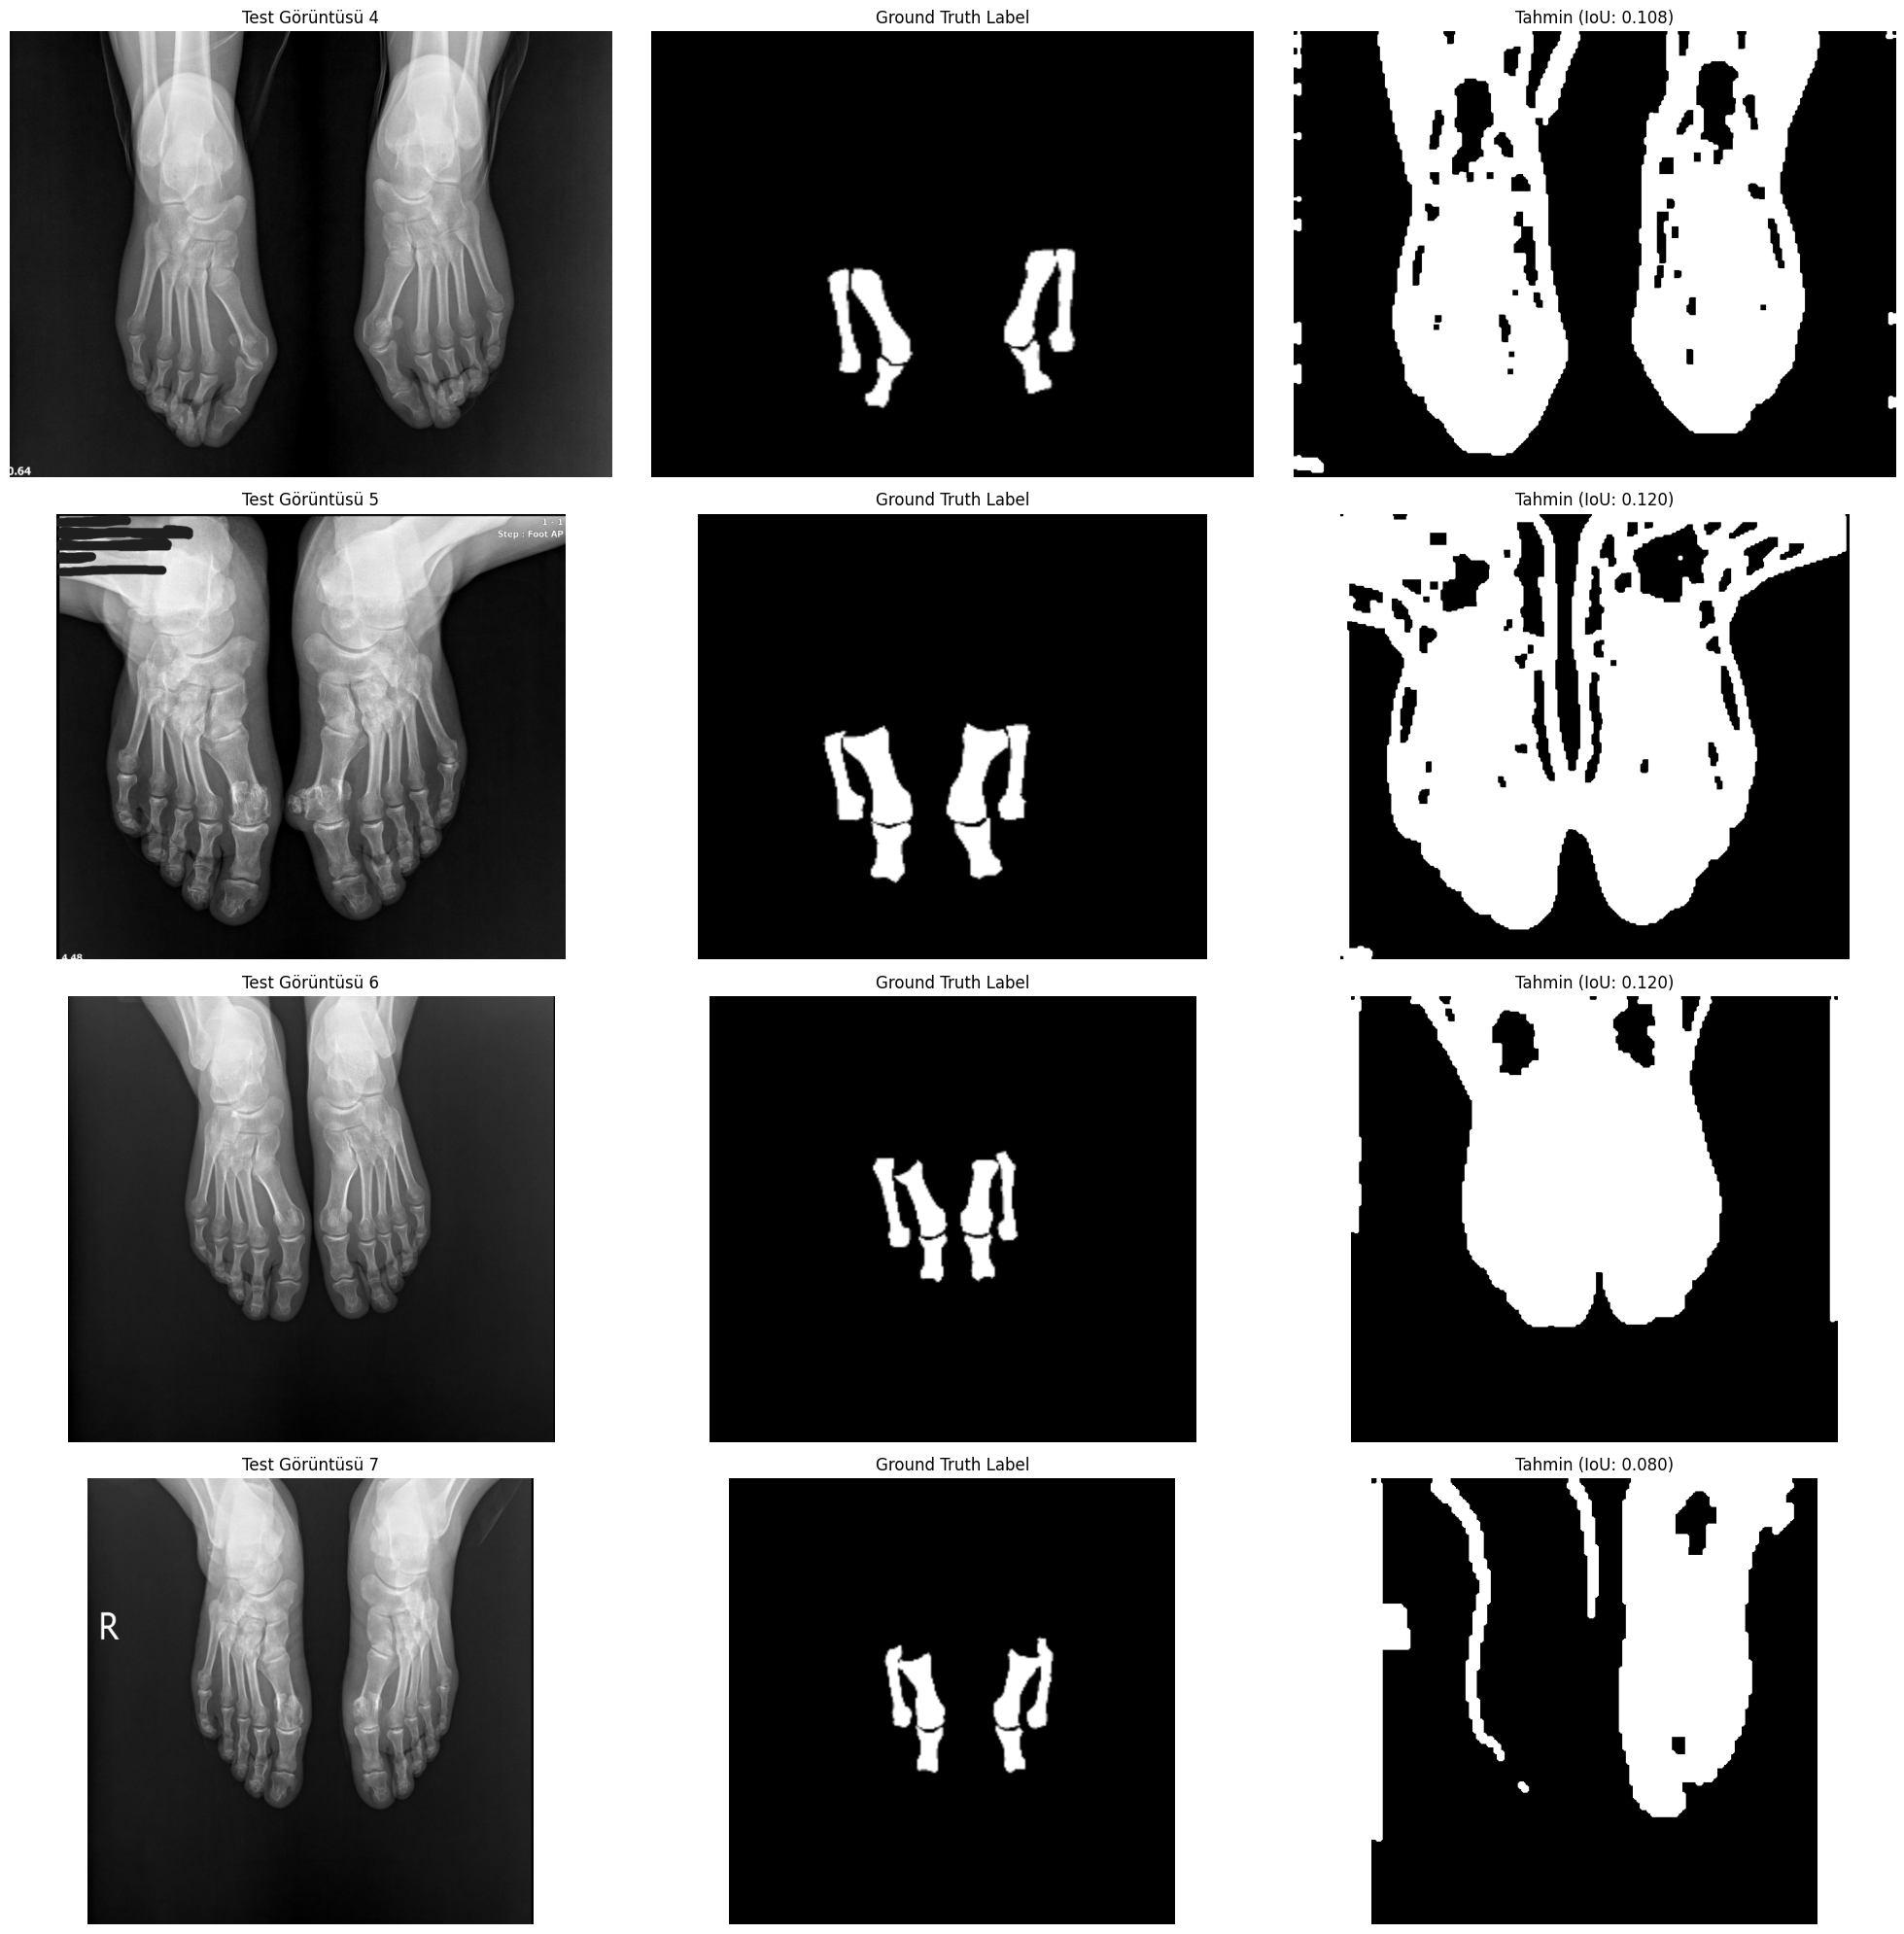


Ortalama IoU: 0.107


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist
from skimage.feature import hog
from skimage import exposure
%matplotlib inline

def apply_clahe(image):
    """Zıtlık Dönüşümü (CLAHE)"""
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    return clahe_image

def preprocess_image(image):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Contrast stretching
    p2, p98 = np.percentile(gray, (2, 98))
    stretched = exposure.rescale_intensity(gray, in_range=(p2, p98))

    # CLAHE uygula
    enhanced = apply_clahe(stretched.astype(np.uint8))

    # Gaussian blur
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)

    # Adaptive threshold
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 11, 2)

    # Morfolojik işlemler
    kernel = np.ones((3,3), np.uint8)
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

    return opening, enhanced

def minmax_norm(image):
    """MinMax normalizasyon"""
    image_float = image.astype(float)
    min_val = np.min(image_float)
    max_val = np.max(image_float)
    if max_val != min_val:
        normalized = (image_float - min_val) / (max_val - min_val) * 255
    else:
        normalized = image_float
    return normalized.astype(np.uint8)

def optimal_image_enhancement(image):
    """Görüntü iyileştirme"""
    # Contrast stretching
    p2, p98 = np.percentile(image, (2, 98))
    stretched = exposure.rescale_intensity(image, in_range=(p2, p98))

    # Gaussian blur
    gaussian = cv2.GaussianBlur(stretched, (3,3), 0.3)

    # CLAHE
    enhanced_clahe = apply_clahe(gaussian)

    return enhanced_clahe

def find_feet_contours(processed_image):
    contours, _ = cv2.findContours(processed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    return contours

def separate_feet(image, processed, enhanced):
    contours = find_feet_contours(processed)

    if len(contours) == 2:
        mask1 = np.zeros_like(processed)
        mask2 = np.zeros_like(processed)

        cv2.drawContours(mask1, [contours[0]], -1, 255, -1)
        cv2.drawContours(mask2, [contours[1]], -1, 255, -1)

        foot1 = cv2.bitwise_and(enhanced, enhanced, mask=mask1)
        foot2 = cv2.bitwise_and(enhanced, enhanced, mask=mask2)

        M1 = cv2.moments(contours[0])
        M2 = cv2.moments(contours[1])

        if M1['m00'] != 0 and M2['m00'] != 0:
            cx1 = int(M1['m10']/M1['m00'])
            cx2 = int(M2['m10']/M2['m00'])

            if cx1 < cx2:
                left_foot = foot1
                right_foot = foot2
                left_mask = mask1
                right_mask = mask2
            else:
                left_foot = foot2
                right_foot = foot1
                left_mask = mask2
                right_mask = mask1

            return left_foot, right_foot, left_mask, right_mask

    height, width = enhanced.shape[:2]
    left_foot = enhanced[:, :width//2]
    right_foot = enhanced[:, width//2:]
    left_mask = np.zeros_like(processed)
    right_mask = np.zeros_like(processed)
    left_mask[:, :width//2] = 255
    right_mask[:, width//2:] = 255

    return left_foot, right_foot, left_mask, right_mask

def safe_normalize(features, epsilon=1e-10):
    """Güvenli normalizasyon"""
    if len(features.shape) == 1:
        features = features.reshape(1, -1)
    norms = np.linalg.norm(features, axis=1)
    norms[norms < epsilon] = epsilon
    return features / norms[:, np.newaxis]

def load_model_features(model_dir):
    """HDD'den kaydedilmiş model özelliklerini yükle ve ortalama al"""
    model_path = Path(model_dir)

    if not model_path.exists():
        raise ValueError(f"Model dizini bulunamadı: {model_dir}")

    pkl_files = list(model_path.glob('*.pkl'))
    if not pkl_files:
        raise ValueError(f"PKL dosyası bulunamadı: {model_dir}")

    print(f"Bulunan model dosyaları: {len(pkl_files)}")

    # Her PKL dosyasından özellikleri yükle
    all_features = []
    for pkl_file in pkl_files:
        print(f"Yükleniyor: {pkl_file.name}")
        with open(pkl_file, 'rb') as f:
            data = pickle.load(f)
            if 'hog_features' in data:
                features = data['hog_features']
                if len(features) > 0:
                    # Her dosyanın ortalamasını al
                    mean_features = np.mean(features, axis=0)
                    all_features.append(mean_features)

    if not all_features:
        raise ValueError("Özellik yüklenemedi!")

    # Tüm özelliklerin ortalamasını al
    mean_model_features = np.mean(all_features, axis=0)
    mean_model_features = mean_model_features.reshape(1, -1)  # 2D array'e çevir

    print(f"Model özellikleri şekli: {mean_model_features.shape}")
    return mean_model_features

def extract_test_patches(image, patch_size=16, stride=4):
    """Test görüntüsünden patch'leri çıkar"""
    height, width = image.shape
    half_patch = patch_size // 2
    patches = []
    coordinates = []

    # Görüntüyü normalize et
    img_normalized = cv2.normalize(image.astype(np.float32), None, 0, 1, cv2.NORM_MINMAX)

    for y in range(half_patch, height - half_patch, stride):
        for x in range(half_patch, width - half_patch, stride):
            patch = img_normalized[y-half_patch:y+half_patch, x-half_patch:x+half_patch]

            if np.std(patch) > 0.05:
                patches.append(patch)
                coordinates.append((y, x))

    return patches, coordinates

def compare_features(test_features, model_features, threshold=0.6):
    """Test özelliklerini model özellikleriyle karşılaştır"""
    # Test özelliklerini normalize et
    test_features_norm = safe_normalize(test_features)
    model_features_norm = safe_normalize(model_features)

    # Cosine similarity hesapla
    similarities = cosine_similarity(test_features_norm, model_features_norm)

    # Threshold uygula
    predictions = similarities.flatten() > threshold

    return predictions

def calculate_iou(pred_mask, true_mask):
    """IoU (Intersection over Union) hesapla"""
    intersection = np.logical_and(pred_mask, true_mask)
    union = np.logical_or(pred_mask, true_mask)
    if np.sum(union) == 0:
        return 0
    return np.sum(intersection) / np.sum(union)

def process_test_image(img_path, label_path, model_features, threshold=0.6):
    """Test görüntüsünü işle ve tahmin yap"""
    # Görüntüleri oku
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

    if img is None or label is None:
        raise ValueError(f"Görüntü okunamadı")

    # Label'ı görüntü boyutuna resize et
    label = cv2.resize(label, (img.shape[1], img.shape[0]))

    # Görüntüleri işle
    processed_img, enhanced_img = preprocess_image(img)

    # Ayakları ayır
    left_img, right_img, left_mask, right_mask = separate_feet(img, processed_img, enhanced_img)

    # Tahmin maskesi oluştur
    pred_mask = np.zeros_like(img)

    # Sol ve sağ ayaklar için işlem
    for foot_img, mask in [(left_img, left_mask), (right_img, right_mask)]:
        # Patch'leri çıkar
        patches, coords = extract_test_patches(foot_img, stride=4)

        if len(patches) > 0:
            # HOG özelliklerini hesapla
            hog_features = []
            valid_coords = []
            for patch, coord in zip(patches, coords):
                try:
                    hog_feat = hog(patch, orientations=9,
                                 pixels_per_cell=(8, 8),
                                 cells_per_block=(2, 2),
                                 visualize=False)
                    hog_features.append(hog_feat)
                    valid_coords.append(coord)
                except Exception as e:
                    continue

            if hog_features:
                hog_features = np.array(hog_features)
                # Her patch'in özelliklerinin ortalamasını al
                mean_hog_features = np.mean(hog_features, axis=0).reshape(1, -1)

                # Tahminleri yap
                similarity = cosine_similarity(mean_hog_features, model_features)[0, 0]
                if similarity > threshold:
                    # Eğer benzerlik threshold'dan büyükse, tüm koordinatlara işaretle
                    for y, x in valid_coords:
                        cv2.circle(pred_mask, (x, y), 2, 255, -1)

    # Son işlemler
    kernel = np.ones((5,5), np.uint8)
    pred_mask = cv2.dilate(pred_mask, kernel, iterations=3)
    pred_mask = cv2.erode(pred_mask, kernel, iterations=2)
    pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # IoU hesapla
    iou = calculate_iou(pred_mask > 0, label > 0)

    return img, label, pred_mask, iou

def show_test_results(test_images, model_features, threshold=0.6):
    """Test sonuçlarını göster"""
    total_iou = 0
    n_images = len(test_images)

    plt.figure(figsize=(20, 5*n_images))

    for idx, (img_path, label_path) in enumerate(test_images):
        try:
            img, label, pred_mask, iou = process_test_image(
                img_path, label_path, model_features, threshold)

            total_iou += iou

            plt.subplot(n_images, 3, idx*3 + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f'Test Görüntüsü {idx+4}')
            plt.axis('off')

            plt.subplot(n_images, 3, idx*3 + 2)
            plt.imshow(label, cmap='gray')
            plt.title('Ground Truth Label')
            plt.axis('off')

            plt.subplot(n_images, 3, idx*3 + 3)
            plt.imshow(pred_mask, cmap='gray')
            plt.title(f'Tahmin (IoU: {iou:.3f})')
            plt.axis('off')

        except Exception as e:
            print(f"Hata ({img_path}): {e}")
            continue

    plt.tight_layout()
    plt.show()

    avg_iou = total_iou / n_images
    print(f"\nOrtalama IoU: {avg_iou:.3f}")

# Test görüntülerini tanımla
test_images = [
    ('img4.png', 'label4.png'),
    ('img5.png', 'label5.png'),
    ('img6.png', 'label6.png'),
    ('img7.png', 'label7.png')
]

try:
    # Model özelliklerini yükle
    print("Model özellikleri yükleniyor...")
    model_features = load_model_features('organ_features_patches')

    # Test sonuçlarını göster
    print("\nTest görüntüleri işleniyor...")
    show_test_results(test_images, model_features, threshold=0.6)

except Exception as e:
    print(f"Hata: {str(e)}")